# DSAIT4335 Recommender Systems
# Final Project

In this project, you will work to build different recommendation models and evaluate the effectiveness of these models through offline experiments. The dataset used for the experiments is **MovieLens100K**, a movie recommendation dataset collected by GroupLens: https://grouplens.org/datasets/movielens/100k/. For more details, check the project description on Brightspace.

# Instruction

The MovieLens100K is already splitted into 80% training and 20% test sets. Along with training and test sets, movies metadata as content information is also provided.

**Expected file structure** for this assignment:   
   
   ```
   RecSysProject/
   ├── training.txt
   ├── test.txt
   ├── movies.txt
   └── codes.ipynb
   ```

**Note:** Be sure to run all cells in each section sequentially, so that intermediate variables and packages are properly carried over to subsequent cells.

**Note** Be sure to run all cells such that the submitted file contains the output of each cell.

**Note** Feel free to add cells if you need more for answering a question.

**Submission:** Answer all the questions in this jupyter-notebook file. Submit this jupyter-notebook file (your answers included) to Brightspace. Change the name of this jupyter-notebook file to your group number: example, group10 -> 10.ipynb.

# Setup

In [ ]:
# %pip install transformers torch
# %pip install -r requirements.txt

In [1]:
import os.path
from typing import Any, List, Dict, Tuple

from huggingface_hub import model_info
from numpy import floating, ndarray, dtype, float64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import time, math
from tqdm import tqdm
import warnings
import json
import pickle
import torch

plt.rcParams['figure.dpi'] = 300 # for clearer plots in the notebook
plt.rcParams['savefig.dpi'] = 300

from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from transformers import logging
from evaluation.grid_search import grid_search
from evaluation.score_prediction_metrics import MAE, MSE, RMSE
logging.set_verbosity_error()
warnings.filterwarnings('ignore')
import pandas as pd
import itertools
from collections.abc import Callable
from typing import List
import os
# Set random seed for reproducibility
np.random.seed(10)

print("Libraries imported successfully!")

/Users/molan/Downloads/recommender-systems/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!


# Load dataset

In [2]:
# loading the training set and test set
columns_name=['user_id','item_id','rating','timestamp']
train_data = pd.read_csv('data/training.txt', sep='\t', names=columns_name)
test_data = pd.read_csv('data/test.txt', sep='\t', names=columns_name)
display(train_data[['user_id','item_id','rating']].head())
print(f'The shape of the training data: {train_data.shape}')
print(f'The shape of the test data: {test_data.shape}')

movies = pd.read_csv('data/movies.txt',names=['item_id','title','genres','description'],sep='\t')
display(movies.head())

# Load smaller version of dataset for tuning
percentage = 0.25
movies_small = movies.iloc[0: int(percentage * len(movies))]
train_data_small = train_data[train_data["item_id"].isin(movies_small["item_id"])]
content_description =  movies_small["description"]
content_description_title = movies_small["title"] + movies_small["description"]
content_full = movies["title"] + movies["genres"] + movies["description"]

,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


The shape of the training data: (80000, 4)
The shape of the test data: (20000, 4)


,item_id,title,genres,description
0,1,Toy Story (1995),"Animation, Children's, Comedy","A group of sentient toys, who pretend to be li..."
1,2,GoldenEye (1995),"Action, Adventure, Thriller","In 1986, MI6 agents James Bond and Alec Trevel..."
2,3,Four Rooms (1995),Thriller,"On New Year's Eve, bellhop Sam (Marc Lawrence)..."
3,4,Get Shorty (1995),"Action, Comedy, Drama",Chili Palmer is a Miami-based loan shark and m...
4,5,Copycat (1995),"Crime, Drama, Thriller",After giving a guest lecture on criminal psych...


# Task 1) Implementation of different recommendation models as well as a hybrid model combining those recommendation models

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #cce5ff;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <p> The cell below provides two setting for our codebase:  </p>
    <ul>
    <li><b>HYPERPARAMETER_TUNING_ON</b>: whether to perform GridSearch on our models.</li>
    <li><b>RESTORE_STATES</b>: whether to restore the saved models.</li>
    </ul>
    <p>By default, we restore the old models, saved in the "model_checkpoints" directory. Changing these will change notebook behavior.</p>
</div>




In [7]:
HYPERPARAMETER_TUNING_ON = False
RESTORE_STATES = True

## Abstract Recommender Class

In [3]:
from abc import ABC, abstractmethod
import itertools

class AbstractRecommender(ABC):
    """
    Abstract class to represent a recommendation model.
    All models in the hybrid recommender must extend this class and implement its methods.
    """
    predictions: pd.DataFrame
    rankings: Dict[int, List[tuple[int, float]]]

    @abstractmethod
    def train(self, train_data: pd.DataFrame) -> None:
        """
        This method prepares the model for usage, e.g. computing similarity matrices and training models.

        :param train_data: Dataframe containing training data, relevant keys: user_id, item_id, rating.
        """
        pass

    @abstractmethod
    def get_name(self) -> str:
        """
        Get the name of the model (used for pretty printing).

        :return: The name of the model
        """
        pass

    @abstractmethod
    def predict_score(self, user_id: int, item_id: int) -> float:
        """
        Predict a score a user would give a specific item.

        :param user_id: The id of the user
        :param item_id: The id of the item
        :return: Predicted score
        """
        pass

    def get_cached_predicted_score(self, user_id: int, item_id: int) -> float:
        """
        Lookup precomputed score a user is predicted to give an item.

        :param user_id: Id of the user
        :param item_id: Id of the item
        :returns: Predicted score
        """
        return self.predictions.loc[((self.predictions['user_id'] == user_id) & (self.predictions['item_id'] == item_id)), 'predicted_score'].values[0]

    def calculate_all_predictions(self, train_data: pd.DataFrame) -> None:
        """
        Calculate and save all rating predictions (each user/item pair) in the training data.

        :param train_data: Training data containing user_ids and item_ids
        """
        tqdm.pandas()
        user_ids = train_data['user_id'].unique()
        item_ids = train_data['item_id'].unique()
        pairs = list(itertools.product(user_ids, item_ids))
        predictions = pd.DataFrame(pairs, columns=['user_id', 'item_id'])
        predictions['predicted_score'] = predictions.apply(lambda x : self.predict_score(x['user_id'], x['item_id']), axis=1)
        self.predictions = predictions
        self.normalize_predictions()

    def calculate_all_rankings(self, k: int, train_data: pd.DataFrame) -> None:
        """
        For each user in the training data, calculate the predicted ranking and save it.

        :param k: Ranking list size
        :param train_data: Training data containing user ids
        """
        tqdm.pandas()
        user_ids = train_data['user_id'].unique()
        self.rankings = {}
        for user_id in tqdm(user_ids):
            user_df = self.predictions.loc[
                (self.predictions['user_id'] == user_id),
                ['item_id', 'predicted_score']
            ]

            top_k = (
                user_df.nlargest(k, 'predicted_score')
                .apply(lambda row: (row['item_id'], row['predicted_score']), axis=1)
                .tolist()
            )
            self.rankings[user_id] = top_k

    def get_ranking(self, user_id: int, k: int) -> List[tuple[int, float]]:

        """
        Lookup precomputed ranking for a user.

        :param user_id: Id of the user
        :param k: Maximum size of recommendation list
        :returns: List of pairs of item_ids and scores (ordered descending)
        """
        return self.rankings[user_id][:k]

    def _get_predictions_file_path(self, is_test: bool = False) -> str:
        """
        Get the file path for storing/loading precomputed predictions.

        :param is_test: Whether to use the test or train folder
        :return: File path as string
        """
        folder_path = os.path.join(f'model_checkpoints/{"test" if is_test else "train"}', self.get_name().replace(" ", "_").lower())
        filepath = os.path.join(folder_path, 'predictions.csv')
        os.makedirs(folder_path, exist_ok=True)
        return filepath

    def _get_ranking_predictions_file_path(self, is_test: bool = False) -> str:
        """
        Get the folder path to which rankings can be saved.

        :param is_test: Whether to use the test or train folder
        :return: File path as string
        """
        folder_path = os.path.join(f'model_checkpoints/{"test" if is_test else "train"}', self.get_name().replace(" ", "_").lower())
        filepath = os.path.join(folder_path, 'rankings')
        os.makedirs(filepath, exist_ok=True)
        return filepath

    def checkpoint_exists(self, is_test: bool = False) -> bool:
        """
        Check if a checkpoint file for predictions exists.

        :param is_test: Whether to check in the test or train folder
        :return: True if the checkpoint file exists, False otherwise
        """
        return os.path.isfile(self._get_predictions_file_path(is_test=is_test))

    def load_predictions_from_file(self, is_test: bool = False) -> None:
        """
        Load precomputed predictions from a CSV file.

        :param is_test: Whether to load from the test or train folder
        """
        if is_test:
            self.predictions = pd.read_csv(self._get_predictions_file_path(is_test=True))
            self.test_predictions = pd.read_csv(self._get_predictions_file_path(is_test=True))
        else:
            self.predictions = pd.read_csv(self._get_predictions_file_path(is_test=False))
        self.normalize_predictions()

    def load_ranking_from_file(self, user_id:int, is_test: bool = False) -> None:
        """
        Load precomputed rankings from a CSV file.

        :param user_id: Id of the user
        """
        file_path = os.path.join(self._get_ranking_predictions_file_path(is_test=is_test), f'user_{user_id}_ranking.csv')
        if not hasattr(self, "rankings") or self.rankings is None:
            self.rankings = {}
        self.rankings[user_id] = pd.read_csv(file_path)

    def load_all_rankings_from_file(self, train_data: pd.DataFrame, is_test: bool = False):
        """
        Load precomputed rankings for all users in the training data from CSV files.
        :param train_data:
        :return:
        """
        for user in tqdm(train_data["user_id"].unique()):
            self.load_ranking_from_file(user, is_test=is_test)

    def save_predictions_to_file(self, is_test: bool = False) -> None:
        """
        Save precomputed predictions to a CSV file.

        :param is_test: Whether to save to the test or train folder
        """
        self.predictions.to_csv(self._get_predictions_file_path(is_test=is_test), index=False)


    def save_rankings_to_file(self, is_test: bool = False) -> None:
        """
        Save precomputed rankings to a set of CSV files and a JSON mapping file.

        :param is_test: Whether to save to the test or train folder
        """
        folder_path = self._get_ranking_predictions_file_path(is_test=is_test)
        user_dict = {}

        for user_id, ranking in self.rankings.items():
            ranking_df = pd.DataFrame(ranking, columns=['item_id', 'predicted_score'])
            filepath = os.path.join(folder_path, f'user_{user_id}_ranking.csv')
            ranking_df.to_csv(filepath, index=False)
            user_dict[int(user_id)] = filepath

        with open(os.path.join(folder_path, 'user_ranking_file_map.json'), 'w') as f:
            json.dump(user_dict, f, indent=4)

    def calculate_rating_predictions_test_data(self, test_data: pd.DataFrame) -> None:
        """
        Calculate all predictions and rankings for the test data.

        :param test_data: Test data containing user_ids and item_ids
        """
        self.calculate_all_predictions(test_data)
        self.save_predictions_to_file(is_test=True)
        print("Calculated and saved predictions for test data.")
        
    def normalize_predictions(self, min_rating: float = 1.0, max_rating: float = 5.0) -> None:
        """
        Linearly normalize all predicted scores to a valid range [min_rating, max_rating].

        :param min_rating: Minimum rating value (default=1.0)
        :param max_rating: Maximum rating value (default=5.0)
        """
        if not hasattr(self, "predictions") or self.predictions is None or self.predictions.empty:
            raise ValueError("No predictions available to normalize. Please run calculate_all_predictions() first.")

        preds = self.predictions["predicted_score"]
        min_pred, max_pred = preds.min(), preds.max()

        if min_pred == max_pred:
            # avoid division by zero if all predictions are identical
            self.predictions["predicted_score"] = min_rating + (max_rating - min_rating) / 2
            print("All predictions had the same value. Set to midpoint of normalization range.")
            return

        self.predictions["predicted_score"] = (
            min_rating + (preds - min_pred) * (max_rating - min_rating) / (max_pred - min_pred)
        )

        print(f"Predictions normalized linearly to range [{min_rating}, {max_rating}].")

    def calculate_ranking_predictions_test_data(self, test_data: pd.DataFrame, k: int) -> None:
        """
        Calculate all predictions and rankings for the test data.

        :param test_data: Test data containing user_ids and item_ids
        :param k: Ranking list size
        """
        self.calculate_all_rankings(k, test_data)
        self.save_rankings_to_file(is_test=True)
        print("Calculated and saved predictions and rankings for test data.")
        
    def _get_model_file_path(self, is_test: bool = False) -> str:
        """
        Get the file path for storing/loading precomputed predictions.

        :param is_test: Whether to use the test or train folder
        :return: File path as string
        """
        folder_path = os.path.join(f'model_checkpoints/{"test" if is_test else "train"}', self.get_name().replace(" ", "_").lower())
        filepath = os.path.join(folder_path, 'model')
        os.makedirs(filepath, exist_ok=True)
        return filepath


<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #cce5ff;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <p> To facilitate the implementation of the hybrid recommender system, we created an abstract recommender class. Each of the recommendation algorithms implemented in this task, extends this abstract recommender class and implements a method to train the algorithm and predict a score for a user/item pair. Furthermore, the class provides functionality to save and load predictions from a csv file to facilitate evaluation. <br> <br> Below we list the implementation of each single recommendation algorithm and the tuning of hyperparameters on a small subset of the training data. </p>
</div>

In [4]:
from collections.abc import Callable

def grid_search(hyperparameter_dict: dict, recommendation_algorithm:AbstractRecommender, train_data:pd.DataFrame,  metric: Callable[[List[int], List[int]], dict], similarity_matrix=None) -> dict:
    best_config = {}
    hyperparams = hyperparameter_dict.keys()
    combinations = itertools.product(*hyperparameter_dict.values())
    gridsearch = [dict(zip(hyperparams, cc)) for cc in combinations]
    params = []

    best_params = None 
    best_params_score = float('inf')
    for grid in tqdm(gridsearch): 
        recommendation_algorithm_curr = recommendation_algorithm(**grid)
        if isinstance(recommendation_algorithm_curr, UserKNN) or isinstance(recommendation_algorithm_curr, ItemKNN) :
            recommendation_algorithm_curr.restore_training(train_data, similarity_matrix)
        else:
            recommendation_algorithm_curr.train(train_data)
        recommendation_algorithm_curr.calculate_all_predictions(train_data)
        score = metric(recommendation_algorithm_curr.predictions["predicted_score"], train_data["rating"])
        params.append((score, grid))
        print("Parameters", [(k, grid[k]) for k in grid.keys() if (k != "data" and k!= "content")], "with metric:", score)
        if score < best_params_score: 
            best_params = grid
            best_params_score = score
            
    print("-----------------------------------")
    print("Best params metric", best_params_score)
    print("Best params:", [(k, best_params[k]) for k in best_params.keys() if (k != "data" and k!= "content")])

            
    return best_config, params

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #cce5ff;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <b><i>Why we use GridSearch</i></b>
    <p> Our parameters have well-known properties, such as neighborhoods, or what latent factors do. Using GridSearch gives us a systematic approach to our choices. We separate 25% of our testing data for this GridSearch due to the high computational demand of the recommender systems. </p>
</div>


---
## Content-Based

In [8]:
from transformers import AutoTokenizer, AutoModel

class ContentBasedRecommender(AbstractRecommender):
    """
    Content-based recommender based on embeddings from BERT.
    """
    item_embeddings: np.array
    bert_model: str
    data: pd.DataFrame
    predicted_ratings: np.array
    min_val: float
    max_val: float
    aggregation_method: str

    def __init__(self, bert_model:str, data:pd.DataFrame, batch_size:int, aggregation_method:str, content:List[str]):
        super().__init__()
        self.item_embeddings = []
        self.bert_model = bert_model
        self.data = data
        self.batch_size = batch_size
        self.aggregation_method = aggregation_method
        self.content = content

    def train(self, train_data):
        self.train_embeddings(self.bert_model, self.content, self.batch_size,)

        predicted_ratings = train_data.apply(
            lambda row: self.predict_computability_between_user_and_item(
                row["user_id"], row["item_id"]
            ),
            axis=1
            )

        preds = predicted_ratings.to_numpy(dtype=float)
        self.predicted_ratings = preds
        self.min_val = np.min(preds)
        self.max_val = np.max(preds)


    def train_embeddings(self, model_name:str, content:pd.DataFrame, batch_size:int) -> None:
        """
        This method prepares the model for usage, in this case this means loading it
        with content embeddings.
        """
        if content is None:
            return None

        if isinstance(content, pd.Series):
            content = content.fillna("").astype(str).tolist()
        elif isinstance(content, np.ndarray):
            content = content.astype(str).tolist()

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        model.eval()
        emb = []

        for i in tqdm(range(0, len(content), batch_size)):

            batch_texts = content[i:i + batch_size]

            # Tokenize batch
            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors='pt'
            )

            # Move to device
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Generate embeddings
            with torch.no_grad():
                outputs = model(**inputs)

                # Use [CLS] token embedding (first token)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                emb.extend(batch_embeddings)

        emb = np.array(emb)
        self.item_embeddings = emb

        return emb

    def get_item_emb(self, item_id) -> np.array:
        return self.item_embeddings[item_id - 1]

    def get_items_per_user_with_rating(self, user_id):
        mask = self.data["user_id"] == user_id
        user_data = self.data.loc[mask, ["item_id", "rating"]]
        ratings = user_data["rating"].to_numpy()
        embeddings = np.stack(user_data["item_id"].apply(lambda x: self.get_item_emb(x)))

        return embeddings, ratings

    def get_user_emb(self, user_id) -> np.array:
        embeddings, ratings = self.get_items_per_user_with_rating(user_id)
        user_representation = []

        if self.aggregation_method == "average":
            user_representation = np.mean(embeddings, axis=0)
        elif self.aggregation_method == "weighted_average":
            weighted = [e * r for e, r in zip(embeddings, ratings)]
            rating_sum = np.sum(ratings)
            user_representation = np.sum(weighted, axis=0) / rating_sum
        elif self.aggregation_method ==  "avg_pos":
            embeddings_filtered = [emb for (emb, rat) in zip(embeddings, ratings) if rat >= 4]
            if(len(embeddings_filtered) > 0):
                user_representation = np.mean(embeddings_filtered, axis=0)
            else:
                user_representation = np.zeros(embeddings[0].shape)


        return user_representation

    def get_name(self) -> str:
        """
        Get the name of the model (used for pretty printing).

        :return: The name of the model
        """
        return "Content Based Recommender"

    def predict_computability_between_user_and_item(self, user_id, item_id):
        user_emb = self.get_user_emb(user_id)
        item_emb = self.get_item_emb(item_id)
        similarity = np.dot(user_emb, item_emb)

        return similarity


    def predict_score(self, user_id: int, item_id: int) -> float:
        """
        Predict a score a user would give a specific item.

        :param user_id: The id of the user
        :param item_id: The id of the item
        :return: Predicted score
        """
        score = self.predict_computability_between_user_and_item(user_id, item_id)
        rating = 1 + (score - self.min_val) * (4 / (self.max_val - self.min_val))
        return rating

    def save_model(self):
        """Save embeddings, parameters, and settings"""
        folder_path = self._get_model_file_path()
        os.makedirs(folder_path, exist_ok=True)

        # Save item embeddings
        np.save(os.path.join(folder_path, "item_embeddings.npy"), self.item_embeddings)

        # Save scalar values
        with open(os.path.join(folder_path, "scalars.pkl"), "wb") as f:
            pickle.dump({
                "min_val": self.min_val,
                "max_val": self.max_val
            }, f)

        # Save configuration/settings
        with open(os.path.join(folder_path, "settings.pkl"), "wb") as f:
            pickle.dump({
                "bert_model": self.bert_model,
                "batch_size": self.batch_size,
                "aggregation_method": self.aggregation_method
            }, f)

        # Save data (optional, only if needed for inference)
        if self.data is not None:
            self.data.to_csv(os.path.join(folder_path, "data.csv"), index=False)

        print(f"Content-based model saved to {folder_path}")

    def load_model(self):
        """Load embeddings, parameters, and settings"""
        folder_path = self._get_model_file_path()

        # Load embeddings
        self.item_embeddings = np.load(os.path.join(folder_path, "item_embeddings.npy"))

        # Load scalars
        with open(os.path.join(folder_path, "scalars.pkl"), "rb") as f:
            scalars = pickle.load(f)
            self.min_val = scalars["min_val"]
            self.max_val = scalars["max_val"]

        # Load settings
        with open(os.path.join(folder_path, "settings.pkl"), "rb") as f:
            settings = pickle.load(f)
            self.bert_model = settings["bert_model"]
            self.batch_size = settings["batch_size"]
            self.aggregation_method = settings["aggregation_method"]

        # Load data if it exists
        data_path = os.path.join(folder_path, "data.csv")
        if os.path.exists(data_path):
            self.data = pd.read_csv(data_path)
        else:
            self.data = None

        print(f"Content-based model loaded from {folder_path}")

### Hyperparameter Tuning

In [9]:
hyperparameters_content_based = {
    "aggregation_method": ["average", "weighted_average", "avg_pos"],
    "bert_model": ['boltuix/bert-mini', 'distilbert-base-uncased'],
    "data": [train_data_small],
    "batch_size": [16],
    "content": [content_description, content_description_title, content_full]
}

if HYPERPARAMETER_TUNING_ON:
    best_parameters_cb, params_cb = grid_search(hyperparameters_content_based, ContentBasedRecommender, train_data_small, RMSE)
else: 
    best_parameters_cb = {
        "aggregation_method": "avg_pos",
        "bert_model": 'boltuix/bert-mini',
        "data": train_data,
        "batch_size": 16,
        "content": content_full
    }

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #cce5ff;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">

<p>
We implemented a standard content-based recommender based on item embeddings. 
A user is represented via an <strong>aggregate</strong> of the items they have consumed. 
In this case, either:
</p>

<ul>
  <li>average of all</li>
  <li>weighted average of all</li>
  <li>average of all above a 3 (average positive ratings)</li>
</ul>

<p>
Subsequently, the alignment between the user and any item is measured via a dot product 
between the aggregated user and that item. This follows the idea that latent embeddings 
are close to each other in vector space if similar. Finally, the scores are normalized 
to a 1–5 range.
</p>

<p>
The embeddings we used were from an LLM's encoder — in this case, various pre-trained versions 
of BERT. Due to computational constraints, we looked for other, more lightweight models. 
What we found was that the embeddings impact the performance across different trainings, 
both in the content embedded and in the model used. As such, we experimented with different 
BERT encoders as well.
</p>

<p>The hyperparameters we were choosing from were:</p>

<pre>
{
  "aggregation_method": ["average", "weighted_average", "avg_pos"],
  "bert_model": ["boltuix/bert-mini", "distilbert-base-uncased"],
  "content_embedding": [
    "content_title_genres", 
    "content_description", 
    "content_title_genre_description"
  ]
}
</pre>

<p>
In the end, the best configuration was using 
<code>avg_pos</code>, <code>boltuix/bert-mini</code>, and 
<code>content_full</code>, which contains the full information to be embedded. 
Neither of these results are surprising: the average positive rating emphasizes what users like, 
the simpler BERT model generalizes better, and the combined content embedding provides the most information. They gave an RMSE of approx. 0.418.
</p>

</div>


#### Train Best Model
Run this cell to retrieve the CB model with the best configuration.

In [10]:
content_based_best = ContentBasedRecommender(**best_parameters_cb)
if content_based_best.checkpoint_exists() and RESTORE_STATES:
    content_based_best.load_predictions_from_file()
    content_based_best.load_all_rankings_from_file(train_data)
    content_based_best.load_model()
if HYPERPARAMETER_TUNING_ON :
    content_based_best.train(train_data)
    content_based_best.calculate_all_predictions(train_data)
    content_based_best.calculate_all_rankings(10, train_data)
    content_based_best.save_predictions_to_file()
    content_based_best.save_rankings_to_file()
    content_based_best.save_model()

Predictions normalized linearly to range [1.0, 5.0].


100%|██████████| 943/943 [00:00<00:00, 3960.73it/s]

Content-based model loaded from model_checkpoints/train/content_based_recommender/model


---
## User-based Collaborative Filtering

In [11]:
def user_similarity(user1_ratings, user2_ratings) -> float:
    """
    Compute Pearson correlation similarity between two users based on shared item ratings.
    :param user1_ratings: Series of ratings with index = item_id
    :param user2_ratings: Series of ratings with index = item_id
    :return:
    """
    merged = pd.merge(user1_ratings, user2_ratings, left_index=True, right_index=True, suffixes=('_1', '_2'),
                      how='inner')
    if merged.empty:
        return 0.0

    u1 = merged['rating_1']
    u2 = merged['rating_2']
    mx = np.mean(u1)
    my = np.mean(u2)
    numerator = np.sum((u1 - mx) * (u2 - my))
    denominator = np.sqrt(np.sum((u1 - mx) ** 2)) * np.sqrt(np.sum((u2 - my) ** 2))

    return numerator / denominator if denominator != 0 else 0.0

class UserKNN(AbstractRecommender):

    def __init__(self, k: int = 5):
        """
        Initialize the UserKNN model with training and testing data.

        Parameters
        :param k: k value for number of nearest neighbors
        """
        self.train_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.user_ids = []
        self.k = k
        self.similarity_matrix = pd.DataFrame()
        self.user_means = pd.Series()
        self.fit = False

    def get_name(self) -> str:
        return 'User KNN'

    def train(self, train_data: pd.DataFrame) -> None:
        self.train_data = train_data
        self.user_ids = list(self.train_data['user_id'].unique())
        self.user_means = self.train_data.groupby('user_id')['rating'].mean()

        self.similarity_matrix = pd.DataFrame(np.zeros((len(self.user_ids), len(self.user_ids))), index=self.user_ids, columns=self.user_ids)
        by_user = {uid: grp.set_index('item_id')['rating'] for uid, grp in train_data.groupby('user_id')}

        for i, user1 in tqdm(enumerate(self.user_ids)):
            r1 = by_user[user1]
            for j in range(i + 1, len(self.user_ids)):
                user2 = self.user_ids[j]
                r2 = by_user[user2]
                s = user_similarity(r1, r2)
                self.similarity_matrix.loc[user1, user2] = s
                self.similarity_matrix.loc[user2, user1] = s  # mirror
        self.fit = True

    def restore_training(self, train_data, similarity_matrix):
        self.train_data = train_data
        self.user_ids = list(self.train_data['user_id'].unique())
        self.user_means = self.train_data.groupby('user_id')['rating'].mean()

        self.similarity_matrix = similarity_matrix
        self.fit = True

    def get_k_neighbors(self, target_user, similarity_matrix: pd.DataFrame = None) -> pd.Series:
        if similarity_matrix is None:
            similarity_matrix = self.similarity_matrix
        if target_user not in self.similarity_matrix.index:
            return pd.Series()

        sims = similarity_matrix[target_user].drop(target_user, errors='ignore').sort_values(ascending=False).head(
            self.k)
        return sims

    def predict_score(self, target_user, target_item) -> float:
        """
        Predict rating for a given user and item using UserKNN approach.

        r*_u,i = r_u + Σ (sim(u,v) * (r_v,i - r_v)) / Σ |sim(u,v)|

        where:
        - r*_u,i is the predicted rating for user u on item i
        - r_u - mean rating of target user u
        - sim(u,v) - similarity between target user u and neighbor user v
        - r_v,i - rating of neighbor user v on item i
        - r_v - mean rating of neighbor user v

        :param target_user: target user id
        :param target_item: target item id
        """
        if not self.fit:
            raise Exception("Model not trained yet. Call train() before predict_score().")

        item_i = self.train_data[self.train_data['item_id'] == target_item].set_index('user_id')
        users_that_rated_i = item_i.index.values.tolist()
        # print(f'users_that_rated_i: \n{users_that_rated_i}')

        sim_matrix_masked = self.similarity_matrix.loc[users_that_rated_i]
        # print(f'sim_matrix_masked: \n{sim_matrix_masked}')
        sims = self.get_k_neighbors(target_item, sim_matrix_masked)
        # print(f'sims: \n{sims}')

        if sims.empty:
            return 0.0 # TODO: return mean score for item / of user - design choice

        ni = sims.index.values
        # print(f'ni \n{ni}')
        rvi = np.array([item_i.at[n, 'rating'] for n in ni])
        # print(f'rvi \n{rvi}')
        rv = np.array([self.user_means.loc[n] for n in ni])
        # print(f'rv \n{rv}')

        numerator = np.sum(sims.values * (rvi - rv))
        denominator = np.sum(np.abs(sims.values))
        
        score = self.user_means.loc[target_user] + (numerator / denominator) \
            if denominator != 0 else self.user_means.loc[target_user]

        return score 

    def predict_ranking(self, user_id, n: int = 10) -> list:
        """
        Predict the top-n recommended items for a given user using UserKNN approach.
        :param user_id: target user id
        :param n: number of recommendations to return
        :return: list of (item_id, predicted_score) sorted by score desc.
        """
        pass

    def save_model(self):
        """Save model parameters, similarity matrix, and data."""
        folder_path = self._get_model_file_path()
        os.makedirs(folder_path, exist_ok=True)

        # Save training data
        if not self.train_data.empty:
            self.train_data.to_csv(os.path.join(folder_path, "train_data.csv"), index=False)

        # Save similarity matrix
        self.similarity_matrix.to_csv(os.path.join(folder_path, "similarity_matrix.csv"))

        # Save user means
        self.user_means.to_csv(os.path.join(folder_path, "user_means.csv"), header=["mean_rating"])

        # Save configuration
        with open(os.path.join(folder_path, "config.pkl"), "wb") as f:
            pickle.dump({
                "k": self.k,
                "fit": self.fit
            }, f)

        print(f"UserKNN model saved to {folder_path}")

    def load_model(self):
        """Load model parameters, similarity matrix, and data."""
        folder_path = self._get_model_file_path()

        # Load training data
        train_path = os.path.join(folder_path, "train_data.csv")
        if os.path.exists(train_path):
            self.train_data = pd.read_csv(train_path)
            self.user_ids = list(self.train_data['user_id'].unique())
        else:
            self.train_data = pd.DataFrame()

        # Load similarity matrix
        self.similarity_matrix = pd.read_csv(os.path.join(folder_path, "similarity_matrix.csv"), index_col=0)
        self.similarity_matrix.index = self.similarity_matrix.index.astype(int)
        self.similarity_matrix.columns = self.similarity_matrix.columns.astype(int)

        # Load user means
        self.user_means = pd.read_csv(os.path.join(folder_path, "user_means.csv"), index_col=0)["mean_rating"]

        # Load configuration
        with open(os.path.join(folder_path, "config.pkl"), "rb") as f:
            cfg = pickle.load(f)
            self.k = cfg["k"]
            self.fit = cfg["fit"]

        print(f"UserKNN model loaded from {folder_path}")


In [12]:
hyperparameters_user_knn = {
    "k": [5, 7, 8, 9, 10, 11, 12, 13]
}
if HYPERPARAMETER_TUNING_ON:
    u_knn = UserKNN(2)
    u_knn.train(train_data_small)
    similarity_matrix = u_knn.similarity_matrix
    best_parameters_uknn, params_uknn = grid_search(hyperparameters_user_knn, UserKNN, train_data_small, RMSE, similarity_matrix=similarity_matrix)
else:
    best_parameters_uknn = {
        "k": 11
    }

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #cce5ff;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
<p>
The classical memory-based collaborative filtering algorithm is based on similarity to other users. 
We look for users that rated items similarly to a given user, and then estimate user 
<em>u</em>'s missing ratings based on that. 
<br> <br> For our similarity, we chose to use Pearson correlation 
between each user: the higher, the more similar the user. From there, <em>k</em> users are collected 
(the ones with the highest similarity), and the final score is interpolated based on their similarity. 
We measure similarity only based on the values <strong>both</strong> users have rated. When making a 
prediction for a given rating, we also limit ourselves to neighbors that have rated this item.
</p>

<p>
The only value to tune accordingly was the size of the user's neighborhood. Too small a neighborhood 
<em>k</em> might give biased or random-like results, whereas too large a neighborhood just converges 
to a mean prediction of the rating.
</p>

<p>The parameters we chose were:</p>

<pre>
{
  "k": [2, 3, 5, 7, 9, 11]
}
</pre>

<p>
Our simple GridSearch gave us a value of <em>k = 11</em> as the best neighborhood metric. 
This is not surprising, considering the large size of our dataset, giving us plenty of options 
to make informed predictions.
</p>
</div>


### Train Best Model
Run this cell to retrieve the UKN model with the best configuration.

In [13]:
user_knn_best = UserKNN(**best_parameters_uknn)
if user_knn_best.checkpoint_exists():
    user_knn_best.load_predictions_from_file()
    user_knn_best.load_all_rankings_from_file(train_data)
    user_knn_best.load_model()
if HYPERPARAMETER_TUNING_ON or not RESTORE_STATES:
    user_knn_best.train(train_data)
    user_knn_best.calculate_all_predictions(train_data)
    user_knn_best.calculate_all_rankings(10, train_data)
    user_knn_best.save_predictions_to_file()
    user_knn_best.save_rankings_to_file()
    user_knn_best.save_model()

Predictions normalized linearly to range [1.0, 5.0].


100%|██████████| 943/943 [00:00<00:00, 3024.37it/s]

UserKNN model loaded from model_checkpoints/train/user_knn/model


---
## Item-based Collaborative Filtering

In [ ]:
def item_similarity(item1_ratings, item2_ratings) -> float:
    """
    Compute cosine similarity between two items based on shared user ratings.

    :param item1_ratings: Series of ratings with index = user_id, name = 'rating'
    :param item2_ratings: Series of ratings with index = user_id, name = 'rating'
    :return: similarity score as a float. 1 means identical, 0 means no similarity.
    """
    merged = pd.merge(item1_ratings, item2_ratings, left_index=True, right_index=True, suffixes=('_1', '_2'), how='inner')
    if merged.empty:
        return 0.0
    sim = 1 - cosine(merged['rating_1'], merged['rating_2'])
    return sim


class ItemKNN(AbstractRecommender):

    def __init__(self, k: int = 5, similarity="cosine"):
        """
        Initialize the ItemKNN model.

        Parameters
        :param k: k value for number of nearest neighbors
        """
        self.similarity = ""
        self.train_data = pd.DataFrame() # train_data
        self.test_data = pd.DataFrame() # test_data
        self.item_ids = []
        self.k = k
        self.similarity_matrix = pd.DataFrame()  # Empty so that it can be filled later
        self.fit = False

    def get_name(self) -> str:
        return 'Item KNN'

    def train(self, train_data: pd.DataFrame) -> None:
        self.train_data = train_data
        self.item_ids = list(self.train_data['item_id'].unique())  # items in training data
        
        # Get similarity matrix
        self.similarity_matrix = pd.DataFrame(np.zeros((len(self.item_ids), len(self.item_ids))), index=self.item_ids,
                                              columns=self.item_ids)
        by_item = {iid: grp.set_index('user_id')['rating'] for iid, grp in train_data.groupby('item_id')}
        # Fill only the upper triangle and mirror it (half the work)
        for i, item1 in tqdm(enumerate(self.item_ids)):
            r1 = by_item[item1]
            for j in range(i + 1, len(self.item_ids)):
                item2 = self.item_ids[j]
                r2 = by_item[item2]
                s = item_similarity(r1, r2)
                self.similarity_matrix.loc[item1, item2] = s
                self.similarity_matrix.loc[item2, item1] = s
        self.fit = True
        
    def restore_training(self, train_data, similarity_matrix):
        self.train_data = train_data
        self.item_ids = list(self.train_data['item_id'].unique())  # items in training data
        self.similarity_matrix = similarity_matrix
        self.fit = True 

    def get_k_neighbors(self, target_item, similarity_matrix: pd.DataFrame = None) -> pd.Series:
        """
        Get top-k most similar items to target item.

        Parameters:
        :param target_item: target item id
        :param similarity_matrix: masked similarity matrix to use. If None, use self.similarity_matrix.

        Returns:
        :return: List of tuples: [(neighbor_item_id, similarity), ...]
        """
        if similarity_matrix is None:
            similarity_matrix = self.similarity_matrix
        if target_item not in self.similarity_matrix.index:
            return pd.Series()

        sims = similarity_matrix[target_item].drop(target_item, errors='ignore').sort_values(ascending=False).head(self.k)
        return sims

    def predict_score(self, target_user, target_item) -> float:
        """
        Predict rating for a given user and item using k-NN.

        r*_u,i = (Sum_(j in N_i) (s_i,j * r_u,j)) / (Sum_(j in N_i) |s_i,j|)

        N_i = set of top-k most similar items to target item i that target user u has rated
        s_i,j = similarity between target item i and item j ([sims])
        r_u,j = rating of target user u for item j

        Parameters:
        :param target_user: user id
        :param target_item: item id

        Returns:
        :return: predicted rating (float)
        """
        if not self.fit:
            raise Exception("Model not trained yet. Call train() before predict_score().")

        user_u = self.train_data[self.train_data['user_id'] == target_user].set_index('item_id')
        items_rated_by_u = user_u.index.values.tolist()

        item_sim_matrix_masked = self.similarity_matrix.loc[items_rated_by_u]  # [items_rated_by_u]
        sims = self.get_k_neighbors(target_item,
                                    item_sim_matrix_masked)  # Series indexed by item_id, values are similarities
        if sims.empty:
            return 3.0  # TODO: return mean score for item / of user

        ni = sims.index.values  # N_i
        ruj = pd.Series([user_u.at[n, 'rating'] for n in ni], index=ni)  # ratings of target user for items in ni

        numerator = (sims * ruj).sum()
        denominator = sims.abs().sum()

        return numerator / denominator if denominator != 0 else 0.0
    
    def save_model(self):
        """Save model configuration, training data, and similarity matrix."""
        folder_path = self._get_model_file_path()
        os.makedirs(folder_path, exist_ok=True)

        # Save training data
        if not self.train_data.empty:
            self.train_data.to_csv(os.path.join(folder_path, "train_data.csv"), index=False)

        # Save similarity matrix
        self.similarity_matrix.to_csv(os.path.join(folder_path, "similarity_matrix.csv"))

        # Save config
        with open(os.path.join(folder_path, "config.pkl"), "wb") as f:
            pickle.dump({
                "k": self.k,
                "similarity": self.similarity,
                "fit": self.fit
            }, f)

        print(f"ItemKNN model saved to {folder_path}")

    def load_model(self):
        """Load model configuration, training data, and similarity matrix."""
        folder_path = self._get_model_file_path()

        # Load training data
        train_path = os.path.join(folder_path, "train_data.csv")
        if os.path.exists(train_path):
            self.train_data = pd.read_csv(train_path)
            self.item_ids = list(self.train_data['item_id'].unique())
        else:
            self.train_data = pd.DataFrame()

        # Load similarity matrix
        sim_path = os.path.join(folder_path, "similarity_matrix.csv")
        if os.path.exists(sim_path):
            self.similarity_matrix = pd.read_csv(sim_path, index_col=0)
            self.similarity_matrix.index = self.similarity_matrix.index.astype(int)
            self.similarity_matrix.columns = self.similarity_matrix.columns.astype(int)
        else:
            self.similarity_matrix = pd.DataFrame()

        # Load configuration
        cfg_path = os.path.join(folder_path, "config.pkl")
        if os.path.exists(cfg_path):
            try:
                with open(cfg_path, "rb") as f:
                    cfg = pickle.load(f)
                    self.k = cfg.get("k", 5)
                    self.similarity = cfg.get("similarity", "cosine")
                    self.fit = cfg.get("fit", False)
            except (EOFError, pickle.UnpicklingError, AttributeError, ValueError):
                # Handle corrupted or empty pickle
                self.k = 5
                self.similarity = "cosine"
                self.fit = False
        else:
            self.k = 5
            self.similarity = "cosine"
            self.fit = False

        print(f"ItemKNN model loaded from {folder_path}")



### Hyperparameter Tuning

In [15]:
hyperparameters_item_knn = {
    "k": [2, 3, 5, 7, 8, 9, 10, 11]
}
if HYPERPARAMETER_TUNING_ON:
    i_knn = ItemKNN(2)
    i_knn.train(train_data_small)
    similarity_matrix = i_knn.similarity_matrix
    best_parameters_iknn, params_iknn = grid_search(hyperparameters_item_knn, ItemKNN, train_data_small, RMSE, similarity_matrix=similarity_matrix)
else:
    best_parameters_iknn = {
        "k": 11
    }

<div style="
    background-color:#cce5ff;
    color:black;
    padding:10px;
    border-left:5px solid #004085;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <p> Switching to the Item-Based perspective, we change some things. Similar to how we were treating the content-based embedding, but now based on the ratings, we use <b>cosine similarity</b> on the ratings of items between all users to measure the similarity between items. We subsequently consider the items most similar to the item being rated and once again compute a weighted average of the score this user has given it. It tends to give more relevant recommendations due to it considering everything the user has previously seen.<br><br> </p>
    <p>Once again, we only tune the neighborhood used <b>k</b>:
    <pre>"k": [2, 3, 5, 7, 9, 11]</pre></p>
    <p>Again, we got a <b>k=11</b> as the best neighborhood metric. In the grand scheme of the movies corpus, this seems to be an informative number for the number of items to consider.<br><br></p>
    <p>With both Item-Based and User-Based CF, despite their efficiency in results, we faced large computational overhead due to the large movies database and the O(n²) time and space complexity of the algorithms. Possible future extensions include the SLIM algorithm, which optimizes speed by learning the similarity matrix, reducing the polynomial number of computations. It can even lead to better performance if it manages to capture latent relationships in the data.</p>
</div>


### Train Best Model

In [28]:
item_knn_best = ItemKNN(**best_parameters_iknn)

if item_knn_best.checkpoint_exists() and RESTORE_STATES:
    item_knn_best.load_predictions_from_file()
    item_knn_best.load_all_rankings_from_file(train_data)
    item_knn_best.load_model()
    item_knn_best.fit = True
if HYPERPARAMETER_TUNING_ON and not RESTORE_STATES:
    item_knn_best.train(train_data)
    item_knn_best.calculate_all_predictions(train_data)
    item_knn_best.calculate_all_rankings(10, train_data)
    item_knn_best.save_predictions_to_file()
    item_knn_best.save_rankings_to_file()
    item_knn_best.save_model()

Predictions normalized linearly to range [1.0, 5.0].


100%|██████████| 943/943 [00:00<00:00, 3547.90it/s]


ItemKNN model loaded from model_checkpoints/train/item_knn/model


---
## Matrix Factorization

In [17]:
class MatrixFactorizationSGD(AbstractRecommender):
    """
    Matrix Factorization for rating prediction using Stochastic Gradient Descent (SGD).

    This code is copied from Assignment 2 of the DSAIT4335 (Recommender Systems) course at TU Delft.

    Rating matrix R ≈ P × Q^T + biases
    """

    def __init__(self, n_factors=20, learning_rate=0.01, regularization=0.02, n_epochs=20, use_bias=True,):
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.n_epochs = n_epochs
        self.use_bias = use_bias

        # Model parameters
        self.P = None  # User latent factors
        self.Q = None  # Item latent factors
        self.user_bias = None
        self.item_bias = None
        self.global_mean = None

    def get_name(self) -> str:
        return "Matrix Factorization"

    def train(self, train_data: pd.DataFrame):
        """
        Train the model.

        Args:
            ratings (pd.DataFrame): dataframe with [user_id, item_id, rating]
        """
        self.train_data = train_data
        ratings = train_data
        # Map IDs to indices
        self.user_mapping = {u: i for i, u in enumerate(ratings['user_id'].unique())}
        self.item_mapping = {i: j for j, i in enumerate(ratings['item_id'].unique())}
        self.user_inv = {i: u for u, i in self.user_mapping.items()}
        self.item_inv = {j: i for i, j in self.item_mapping.items()}

        n_users = len(self.user_mapping)
        n_items = len(self.item_mapping)

        # Initialize factors
        self.P = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.Q = np.random.normal(0, 0.1, (n_items, self.n_factors))

        if self.use_bias:
            self.user_bias = np.zeros(n_users)
            self.item_bias = np.zeros(n_items)
            self.global_mean = ratings['rating'].mean()

        # Convert to (user_idx, item_idx, rating) triples
        training_data = [(self.user_mapping[u], self.item_mapping[i], r)
                         for u, i, r in zip(ratings['user_id'], ratings['item_id'], ratings['rating'])]

        # SGD loop
        for _ in range(self.n_epochs):
            np.random.shuffle(training_data)
            total_error = 0

            for u, i, r in training_data:
                pred = np.dot(self.P[u], self.Q[i])
                if self.use_bias:
                    pred += self.global_mean + self.user_bias[u] + self.item_bias[i]

                err = r - pred
                total_error += err ** 2

                # Updates
                P_u = self.P[u]
                Q_i = self.Q[i]

                self.P[u] += self.learning_rate * (err * Q_i - self.regularization * P_u)
                self.Q[i] += self.learning_rate * (err * P_u - self.regularization * Q_i)

                if self.use_bias:
                    self.user_bias[u] += self.learning_rate * (err - self.regularization * self.user_bias[u])
                    self.item_bias[i] += self.learning_rate * (err - self.regularization * self.item_bias[i])

        return self

    def predict_score(self, user_id, item_id):
        """Predict rating for a single (user, item) pair"""
        if user_id not in self.user_mapping or item_id not in self.item_mapping:
            return np.nan

        u = self.user_mapping[user_id]
        i = self.item_mapping[item_id]

        pred = np.dot(self.P[u], self.Q[i])
        if self.use_bias:
            pred += self.global_mean + self.user_bias[u] + self.item_bias[i]
        return pred


    def calculate_all_predictions(self, train_data: pd.DataFrame) -> None:
        """
        Calculate and save all rating predictions (each user/item pair) in the training data.

        :param train_data: Training data containing user_ids and item_ids
        """
        tqdm.pandas()
        user_ids = train_data['user_id'].unique()
        item_ids = train_data['item_id'].unique()
        pairs = list(itertools.product(user_ids, item_ids))
        predictions = pd.DataFrame(pairs, columns=['user_id', 'item_id'])
        predictions['predicted_score'] = predictions.apply(lambda x : self.predict_score(x['user_id'], x['item_id']), axis=1)
        self.predictions = predictions

    def predict(self, test_data):
        """Predict ratings for a test dataframe with [user_id, item_id]"""
        preds = []
        for u, i in zip(test_data['user_id'], test_data['item_id']):
            preds.append(self.predict_score(u, i))
        return np.array(preds)

    def recommend_topk(self, user_id, train_data, n=10, exclude_seen=False):
        """
        Generate Top-K recommendations for a given user.

        Args:
            user_id (int): target user ID (original ID, not index).
            train_data (pd.DataFrame): training ratings [user_id, item_id, rating],
                                       used to exclude already-seen items.
            k (int): number of recommendations.
            exclude_seen (bool): whether to exclude items the user already rated.

        Returns:
            list of (item_id, predicted_score) sorted by score desc.
        """
        if user_id not in self.user_mapping:
            return []

        u = self.user_mapping[user_id]

        # Predict scores for all items
        scores = np.dot(self.P[u], self.Q.T)
        if self.use_bias:
            scores += self.global_mean + self.user_bias[u] + self.item_bias

        # Exclude seen items
        if exclude_seen:
            seen_items = self.train_data[self.train_data['user_id'] == user_id]['item_id'].values
            seen_idx = [self.item_mapping[i] for i in seen_items if i in self.item_mapping]
            scores[seen_idx] = -np.inf

        # Get top-K items
        top_idx = np.argsort(scores)[::-1][:n]
        top_items = [self.item_inv[i] for i in top_idx]
        top_scores = scores[top_idx]

        return list(zip(top_items, top_scores))

    # Override as it works differently from the rating prediction rankers
    def calculate_all_rankings(self, k: int, train_data: pd.DataFrame) -> None:
        self.rankings = {}
        for user_id in train_data['user_id'].unique():
            ranking = self.recommend_topk(user_id, train_data, k)
            self.rankings[user_id] = ranking

    def save_model(self):
        folder_path = self._get_model_file_path()
        os.makedirs(folder_path, exist_ok=True)

        np.save(os.path.join(folder_path, "P.npy"), self.P)
        np.save(os.path.join(folder_path, "Q.npy"), self.Q)
        if self.use_bias:
            np.save(os.path.join(folder_path, "user_bias.npy"), self.user_bias)
            np.save(os.path.join(folder_path, "item_bias.npy"), self.item_bias)
            with open(os.path.join(folder_path, "global_mean.pkl"), "wb") as f:
                pickle.dump(self.global_mean, f)

        # Save mappings and config
        with open(os.path.join(folder_path, "mappings.pkl"), "wb") as f:
            pickle.dump({
                "user_mapping": self.user_mapping,
                "item_mapping": self.item_mapping,
                "user_inv": self.user_inv,
                "item_inv": self.item_inv,
                "n_factors": self.n_factors,
                "learning_rate": self.learning_rate,
                "regularization": self.regularization,
                "n_epochs": self.n_epochs,
                "use_bias": self.use_bias
            }, f)

        print(f"Model saved to {folder_path}")

    def load_model(self):
        folder_path = self._get_model_file_path()

        self.P = np.load(os.path.join(folder_path, "P.npy"))
        self.Q = np.load(os.path.join(folder_path, "Q.npy"))
        if self.use_bias:
            self.user_bias = np.load(os.path.join(folder_path, "user_bias.npy"))
            self.item_bias = np.load(os.path.join(folder_path, "item_bias.npy"))
            with open(os.path.join(folder_path, "global_mean.pkl"), "rb") as f:
                self.global_mean = pickle.load(f)

        with open(os.path.join(folder_path, "mappings.pkl"), "rb") as f:
            mappings = pickle.load(f)
            self.user_mapping = mappings["user_mapping"]
            self.item_mapping = mappings["item_mapping"]
            self.user_inv = mappings["user_inv"]
            self.item_inv = mappings["item_inv"]
            self.n_factors = mappings["n_factors"]
            self.learning_rate = mappings["learning_rate"]
            self.regularization = mappings["regularization"]
            self.n_epochs = mappings["n_epochs"]
            self.use_bias = mappings["use_bias"]

        print(f"Model loaded from {folder_path}")

In [18]:
hyperparameters_matrix_factorization = {
    'n_factors':[5, 10, 20, 25, 50], 
    'learning_rate':[0.001, 0.01, 0.05, 0.1], 
    'regularization':[0.002, 0.02, 0.2], 
    'n_epochs': [5, 20], 
    'use_bias':[True, False]
}

if HYPERPARAMETER_TUNING_ON:
    best_parameters_mf, params_mf = grid_search(hyperparameters_matrix_factorization, MatrixFactorizationSGD, train_data_small, RMSE)
else: 
    best_parameters_mf = {
        'n_factors':5, 
        'learning_rate': 0.01, 
        'regularization':0.2, 
        'n_epochs': 5, 
        'use_bias':True
    }

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #004085;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">  
    To tackle the aforementioned computational issues of neighborhood methods, we can use model-based CF and the classical Matrix Factorization algorithm. Instead of using explicit similarity metrics, we focus on approximating the predictions directly in latent space. Employing two matrices <b>P</b> and <b>Q</b>, representing the users and items respectively, their matrix product can approximate the User-Item Matrix <b>R</b>. Implicitly, this is once again a dot product between latent user and item vectors to reproduce our similarity matrix.<br><br>
    <p>It is optimizing the least squares objective:<br>
    <pre>min_{P,Q} (R - P Q^T)^2</pre><br></p>
    <p>As a stochastic model, there are a lot of factors to tune. There is no closed form solution to the inner product of the two matrices and accordingly the best method to minimize this is stochastic descent methods like SGD, which require a set of descent steps and a learning rate. Moreover, there is only one fixed dimension for both P and Q – the users and items. As far as the latent secondary representations, they are free parameters. The final group of hyperparameters we optimize over are:<br><br></p>
    <pre>
        'n_factors': [5, 10, 20, 25, 50],
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'regularization': [0.002, 0.02, 0.2],
        'n_epochs': [5, 20],
        'use_bias': [True, False]
    </pre>
    Running our grid search, we get the best parameters:<br>
    <pre>
        best_parameters_mf = {
            'n_factors': 5,
            'learning_rate': 0.01,
            'regularization': 0.2,
            'n_epochs': 5,
            'use_bias': True
        }
    </pre>
    <p>The best performer is seemingly both a low latent space, as well as a small training rate with a relatively high regularization. This could be interpreted as the latent relationships being relatively small in the data, and the model converging fast to an optimal result. We also have an expansive dataset, not really struggling from the infamous "cold start" problem MF sometimes can face.</p>
</div>


### Train Best Model

In [20]:
mf_best = MatrixFactorizationSGD(**best_parameters_mf)
if mf_best.checkpoint_exists():
    mf_best.load_predictions_from_file()
    mf_best.load_all_rankings_from_file(train_data)
    mf_best.load_model()
if HYPERPARAMETER_TUNING_ON or not RESTORE_STATES:
    mf_best.train(train_data)
    mf_best.calculate_all_predictions(train_data)
    mf_best.calculate_all_rankings(10, train_data)
    mf_best.save_predictions_to_file()
    mf_best.save_rankings_to_file()   
    mf_best.save_model()

Model saved to model_checkpoints/train/matrix_factorization/model


---
## Bayesian Probabilistic Ranking

In [ ]:
import itertools
from typing import Dict, List
import pandas as pd
import numpy as np
from recommendation_algorithms.abstract_recommender import AbstractRecommender
from tqdm import tqdm 
import os 
import pickle

class BayesianProbabilisticRanking(AbstractRecommender):
    rankings: Dict[int, List[tuple[int, float]]]
    
    """
    BPR implementation of the MF algorithm.
    """
    #def __init__(self, n_factors=20, learning_rate=0.01, regularization=0.02, n_epochs=20, num_samples_per_epoch=1000):
    def __init__(self, n_factors=20, learning_rate=0.01, regularization=0.02, n_epochs=5, num_samples_per_epoch=100):
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.n_epochs = n_epochs
        self.losses = []
        self.rankings = {}
        self.num_samples_per_epoch = num_samples_per_epoch

        # Model parameters
        self.P = None  # User latent factors
        self.Q = None  # Item latent factors
        self.item_bias = None
        self.global_mean = None

    def get_name(self) -> str:
        return "Bayesian Probabilistic Ranking"
    
    def expand_dataframe(self, ratings: pd.DataFrame) -> pd.DataFrame: 
        '''
        Expand dataframe to include the implicit assumption of BPR. Every user 
        needs to have a rating for every item. If a user has not rated an item, we assume the rating is zero. 
        Otherwisee, it is kept. 
        
        Args:
            ratings (pd.DataFrame): dataframe with [user_id, item_id, rating] 
        
        '''
        unique_items = ratings["item_id"].unique()
        unique_users = ratings["user_id"].unique()
        
        full_index = pd.MultiIndex.from_product([unique_items, unique_users], names=["item_id", "user_id"])
        full_df = pd.DataFrame(index=full_index).reset_index()
        expanded = full_df.merge(ratings, on=["user_id", "item_id"], how="left").fillna({"rating":0})

        return expanded

    def train(self, train_data: pd.DataFrame):
        """
        Train the model.

        Args:
            ratings (pd.DataFrame): dataframe with [user_id, item_id, rating] 
        """
        self.train_data = train_data
        ratings = self.expand_dataframe(train_data)
        
        self.user_mapping = {u: i for i, u in enumerate(ratings['user_id'].unique())}
        self.item_mapping = {i: j for j, i in enumerate(ratings['item_id'].unique())}
        self.user_inv = {i: u for u, i in self.user_mapping.items()}
        self.item_inv = {j: i for i, j in self.item_mapping.items()}
        self.user_item_rating = {(u, i): r for u, i, r in zip(ratings['user_id'], ratings['item_id'], ratings['rating'])}

        n_users = len(ratings["user_id"].unique())
        n_items = len(ratings["item_id"].unique())

        # Initialize factors
        self.P = np.random.normal(0, 1, (n_users, self.n_factors))
        self.Q = np.random.normal(0, 1, (n_items, self.n_factors))

        # SGD loop
        for _ in tqdm(range(self.n_epochs)):
            # Sampling is done via bootstrapping
            for _ in tqdm(range(self.num_samples_per_epoch)):
                u = np.random.choice(ratings["user_id"].unique())
                i = np.random.choice(ratings["item_id"].unique())
                j = np.random.choice(ratings["item_id"].unique())
                r_ui, r_uj = self.user_item_rating[(u, i)], self.user_item_rating[(u, j)]
                
                x_ui = np.dot(self.P[self.user_mapping[u]], self.Q[self.item_mapping[i]])
                x_uj = np.dot(self.P[self.user_mapping[u]], self.Q[self.item_mapping[j]])
                
                x_uij_hat = x_ui - x_uj
                x_uij = r_ui - r_uj
                
                P_u = self.P[self.user_mapping[u]]
                Q_i = self.Q[self.item_mapping[i]]
                Q_j = self.Q[self.item_mapping[j]]
                
                partial_P_u = Q_i - Q_j
                partial_Q_i = P_u
                partial_Q_j = -1 * P_u
                #differentiated terms - lambda is sigma here
                partial_P_u_prior = -self.regularization * P_u
                partial_Q_i_prior = -self.regularization * Q_i
                partial_Q_j_prior = -self.regularization * Q_j


                self.P[self.user_mapping[u]] += self.learning_rate * (partial_P_u + partial_P_u_prior)
                self.Q[self.item_mapping[i]] += self.learning_rate * (partial_Q_i + partial_Q_i_prior)
                self.Q[self.item_mapping[j]] += self.learning_rate * (partial_Q_j + partial_Q_j_prior)

        return self
    
        
    def calculate_all_predictions(self, train_data: pd.DataFrame) -> None:
        """
        Calculate and save all rating predictions (each user/item pair) in the training data.

        :param train_data: Training data containing user_ids and item_ids
        """
        tqdm.pandas()
        user_ids = train_data['user_id'].unique()
        item_ids = train_data['item_id'].unique()
       
        pairs = list(itertools.product(user_ids, item_ids))
        predictions = pd.DataFrame(pairs, columns=['user_id', 'item_id'])
        def predict_score_unnormalized(user_id, item_id):
            u = self.user_mapping[user_id]
            i = self.item_mapping[item_id]


            pred = np.dot(self.P[u], self.Q[i])
            return pred
        
        predictions['predicted_score'] = predictions.apply(lambda x : predict_score_unnormalized(x['user_id'], x['item_id']), axis=1)
        self.min_val = predictions['predicted_score'].min()
        self.max_val = predictions['predicted_score'].max()
        predictions['predicted_score'] = 1 + 4 * (
                    (predictions['predicted_score'] - self.min_val)
                    / (self.max_val - self.min_val)
                )
        self.predictions = predictions

    def predict_score(self, user_id: int, item_id: int) -> float:
        """Predict rating for a single (user, item) pair"""
        u = self.user_mapping[user_id]
        i = self.item_mapping[item_id]

        pred = np.dot(self.P[u], self.Q[i])
        pred = 1 + 4 * (pred - self.min_val) / (self.max_val - self.min_val)
        return pred
    
    def predict_order_two_items(self, user, item_i, item_j):
        x_ui = np.dot(self.P[user - 1], self.Q[item_i - 1])
        x_uj = np.dot(self.P[user - 1], self.Q[item_j - 1])
        x_uij_hat = x_ui - x_uj
        return np.signum(x_uij_hat)
    
    def predict(self, test_data):
        """Predict ratings for a test dataframe with [user_id, item_id]"""
        preds = []
        for u, i in zip(test_data['user_id'], test_data['item_id']):
            preds.append(self.predict_score(u, i))
        return np.array(preds)

    def recommend_topk(self, user_id, train_data, n=10, exclude_seen=True):
        """
        Generate Top-K recommendations for a given user.

        Args:
            user_id (int): target user ID (original ID, not index).
            train_data (pd.DataFrame): training ratings [user_id, item_id, rating],
                                       used to exclude already-seen items.
            k (int): number of recommendations.
            exclude_seen (bool): whether to exclude items the user already rated.

        Returns:
            list of (item_id, predicted_score) sorted by score desc.
        """
        if user_id not in self.user_mapping:
            return []

        u = self.user_mapping[user_id]

        # Predict scores for all items
        scores = np.dot(self.P[u], self.Q.T)

        # Exclude seen items
        if exclude_seen:
            seen_items = self.train_data[self.train_data['user_id'] == user_id]['item_id'].values
            seen_idx = [self.item_mapping[i] for i in seen_items if i in self.item_mapping]
            scores[seen_idx] = -np.inf

        # Get top-K items
        
        top_idx = np.argsort(scores)[::-1][:n]
        top_items = [int(self.item_inv[i]) for i in top_idx]
        top_scores = scores[top_idx]

        return list(zip(top_items, top_scores))
    
    # Override as it works differently from the rating prediction rankers
    def calculate_all_rankings(self, k: int, train_data: pd.DataFrame) -> None:
        self.rankings = {}
        for user_id in train_data['user_id'].unique():
            ranking = self.recommend_topk(user_id, train_data, k, exclude_seen=False)
            self.rankings[user_id] = ranking
            
    def save_model(self):
        folder_path = self._get_model_file_path()
        os.makedirs(folder_path, exist_ok=True)

        np.save(os.path.join(folder_path, "P.npy"), self.P)
        np.save(os.path.join(folder_path, "Q.npy"), self.Q)

        # Save mappings and config
        with open(os.path.join(folder_path, "mappings.pkl"), "wb") as f:
            pickle.dump({
                "user_mapping": self.user_mapping,
                "item_mapping": self.item_mapping,
                "user_inv": self.user_inv,
                "item_inv": self.item_inv,
                "n_factors": self.n_factors,
                "learning_rate": self.learning_rate,
                "regularization": self.regularization,
                "n_epochs": self.n_epochs,
            }, f)

        print(f"Model saved to {folder_path}")

    def load_model(self):
        folder_path = self._get_model_file_path()

        self.P = np.load(os.path.join(folder_path, "P.npy"))
        self.Q = np.load(os.path.join(folder_path, "Q.npy"))

        with open(os.path.join(folder_path, "mappings.pkl"), "rb") as f:
            mappings = pickle.load(f)
            self.user_mapping = mappings["user_mapping"]
            self.item_mapping = mappings["item_mapping"]
            self.user_inv = mappings["user_inv"]
            self.item_inv = mappings["item_inv"]
            self.n_factors = mappings["n_factors"]
            self.learning_rate = mappings["learning_rate"]
            self.regularization = mappings["regularization"]
            self.n_epochs = mappings["n_epochs"]

        print(f"Model loaded from {folder_path}")


### Hyperparameter Tuning

In [23]:
hyperparameters_bpr = {
    'n_factors':[5, 10, 20, 25, 50], 
    'learning_rate':[0.001, 0.01, 0.05, 0.1], 
    'regularization':[0.002, 0.02, 0.2], 
    'n_epochs': [5, 20], 
}
if HYPERPARAMETER_TUNING_ON:
    best_parameters_bpr, params_bpr = grid_search(hyperparameters_bpr, BayesianProbabilisticRanking, train_data_small, RMSE)
else: 
    best_parameters_bpr = {
        'n_factors':5, 
        'learning_rate': 0.1, 
        'regularization':0.2, 
        'n_epochs': 20, 
    }

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #cce5ff;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
<p>
BPR is a <strong>paradigm</strong>, unlike the methods discussed above. It can be implemented 
using various algorithms behind the scenes. It is based on the implicit assumption that 
any interaction with a user is a positive rating, and any lack of interaction is a negative rating — 
that is, any item a user has interacted with is considered more positive than one they have not.
</p>

<p>
As such, our movies database requires explicit restructuring. Any item a user has not rated 
is set to zero. There was the option to cascade the others to the same rating, but we chose 
to keep them as they were. Even though this introduces more variability in movie ratings, 
the core BPR assumption remains intact.
</p>

<p>
Another aspect of the paradigm is expressing BPR via Bayes’ rule, with an i.i.d. likelihood 
and a prior assumption on the data. This leads to a shared objective — minimizing prediction 
error over pairwise elements <code>x<sub>ui</sub></code> and <code>x<sub>uj</sub></code> 
for a given user <em>u</em>, scaled by a prior.
</p>

<p>
We can satisfy all of this by extending our Matrix Factorization algorithm and changing the objective. 
The score difference <code>x<sub>uij</sub> = x<sub>ui</sub> − x<sub>uj</sub></code> can be calculated 
normally over two items to determine their relative order, while the prior can be modeled as a 
Gaussian distribution over the latent values of the P and Q matrices. From there, the standard 
SGD minimization approach remains applicable.
</p>

<p>
As we are still performing Matrix Factorization, we can reuse the same hyperparameters:
</p>

<pre>
{
  'n_factors': [5, 10, 20, 25, 50],
  'learning_rate': [0.001, 0.01, 0.05, 0.1],
  'regularization': [0.002, 0.02, 0.2],
  'n_epochs': [5, 20]
}
</pre>

<p>
The final chosen parameters were:
</p>

<pre>
best_parameters_bpr = {
  'n_factors': 5,
  'learning_rate': 0.1,
  'regularization': 0.2,
  'n_epochs': 20
}
</pre>

<p>
These results align with previous findings from standard Matrix Factorization, particularly 
regarding the number of latent factors. However, the regularization hyperparameter now takes 
on a probabilistic interpretation: in our Gaussian prior, it is inversely proportional to the 
standard deviation — the higher the regularization, the lower the standard deviation. 
The altered learning objective also affects convergence speed, typically resulting in 
more conservative predictions.
</p>
</div>


### Train Best Model

In [24]:
bpr_best = BayesianProbabilisticRanking(**best_parameters_bpr)
# if bpr_best.checkpoint_exists() and RESTORE_STATES:
#     bpr_best.load_predictions_from_file()
#     bpr_best.load_all_rankings_from_file(train_data)
#     bpr_best.load_model()
if HYPERPARAMETER_TUNING_ON:
    bpr_best.train(train_data)
    bpr_best.calculate_all_predictions(train_data)
    bpr_best.calculate_all_rankings(10, train_data)
    bpr_best.save_predictions_to_file()
    bpr_best.save_rankings_to_file()
    bpr_best.save_model()

100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Model saved to model_checkpoints/train/bayesian_probabilistic_ranking/model


## Hybrid Model

In [ ]:
from datetime import datetime
from typing import Optional, Sequence
from scipy.optimize import minimize


class HybridRecommender(AbstractRecommender):
    rating_recommenders: List[AbstractRecommender]
    ranking_recommenders: List[AbstractRecommender]
    rating_weights: List[float]  # Each weight corresponds to a recommender
    ranking_weights: List[float]  # Each weight corresponds to a recommender
    verbose: bool
    predictions: pd.DataFrame # Precomputed rating predictions for all user/item pairs
    precomputed_rankings: Dict[int, List[tuple[int, float]]] # List of precomputed ranking for all users
    max_k: int # Max length for ranking list
    override_recommender_checkpoints: bool = False

    def __init__(self, train_data: pd.DataFrame, rating_recommenders: List[AbstractRecommender], ranking_recommenders: List[AbstractRecommender], max_k: int, verbose=False, overrride_recommender_checkpoints: bool = False):
        self.rating_recommenders = rating_recommenders
        self.ranking_recommenders = ranking_recommenders
        self.rating_weights = []
        self.ranking_weights = []
        self.verbose = verbose
        self.max_k = max_k
        self.override_recommender_checkpoints = overrride_recommender_checkpoints
        self.train(train_data)

    def train(self, train_data: pd.DataFrame) -> None: 
        # Training all individual models
        if self.verbose:
            print(f'Started training hybrid recommender on {len(train_data["user_id"].unique())} users and {len(train_data["item_id"].unique())} items...')
            print(f'Training individual models...')
        trained_recommenders = []
        for recommender in self.rating_recommenders:
            trained_recommenders.append(recommender.get_name())
            # Load model predictions from checkpoint if available
            if recommender.checkpoint_exists() and not self.override_recommender_checkpoints:
                recommender.load_predictions_from_file()
                recommender.load_model()
                trained_recommenders.append(recommender.get_name())
                if self.verbose:
                    print(f'  Loaded predictions for {recommender.get_name()} from checkpoint.')
                continue
            recommender.train(train_data)
            recommender.calculate_all_predictions(train_data) # Precomputing rating predictions
            recommender.save_predictions_to_file()
        for recommender in self.ranking_recommenders:
            if not recommender.get_name() in trained_recommenders:
                recommender.train(train_data)
                trained_recommenders.append(recommender.get_name())
            recommender.calculate_all_rankings(self.max_k, train_data) # Precomputing ranking predictions
        if self.verbose:
            print(f'Finished training individual models.')
            print('Started linear regression for rating...')

        # Find weights which minimize objective function for both rating and ranking task
        self._linear_regression_rating(train_data, visualize=self.verbose)
        if self.verbose:
            print(f'Finished rating linear regression, weights are:')
            for i in range(len(self.rating_recommenders)):
                print(f'  {self.rating_recommenders[i].get_name()}: {self.rating_weights[i]}')
        if self.verbose:
            print('Started linear regression for ranking...')
        self._linear_regression_ranking(train_data, self.max_k, visualize=self.verbose)
        if self.verbose:
            print(f'Finished ranking linear regression, weights are:')
            for i in range(len(self.ranking_recommenders)):
                print(f'  {self.ranking_recommenders[i].get_name()}: {self.ranking_weights[i]}')

        print("Finished computing predictions, model is ready to use.")

    # Minimize objective function (MSE) to find weights for rating prediction
    def _linear_regression_rating(
        self,
        train_data: pd.DataFrame,
        # All params for visualization
        visualize: bool = False,
        save_dir: str = "plots",
        track_every: int = 1,              # record every k iterations
        max_snapshots: int = 250,          # cap history length
        track_dims: Optional[Sequence[int]] = None  # which weight indices to plot (None = all)
    ):
        ws0 = np.zeros(len(self.rating_recommenders), dtype=float)

        mse_history: List[float] = []
        weights_history: List[np.ndarray] = []

        # Store the latest f(w) from the most recent evaluation to avoid recomputation
        last_f: Dict[str, Optional[float]] = {'val': None}  # mutable enclosure for reuse in callback
        iter_count = {'k': 0}

        # Objective function to optimize (MSE)
        def objective(weights: List[float]):
            # Find weighted sum of predictions
            dfs = []
            for df, w in zip([r.predictions for r in self.rating_recommenders], weights):
                temp = df.copy()
                temp['weighted_score'] = temp['predicted_score'] * w
                dfs.append(temp[['user_id', 'item_id', 'weighted_score']])
            combined = pd.concat(dfs, ignore_index=True)
            result = (
                combined.groupby(['user_id', 'item_id'], as_index=False, sort=False)
                        .agg(predicted_score=('weighted_score', 'sum'))
            )
            aligned = ( # Align with GT so that predictions are same length
                train_data[['user_id', 'item_id']]
                .merge(result, on=['user_id', 'item_id'], how='left')
            )
            y_pred = aligned['predicted_score'].to_numpy()

            # Ground truth
            y_true = train_data['rating'].to_numpy()

            # Calculate MSE
            mse = mean_squared_error(y_true, y_pred)
            last_f['val'] = mse
            return mse

        # Callback used to keep track of MSE for visualization purposes
        def cb(wk: np.ndarray):
            if not visualize:
                return
            k = iter_count['k']
            if (k % track_every) == 0 and len(mse_history) < max_snapshots:
                # record the last objective value computed by SciPy
                mse_history.append(float(last_f['val']) if last_f['val'] is not None else np.nan)
                # optionally track only some dimensions to reduce memory/plot time
                if track_dims is None:
                    weights_history.append(wk.copy())
                else:
                    weights_history.append(wk[np.array(track_dims, dtype=int)].copy())
            iter_count['k'] = k + 1

        # Optimize
        res = minimize(objective, ws0, method='L-BFGS-B', callback=cb)
        self.rating_weights = res.x

        # --- Visualization & save (plot once) ---
        if visualize and len(mse_history) > 0:
            # Prepare weights matrix
            W = np.vstack(weights_history)  # shape: (T, D_tracked)
            # Labels for weight lines
            if track_dims is None:
                labels = [f"{self.rating_recommenders[i].get_name()}" for i in range(W.shape[1])]
            else:
                labels = [f"{self.rating_recommenders[i].get_name()}" for i in track_dims]

            # Plot once, then save
            fig, ax = plt.subplots(1, 2, figsize=(12, 4))

            ax[0].plot(mse_history, marker='o')
            ax[0].set_title("MSE per Iteration (downsampled)")
            ax[0].set_xlabel("Logged iteration")
            ax[0].set_ylabel("MSE")

            for j in range(W.shape[1]):
                ax[1].plot(W[:, j], label=labels[j])
            ax[1].set_title("Tracked Weights over Iterations")
            ax[1].set_xlabel("Logged iteration")
            ax[1].set_ylabel("Weight value")
            if W.shape[1] <= 15:  # keep legend small; adjust as you like
                ax[1].legend(loc="best")

            plt.tight_layout()

            os.makedirs(save_dir, exist_ok=True)
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            file_path = os.path.join(save_dir, f"linear_regression_rating_{timestamp}.png")
            plt.savefig(file_path, dpi=300)
            plt.close(fig)

            print(f"[INFO] Visualization saved to: {file_path}")

    # Minimize objective function (Smooth AP) to find weights for ranking prediction
    def _linear_regression_ranking(
        self,
        train_data: pd.DataFrame,
        k: int,
        # All params for visualization
        visualize: bool = False,
        save_dir: str = "plots",
        track_every: int = 1,              # record every k iterations
        max_snapshots: int = 250,          # cap history length
        track_dims: Optional[Sequence[int]] = None  # which weight indices to plot (None = all)
    ):
        ws0 = np.ones(len(self.ranking_recommenders), dtype=float) / len(self.ranking_recommenders)

        ap_history: List[float] = []
        weights_history: List[np.ndarray] = []

        # Store the latest f(w) from the most recent evaluation to avoid recomputation
        last_f: Dict[str, Optional[float]] = {'val': None}  # mutable enclosure for reuse in callback
        iter_count = {'k': 0}

        # Objective function to optimize (Smooth AP from slides)
        def objective(weights: List[float]):
            # For each user compute smooth AP
            smooth_ap = 0.0
            user_ids = train_data['user_id'].unique()
            for user_id in user_ids:
                relevant_items = set(train_data.loc[
                    (train_data['user_id'] == user_id) & (train_data['rating'] >= 4),
                    'item_id'                                       
                ])
                ranking = self._predict_ranking_with_weights(user_id, k, weights)

                user_smooth_ap = 0.0
                for i in range(len(ranking)):
                    item_i, pi = ranking[i] 
                    if not item_i in relevant_items:
                        continue
                    sum_term = 0.0
                    for j in range(len(ranking)):
                        item_j, pj = ranking[j]
                        if not item_j in relevant_items:
                            continue
                        sum_term += 1 / (1 + np.exp(-(pj - pi)))
                    sum_term *= 1 / (1 + np.exp(-pi))
                    user_smooth_ap += sum_term
                user_smooth_ap /= len(relevant_items) if len(relevant_items) > 0 else 1
                smooth_ap += user_smooth_ap
            smooth_ap /= len(user_ids)
            # Calculate MSE
            last_f['val'] = smooth_ap
            return 1 - smooth_ap # We minimize 1 - smooth AP

        # Callback used to keep track of MSE for visualization purposes
        def cb(wk: np.ndarray):
            if not visualize:
                return
            k = iter_count['k']
            if (k % track_every) == 0 and len(ap_history) < max_snapshots:
                # record the last objective value computed by SciPy
                ap_history.append(float(last_f['val']) if last_f['val'] is not None else np.nan)
                # optionally track only some dimensions to reduce memory/plot time
                if track_dims is None:
                    weights_history.append(wk.copy())
                else:
                    weights_history.append(wk[np.array(track_dims, dtype=int)].copy())
            iter_count['k'] = k + 1

        # Optimize
        res = minimize(objective, ws0, method='L-BFGS-B', callback=cb)
        self.ranking_weights = res.x

        # --- Visualization & save (plot once) ---
        if visualize and len(ap_history) > 0:
            # Prepare weights matrix
            W = np.vstack(weights_history)  # shape: (T, D_tracked)
            # Labels for weight lines
            if track_dims is None:
                labels = [f"{self.ranking_recommenders[i].get_name()}" for i in range(W.shape[1])]
            else:
                labels = [f"{self.ranking_recommenders[i].get_name()}" for i in track_dims]

            # Plot once, then save
            fig, ax = plt.subplots(1, 2, figsize=(12, 4))

            ax[0].plot(ap_history, marker='o')
            ax[0].set_title("Smooth AP per Iteration (downsampled)")
            ax[0].set_xlabel("Logged iteration")
            ax[0].set_ylabel("Smooth AP")

            for j in range(W.shape[1]):
                ax[1].plot(W[:, j], label=labels[j])
            ax[1].set_title("Tracked Weights over Iterations")
            ax[1].set_xlabel("Logged iteration")
            ax[1].set_ylabel("Weight value")
            if W.shape[1] <= 15:  # keep legend small; adjust as you like
                ax[1].legend(loc="best")

            plt.tight_layout()

            os.makedirs(save_dir, exist_ok=True)
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            file_path = os.path.join(save_dir, f"linear_regression_ranking_{timestamp}.png")
            plt.savefig(file_path, dpi=300)
            plt.close(fig)

            print(f"[INFO] Visualization saved to: {file_path}")

    # Predict a rating for an item with specific weights (used in weight optimization)
    def _predict_score_with_weights(self, user_id: int, item_id: int, weights: List[float]) -> float:
        return np.sum([p[0] * p[1].get_cached_predicted_score(user_id, item_id) for p in zip(weights, self.rating_recommenders)])

    # Predict a ranking for a user with specific weights (used in weight optimization)
    def _predict_ranking_with_weights(self, user_id: int, k: int, weights: List[float]) -> List[tuple[int, float]]:
        item_scores = {}
        for recommender, w in zip(self.ranking_recommenders, weights):
            ranking = recommender.get_ranking(user_id, k)
            for item_id, score in ranking:
                weighted_score = w * score 
                if item_id in item_scores:
                    item_scores[item_id] += weighted_score
                else:
                    item_scores[item_id] = weighted_score
        # sorted_ranking = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)
        sorted_ranking = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)
        return sorted_ranking[:k]

    def predict_score(self, user_id: int, item_id: int) -> float:
        # Find precomputed prediction
        return self._predict_score_with_weights(user_id, item_id, self.rating_weights)
        
    def predict_ranking(self, user_id: int, k: int) -> List[tuple[int, float]]:
        # Predict ranking based on precomputed scores
        return self._predict_ranking_with_weights(user_id, k, self.ranking_weights)

    def calculate_rating_predictions_test_data(self, test_data: pd.DataFrame) -> None:
        """
        Calculate all predictions and rankings for the test data.

        :param test_data: Test data containing user_ids and item_ids
        """
        # Load test predictions
        for recommender in self.rating_recommenders:
            recommender.load_predictions_from_file(is_test=True)
            
        self.calculate_all_predictions(test_data)
        self.save_predictions_to_file(is_test=True)

        # Load training predictions
        for recommender in self.rating_recommenders:
            recommender.load_predictions_from_file(is_test=False)
        print("Calculated and saved predictions for test data.")

    def calculate_ranking_predictions_test_data(self, test_data: pd.DataFrame, k: int) -> None:
        """
        Calculate all predictions and rankings for the test data.

        :param test_data: Test data containing user_ids and item_ids
        :param k: Ranking list size
        """
        # Load test predictions
        for recommender in self.ranking_recommenders:
            recommender.load_all_rankings_from_file(test_data, is_test=True)
        self.calculate_all_rankings(k, test_data)
        self.save_rankings_to_file(is_test=True)
        # Load training predictions
        for recommender in self.ranking_recommenders:
            recommender.load_all_rankings_from_file(test_data, is_test=False)
        print("Calculated and saved predictions and rankings for test data.")

    def get_name(self) -> str:
        return "Hybrid Recommender"


<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #004085;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <b>Hybrid Recommender Model</b><br><br>
    The hybrid model combines the predictions of the models implemented above into a single model by combining their predictions using a weighted sum approach. For the rating prediction task, the weights are found by minimizing an objective function, in our case the mean squared error (MSE). We could also use the RMSE, but this is equivalent to minimizing the MSE. For the minimization we use <b>scipy's minimize</b> function with the commonly used <b>L-BFGS-B</b> method.<br><br>
    For the ranking task, we use a slightly different approach:
    <ol>
        <li>Assume we want a recommendation list of size K.</li>
        <li>For each recommendation, we predict this list of item_ids and ratings.</li>
        <li> We fit a linear regression over a differentiable version of AP</li>
        <li>Each rating for an item is multiplied by the algorithm's associated weight to obtain new ratings for each item.</li>
        <li>In the case that an item is recommended by multiple algorithms, the weighted ratings are summed together.</li>
        <li>Finally, items are re-ranked by their new predicted rating and the top-K is taken as the new ranking.</li>
    </ol>
</div>


In [29]:
rating_recommenders = [mf_best, item_knn_best, user_knn_best, content_based_best]
ranking_recommenders = [mf_best, bpr_best, item_knn_best, user_knn_best, content_based_best]
max_k = 10 # Recommendation list size
hybrid_recommender = HybridRecommender(train_data, rating_recommenders, ranking_recommenders, max_k, verbose=True, overrride_recommender_checkpoints=False)

In [ ]:
hybrid_recommender.calculate_rating_predictions_test_data(test_data)

In [ ]:
hybrid_recommender.calculate_ranking_predictions_test_data(test_data, k)

# Task 2) Experiments for both rating prediction and ranking tasks, and conducting offline evaluation

In task 2 we evaluate all individual models and the hybrid model for both rating prediction and ranking tasks by calculating evaluation metrics (implemented below) on the test set.

## Code

In [ ]:
content_based_best = ContentBasedRecommender(**best_parameters_cb)
content_based_best.load_model()
bpr_best = BayesianProbabilisticRanking(**best_parameters_bpr)
bpr_best.load_model()
matrix_factorization = MatrixFactorizationSGD(**best_parameters_mf)
matrix_factorization.load_model()

rating_recommenders = [content_based_best, user_knn_best, item_knn_best, matrix_factorization]
ranking_recommenders = [content_based_best, user_knn_best, item_knn_best, matrix_factorization, bpr_best]

In [ ]:
# Test data - rankings
def get_ranking_ground_truth(test_data: pd.DataFrame, k: int = 10) -> dict:
    """
    Create ground truth ranking series dict from test data for ranking evaluation.
    :param test_data: pd.DataFrame with columns=['user_id', 'item_id', 'rating']
    :param k: cut-off for ranking
    :return: dict where keys are user ids and values are pd.Series with index=item_id and values=rating
    """
    users = test_data['user_id'].unique().tolist()
    user_rankings = {
        user: test_data[test_data['user_id'] == user][['item_id', 'rating']]
        .sort_values(by='rating', ascending=False)
        .head(k)
        .set_index('item_id')['rating']
        for user in users
    }
    return user_rankings

# creates ranking series dict
user_rankings_test = get_ranking_ground_truth(test_data)

## Evaluation scripts

The evaluation scripts load from saved results to allow for batch processing of different models and baselines.

### Rating task

In [30]:
for recommender in rating_recommenders:
    recommender.calculate_rating_predictions_test_data(test_data)

 25%|██▌       | 1/4 [00:02<00:06,  2.27s/it]

Calculated and saved predictions for test data.
Predictions normalized linearly to range [1.0, 5.0].


 50%|█████     | 2/4 [04:46<05:36, 168.09s/it]

Calculated and saved predictions for test data.
Predictions normalized linearly to range [1.0, 5.0].


 75%|███████▌  | 3/4 [08:09<03:04, 184.22s/it]

Calculated and saved predictions for test data.
Predictions normalized linearly to range [1.0, 5.0].


100%|██████████| 4/4 [11:38<00:00, 174.68s/it]

Calculated and saved predictions for test data.


In [55]:
prediction_filepaths = { # filepaths to the saved predictions from different models
    'CB': 'model_checkpoints/test/content_based_recommender/predictions.csv', # TODO - check
    'UserKNN': 'model_checkpoints/test/user_knn/predictions.csv',
    'ItemKNN': 'model_checkpoints/test/item_knn/predictions.csv',
    'MF': 'model_checkpoints/test/matrix_factorization/predictions.csv',
    'hybrid': 'model_checkpoints/test/hybrid_recommender/predictions.csv',
}

def load_rating_predictions(file_path: str) -> pd.DataFrame:
    """
    Load predictions from a CSV file.

    :param file_path: path to the CSV file - assumes saved with columns=['user_id', 'item_id', 'predicted_score']
    :return: pd.DataFrame with columns=['user_id', 'item_id', 'predicted_rating']
    """
    predictions = pd.read_csv(file_path)
    predictions = predictions.rename(columns={'user_id': 'user_id', 'item_id': 'item_id', 'predicted_score': 'pred_rating'})
    return predictions

def load_all_rating_predictions(filepaths: dict) -> dict:
    """
    Load predictions from multiple CSV files.

    :param filepaths: dictionary where keys are model names and values are file paths
    :return: dictionary where keys are model names and values are pd.DataFrames with predictions
    """
    all_predictions = {}
    for model_name, file_path in filepaths.items():
        all_predictions[model_name] = load_rating_predictions(file_path)
    return all_predictions


In [56]:
d = load_all_rating_predictions(prediction_filepaths)

In [57]:
# EVALUATION functions
from sklearn.metrics import root_mean_squared_error

def evaluate_rating(ground_truth: list[float], predictions: list[float]) -> float:
    """
    Evaluation function for one model for rating prediction task - RMSE. Takes two lists of rating values as input and returns RMSE and MSE. Assumes that the two lists are aligned (i.e., the i-th element in each list corresponds to the same user-item pair).

    :param ground_truth: list of actual ratings
    :param predictions:  list of predicted ratings
    :return: float
    """
    gt = np.array(ground_truth)
    pred = np.array(predictions)
    mask = ~np.isnan(pred) & ~np.isnan(gt)
    gt = gt[mask]
    pred = pred[mask]
    return root_mean_squared_error(gt, pred)

def evaluate_rating_all(rating_prediction_dict: dict, test_data: pd.DataFrame) -> Tuple[dict, dict]:
    """
    Evaluate a baseline or model against the test data for rating prediction task - RMSE for all models.
    :param rating_prediction_dict: dict of model/baseline predictions {model_name: pd.DataFrame} with columns=['user_id', 'item_id', 'pred_rating']
    :param test_data: pd.DataFrame with columns=['user_id', 'item_id', 'rating']
    :return:
    """
    res_dict = {}
    model_user_dict = {}
    print(f'Evaluating rating predictions for all models...')
    for i, df in tqdm(rating_prediction_dict.items()):
        df2 = df.merge(test_data[['user_id','item_id','rating']], on=['user_id','item_id']).dropna() # TODO - there is a nan for some reason
        rmse = evaluate_rating(df2['rating'].tolist(), df2['pred_rating'].tolist()) # for whole model
        print(f'- {i}: RMSE = {rmse:.4f}')
        res_dict[i] = rmse

        group_by_user = df2.groupby('user_id').apply(
            lambda x: evaluate_rating(x['rating'].tolist(), x['pred_rating'].tolist())
        )
        model_user_dict[i] = group_by_user.to_dict()
    return res_dict, model_user_dict

res_dict, user_rmses = evaluate_rating_all(d, test_data)

Evaluating rating predictions for all models...


  0%|          | 0/5 [00:00<?, ?it/s]

- CB: RMSE = 1.2366
- UserKNN: RMSE = 1.1491


100%|██████████| 5/5 [00:00<00:00,  9.97it/s]

- ItemKNN: RMSE = 1.1515
- MF: RMSE = 0.9679
- hybrid: RMSE = 1.0336


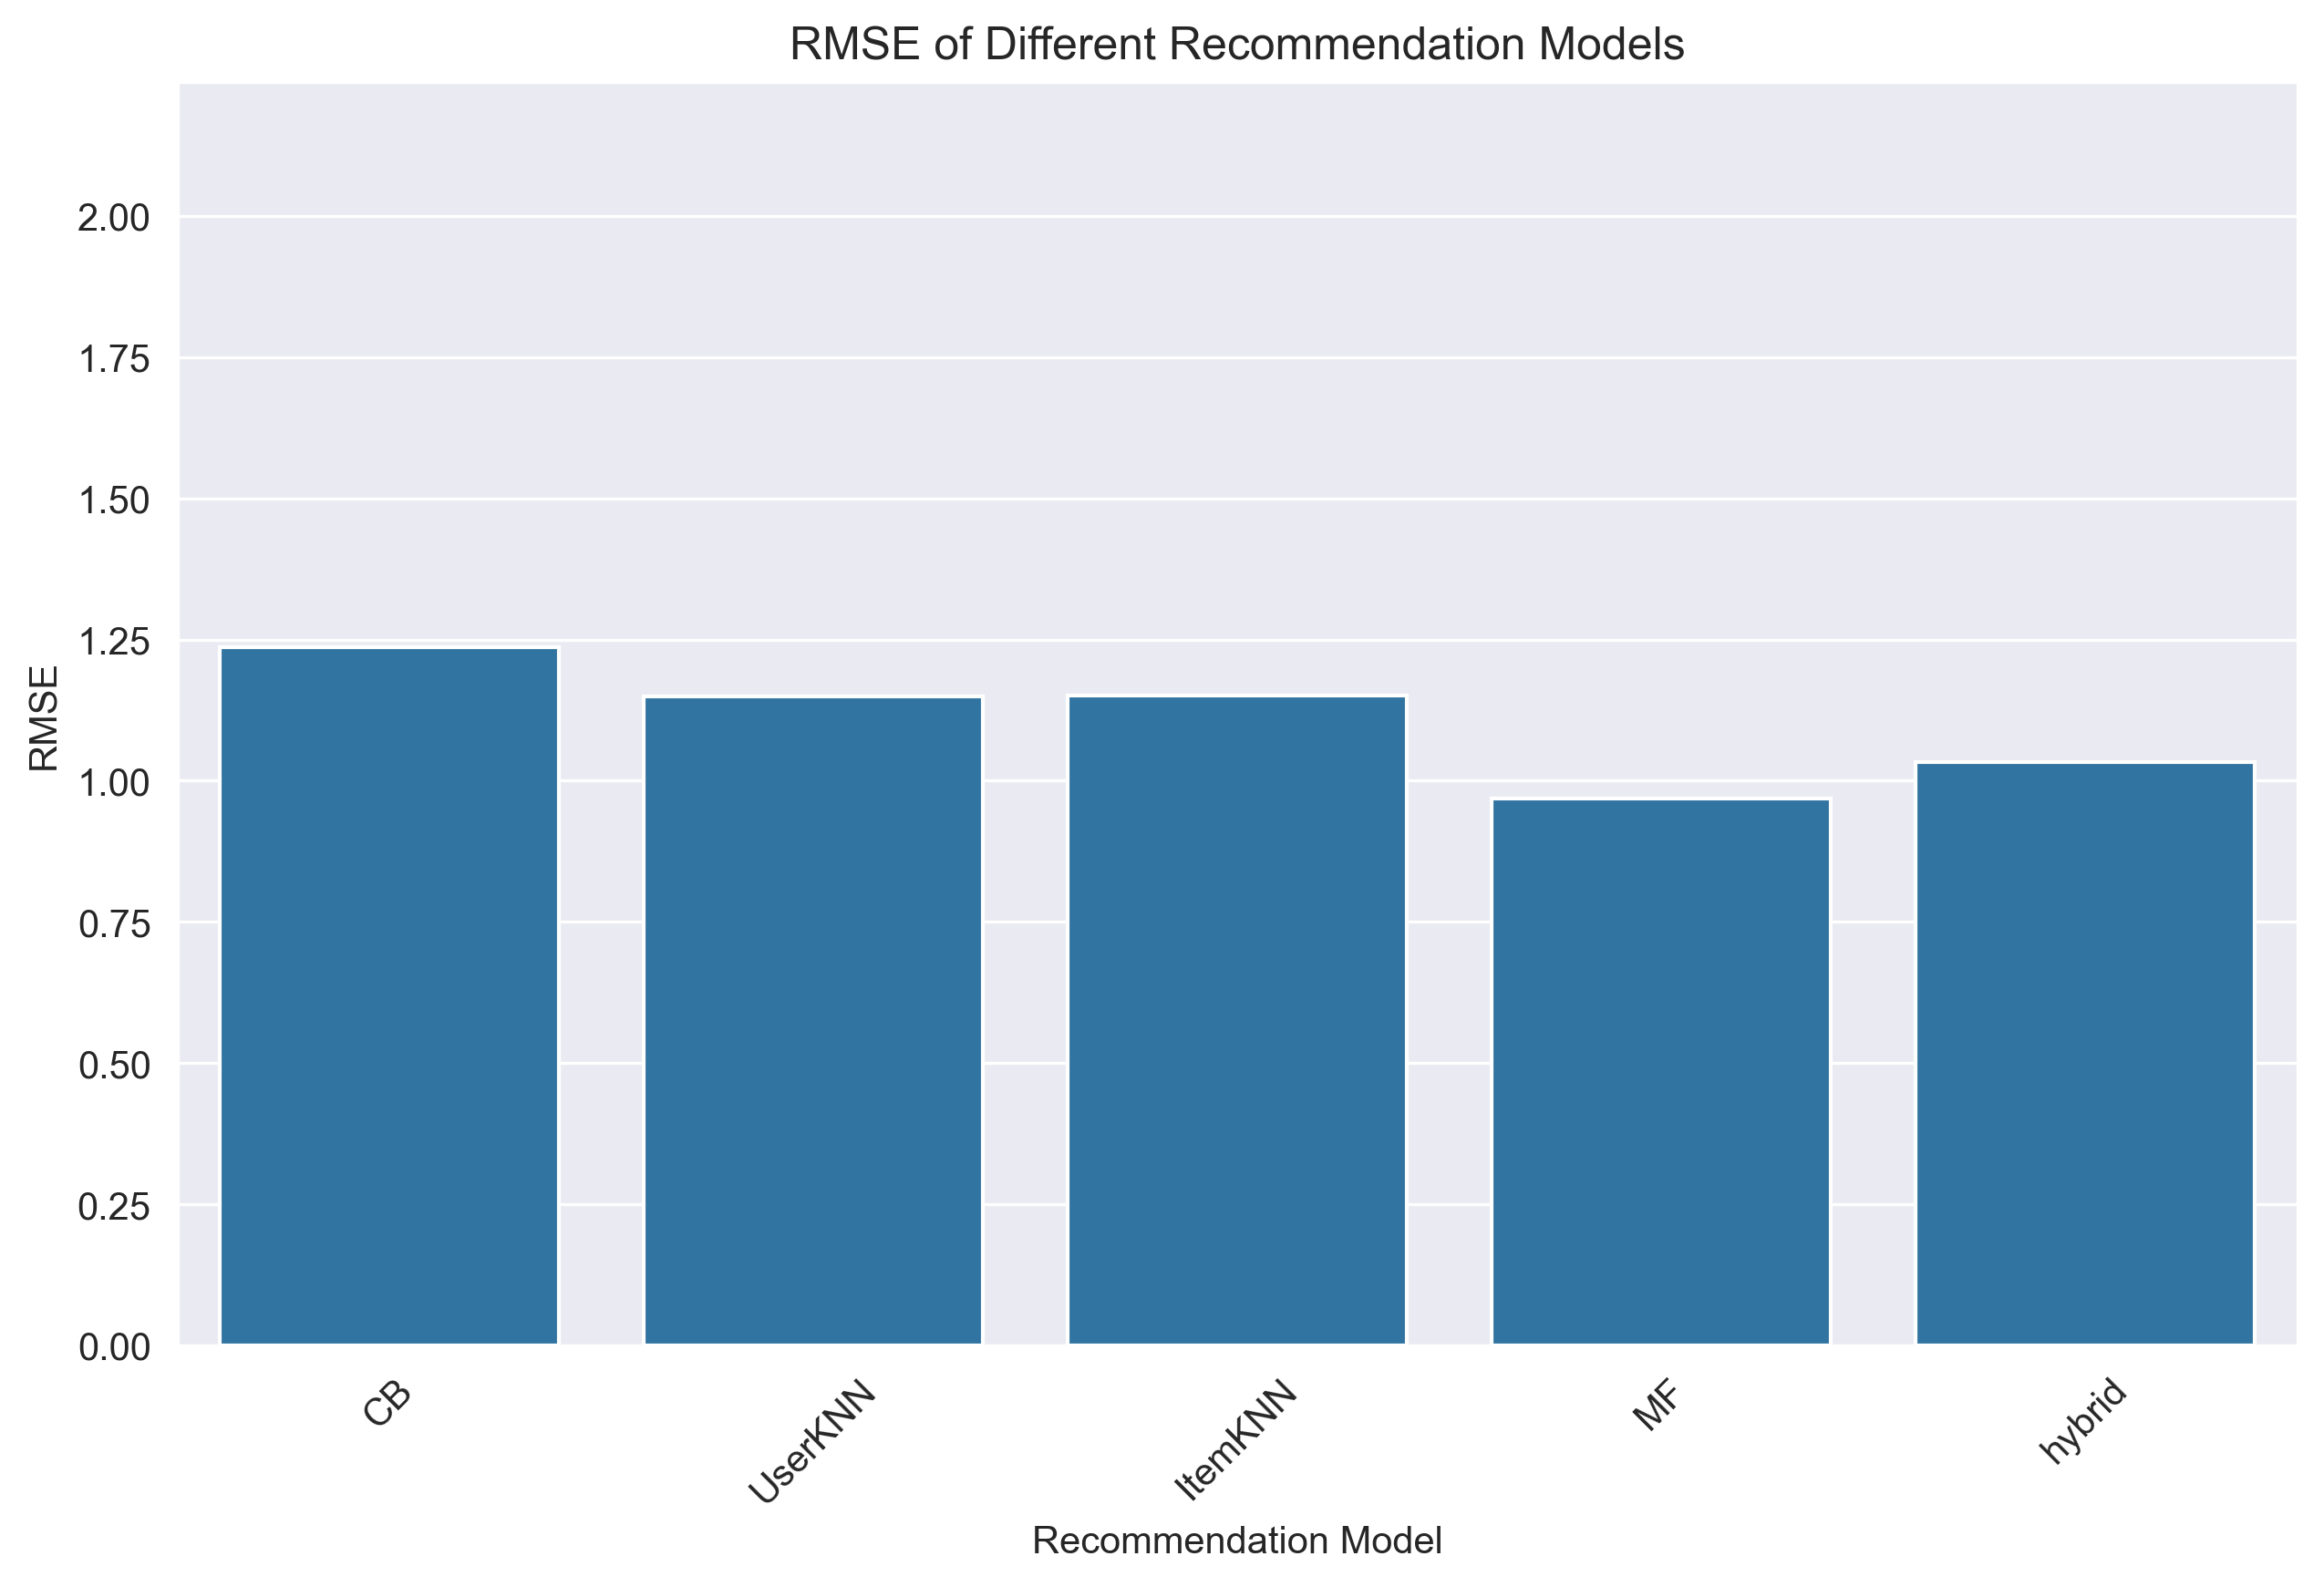

In [58]:
# VISUALISATION
def plot_rating_results(results: dict):
    """
    Plot RMSE results for different recommendation models.

    :param results: dictionary where keys are model names and values are RMSE scores. { model_name: rmse_score }
    """
    models = list(results.keys())
    rmse_scores = list(results.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=rmse_scores)
    plt.title('RMSE of Different Recommendation Models')
    plt.xlabel('Recommendation Model')
    plt.ylabel('RMSE')
    plt.ylim(0, max(rmse_scores) + 1)
    plt.xticks(rotation=45)  # readability
    plt.show()

plot_rating_results(res_dict)

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #004085;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <b>Model Comparison Based on RMSE</b><br><br>
    In terms of RMSE, <b>Matrix Factorization (MF)</b> achieves the lowest possible error. This is not surprising, considering its latent-factor representation and the optimal optimization procedure.<br><br>
    There is no substantial difference between <b>UserKNN</b> and <b>ItemKNN</b> in RMSE performance. The <b>Content-Based Recommender</b> also performs reasonably well, despite not being fine-tuned to the dataset, demonstrating the robustness of embedding-based approaches.<br><br>
    Overall, MF dominates in accuracy due to its ability to capture latent relationships, while neighborhood and content-based methods provide complementary insights.
</div>


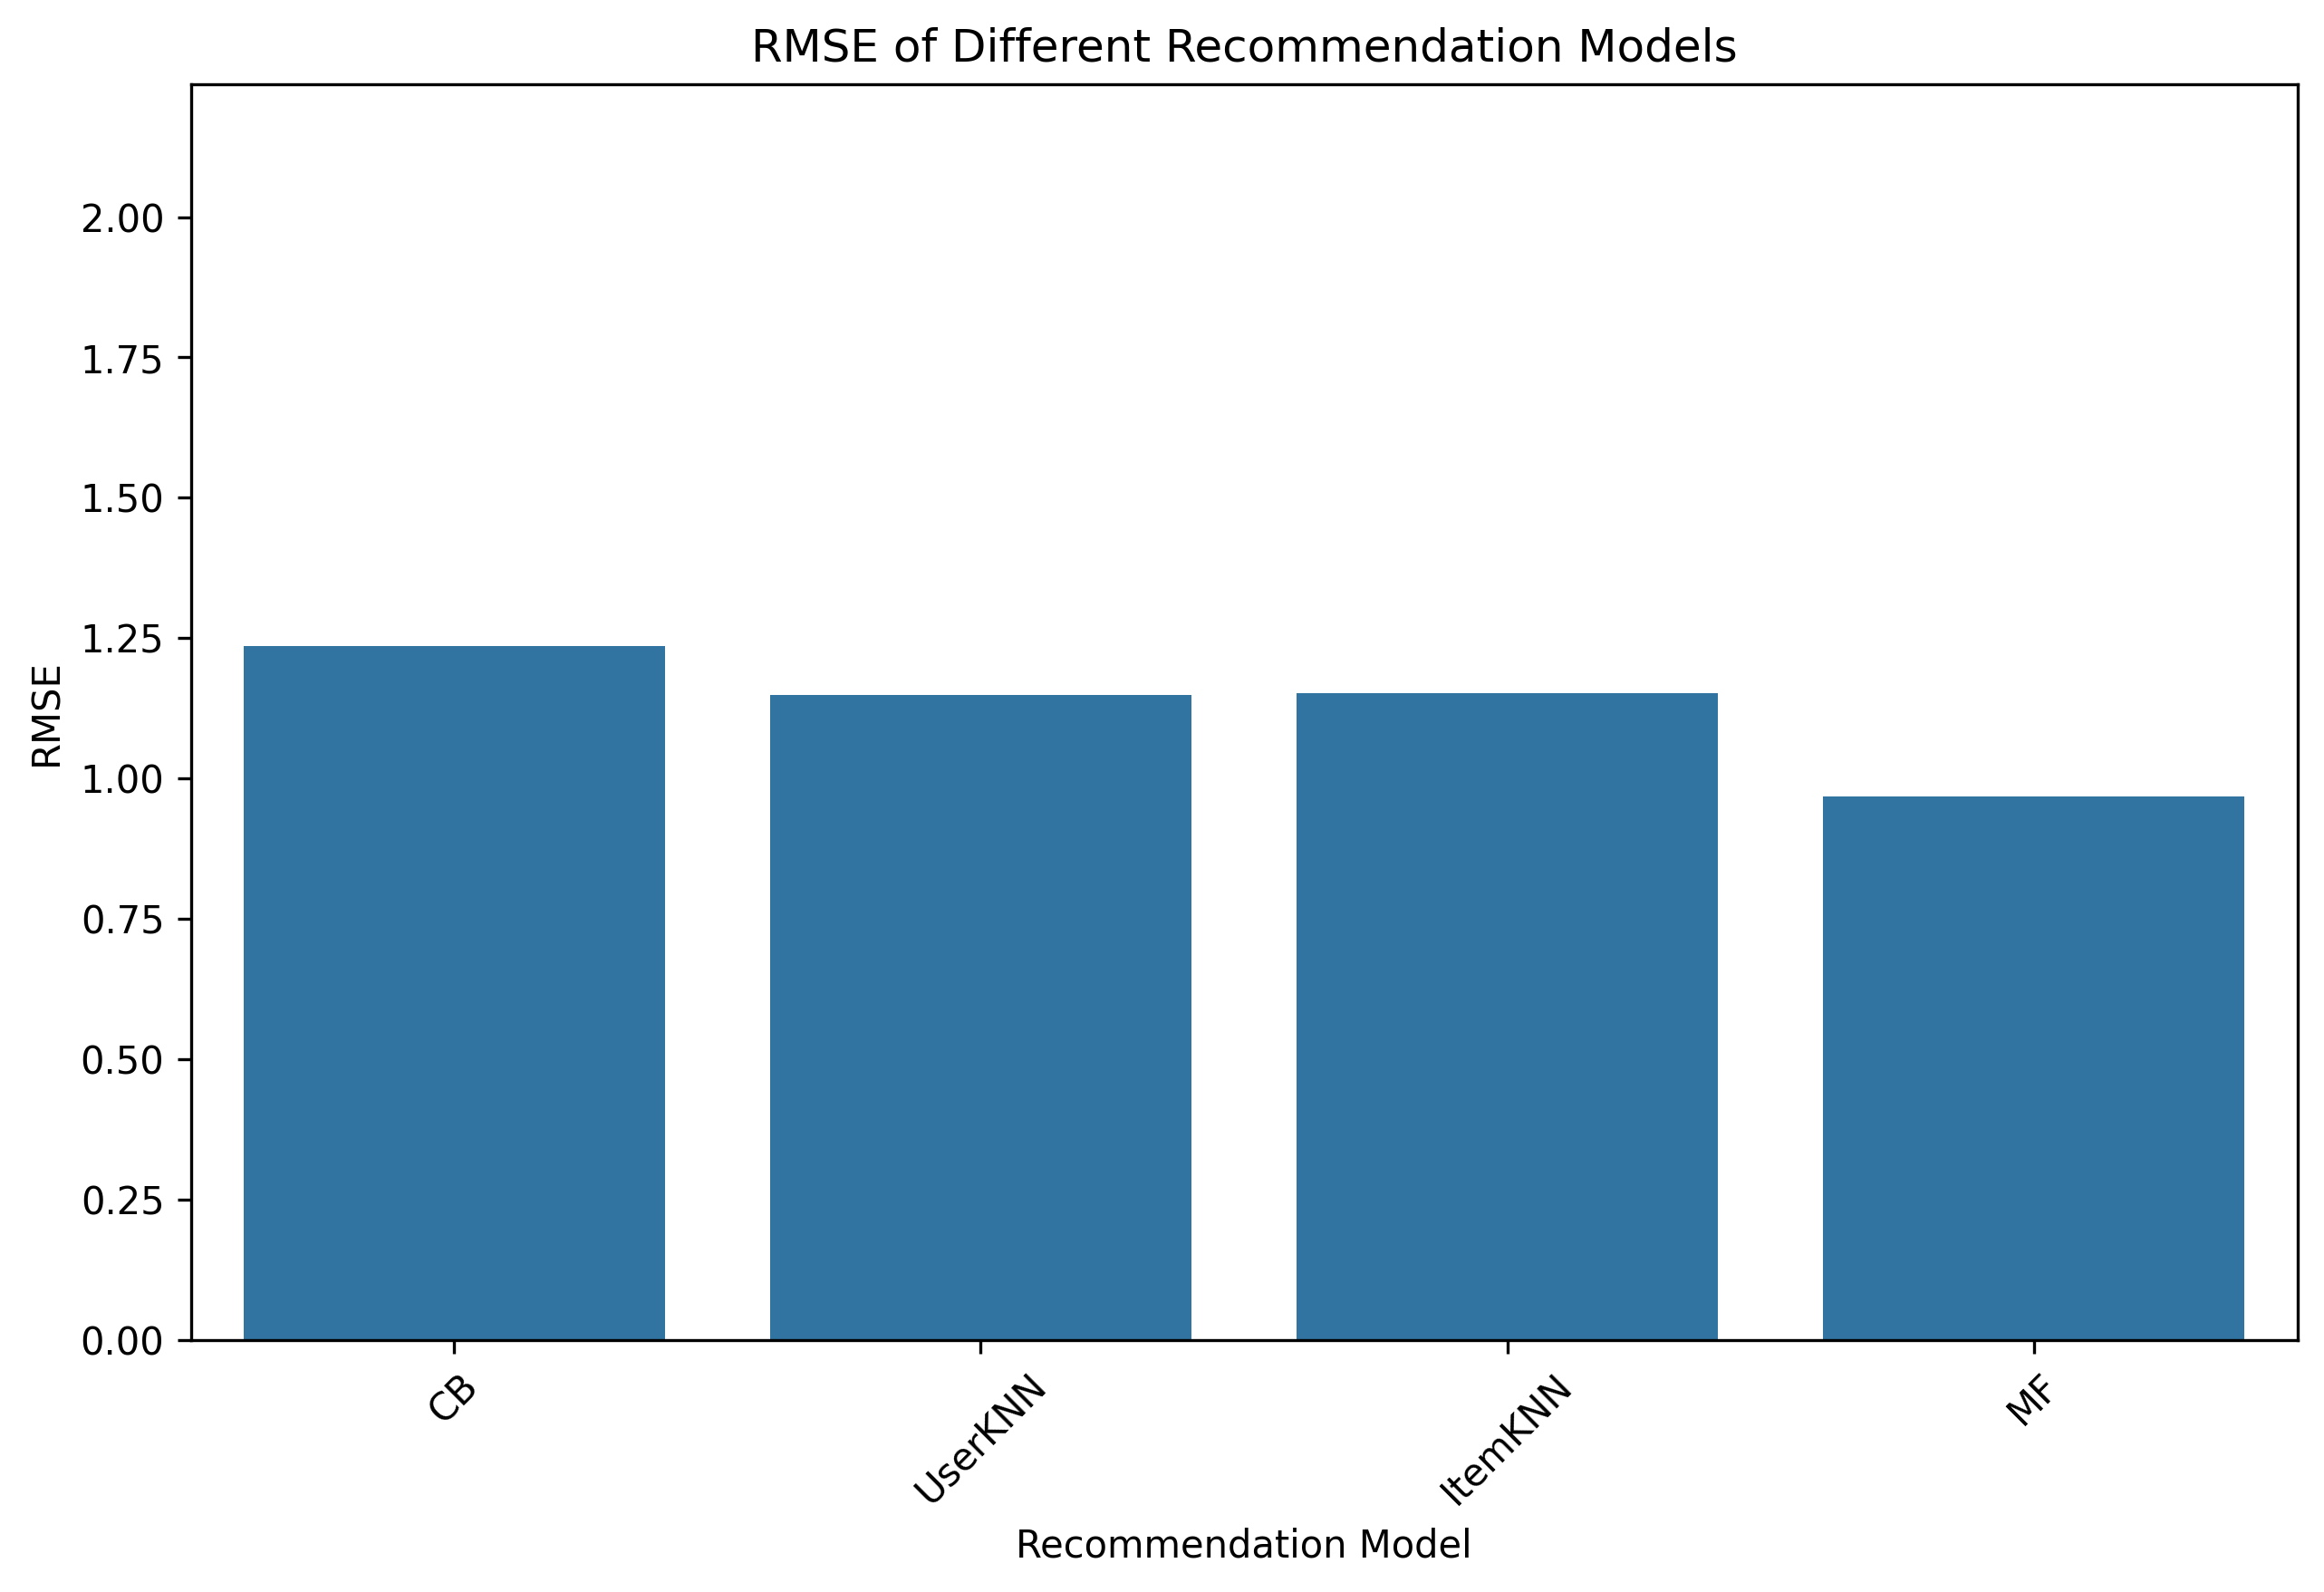

### Ranking task

In [ ]:
for recommender in ranking_recommenders:
    recommender.calculate_ranking_predictions_test_data(test_data, max_k)

In [60]:
# Loading ranking data in
max_k = 10

ranking_prediction_filepaths = { # filepaths to the saved predictions from different models
    'CB': 'model_checkpoints/test/content_based_recommender/rankings/',
    'UserKNN': 'model_checkpoints/test/user_knn/rankings/',
    'ItemKNN': 'model_checkpoints/test/item_knn/rankings/',
    'MF': 'model_checkpoints/test/matrix_factorization/rankings/',
    'BPR': 'model_checkpoints/test/bayesian_probabilistic_ranking/rankings/',
    'hybrid': 'model_checkpoints/test/hybrid_recommender/rankings/'
}

def load_model_ranking_predictions(folder_path: str) -> dict:
    """
    Load ranking predictions from a CSV file for all users.

    :param folder_path: path to the folder containing the rankings and mapping file
    :return: dictionary where keys are user IDs and values are ordered pd.Series with index=item_id and values=predicted_score
    """
    mapping_file = json.loads(open(os.path.join(folder_path, 'user_ranking_file_map.json'), 'r').read())
    user_dict = {}

    for user_id, file in mapping_file.items():
        predictions = pd.read_csv(file)
        p = predictions.set_index('item_id')['predicted_score']
        user_dict[int(user_id)] = p

    return user_dict

def load_all_ranking_predictions(filepaths: dict) -> dict:
    """
    Load ranking predictions from multiple CSV files.
    :param filepaths: dictionary where keys are model names and values are folder paths
    :return: ditionary where keys are model names and values are dictionaries { user_id: pd.Series with ranking predictions }
    """
    all_predictions = {}
    for i, d in filepaths.items():
        all_predictions[i] = load_model_ranking_predictions(d)
    return all_predictions

ranking_predictions = load_all_ranking_predictions(ranking_prediction_filepaths)

In [63]:
# Evaluation ranking task

def ndcg(ground_truth: list, rec_list: list, k = 10) -> float:
    """
    Calculate Normalized Discounted Cumulative Gain (NDCG) for a single user.
    :param ground_truth: list of relevant item ids
    :param rec_list: ranked list of recommended item ids
    :param k: cut off for NDCG calculation
    :return:
    """
    if k > len(rec_list):
        k = len(rec_list)
    dcg = 0.0
    for i in range(k):
        numerator = 1 if rec_list[i] in ground_truth else 0
        denominator = np.log2(i + 2)
        dcg += numerator / denominator
    ideal_len = min(k, len(ground_truth))
    if ideal_len == 0:
        return 0.0
    else:
        IDCG = sum(1.0 / np.log2(i + 2) for i in range(ideal_len))
        return dcg / IDCG


def evaluate_ranking(ground_truth: list[pd.Series], rec_list: list[pd.Series], k=10) -> tuple[
    floating[Any], floating[Any], floating[Any], np.ndarray, np.ndarray, np.ndarray]:
    """
    Calculate Precision, Recall, and NDCG for ranking task.

    Assume that items in rec_list are relevant (rel = 1) and items not in rec_list are non-relevant (rel = 0).

    :param ground_truth: lists of pd.Series of item ids that are relevant
    :param rec_list: list of pd.Series of recommended top-k item ids - index=item_ids, values=rating
    :param k: cut-off for ndcg (may change to be for P and R as well)
    :return:
    """
    # Compute Precision & Recall
    gt_items = [set(gt.index.values) for gt in ground_truth]
    rec_items = [set(rl.index.values) for rl in rec_list]
    len_intersections = np.array([len(set(gt).intersection(rl)) for rl, gt in zip(rec_items, gt_items)])
    len_rls = np.array([len(rl) for rl in rec_items])
    len_gts = np.array([len(gt) for gt in gt_items])

    ps = 100 * len_intersections / len_rls
    rs = 100 * len_intersections / len_gts

    p = np.nanmean(ps)  # precision
    r = np.nanmean(rs)  # recall

    # Compute NDCG
    ndcgs = [ndcg(list(gt), list(rl), k) for rl, gt in zip(rec_items, gt_items)]
    ndcg_mean = np.nanmean(ndcgs)

    # print(f'  Precision: {p:.2f}%, Recall: {r:.2f}%, NDCG: {ndcg_mean:.4f}')

    return p, r, ndcg_mean, ps, rs, np.array(ndcgs)

def evaluate_ranking_all(prediction_dict: dict, test_data: dict, k=10, save_path: str = None) -> Tuple[dict, dict]:
    """
    Evaluate a baseline or model against the test data for ranking task - Precision, Recall, NDCG for all models.
    :param save_path: full file path to save results to, if any
    :param prediction_dict: { model : { user_id: pd.Series with ranking predictions } }
    :param test_data: { user_id: pd.Series with ground truth ratings }
    :param k:
    :return:
    """
    results = {}
    user_results = {}
    users = test_data.keys()
    print('Evaluating ranking predictions for all models...')

    for model_name, user_predictions in tqdm(prediction_dict.items()):
        ground_truth = []
        rec_list = []
        u_include = [u for u in users if u in user_predictions]
        for user in u_include:
            ground_truth.append(test_data[user])
            rec_list.append(user_predictions[user].nlargest(k))
        precision, recall, ndcg_mean, ps, rs, ndcgs = evaluate_ranking(ground_truth, rec_list, k)
        user_dict = {}
        for i, u in enumerate(u_include):
            user_dict[u] = {
                'precision': ps[i],
                'recall': rs[i],
                'ndcg': ndcgs[i]
            }
        user_results[model_name] = user_dict
        results[model_name] = [precision, recall, ndcg_mean]
        print(f'- {model_name}: Precision = {precision:.2f}%, Recall = {recall:.2f}%, NDCG = {ndcg_mean:.4f}')

    if save_path:
        df = pd.DataFrame.from_dict(results, orient='index', columns=['precision', 'recall', 'ndcg']).reset_index(names='model')
        df.to_csv(save_path, index=False)
    return results, user_results

### Evaluation of Ranking Recommenders

In [64]:
# RUN and AGGREGATE results
results = evaluate_ranking_all(ranking_predictions, user_rankings_test, k=3)
accuracy_metrics_df = pd.DataFrame.from_dict(results, orient='index', columns=['precision', 'recall', 'ndcg']).reset_index().rename(columns={'index': 'model'}).set_index('model')
accuracy_metrics_df['rmse'] = accuracy_metrics_df.index.map(res_dict)
display(accuracy_metrics_df)

Evaluating ranking predictions for all models...


 33%|███▎      | 2/6 [00:00<00:00, 17.86it/s]

- CB: Precision = 0.87%, Recall = 0.26%, NDCG = 0.0067
- UserKNN: Precision = 0.80%, Recall = 0.25%, NDCG = 0.0068
- ItemKNN: Precision = 1.53%, Recall = 0.46%, NDCG = 0.0153
- MF: Precision = 2.98%, Recall = 0.89%, NDCG = 0.0263


100%|██████████| 6/6 [00:00<00:00, 18.12it/s]

- BPR: Precision = 0.44%, Recall = 0.13%, NDCG = 0.0045
- hybrid: Precision = 3.92%, Recall = 1.18%, NDCG = 0.0400


100%|██████████| 6/6 [00:00<00:00, 18.05it/s]


,precision,recall,ndcg,rmse
model,,,,
CB,0.871460,0.261438,0.006670,1.236633
UserKNN,0.798838,0.248988,0.006828,1.149143
ItemKNN,1.525054,0.457516,0.015251,1.151532
MF,2.977487,0.893246,0.026253,0.967859
BPR,0.435730,0.130719,0.004491,NaN
hybrid,3.921569,1.181917,0.039995,1.033569


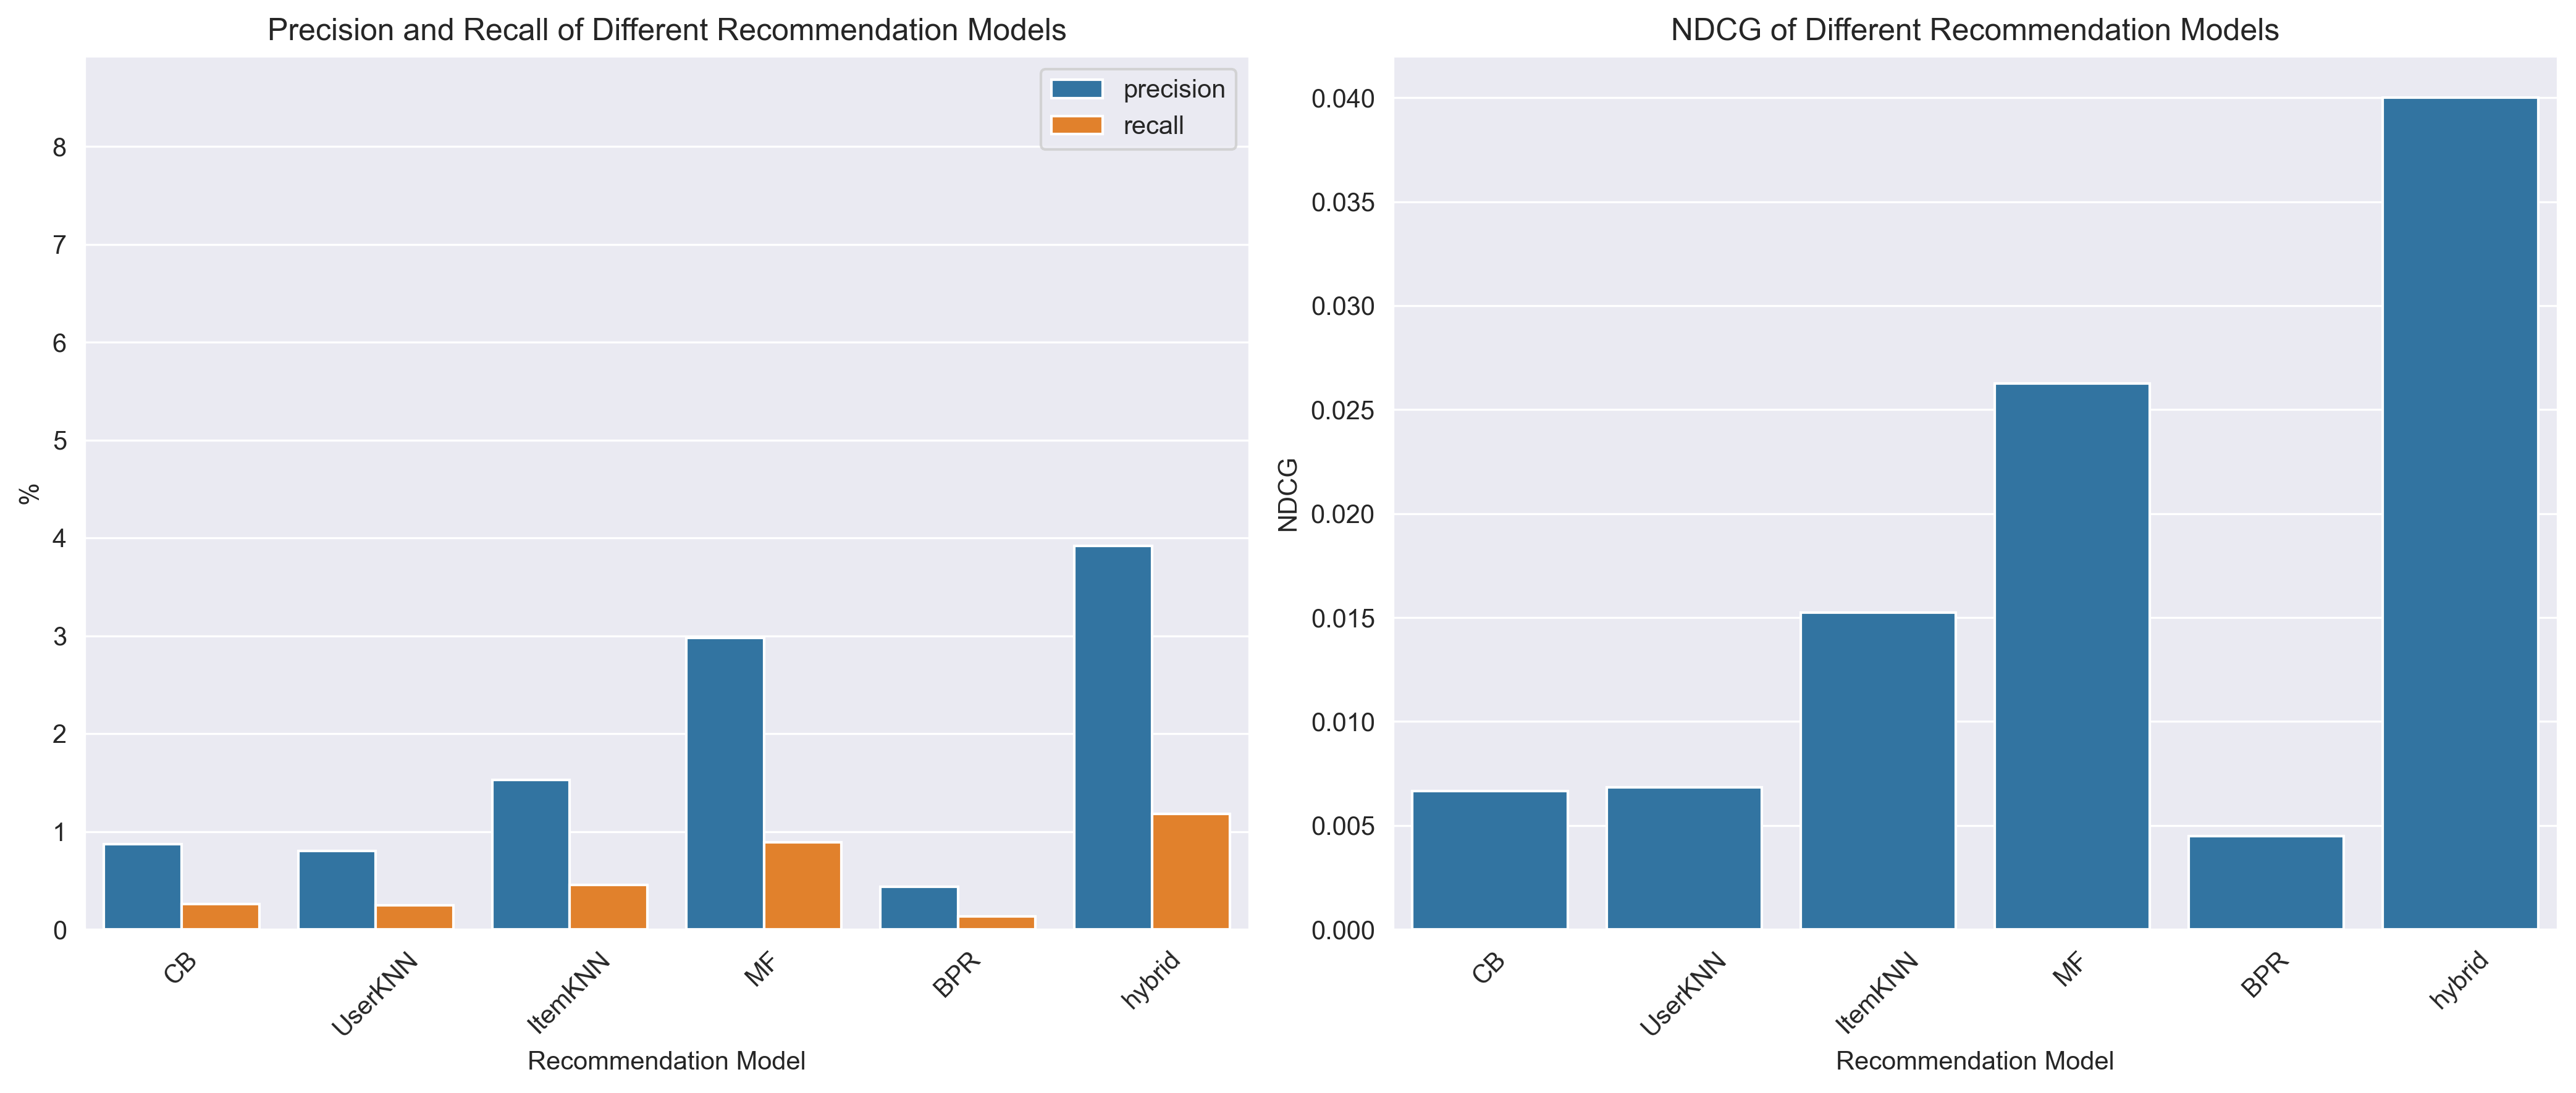

In [65]:
# VISUALISATION

def visualise_ranking_results(results: dict, tight: bool = False):
    """
    Plot Precision and Recall, and NDCG results for different recommendation models.

    :param results: dictionary where keys are model names and values are lists of [precision, recall, ndcg]
    :param tight: whether to display the two plots (Precision & Recall, NDCG) side by side
    """
    df = pd.DataFrame.from_dict(results, orient='index', columns=['precision', 'recall', 'ndcg']).reset_index().rename(columns={'index': 'model'})
    df_melt = df.melt(id_vars='model', value_vars=['precision', 'recall'], var_name='metric', value_name='value')

    if not tight:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_melt, x='model', y='value', hue='metric', palette=['tab:blue', 'tab:orange'], errorbar=None)
        plt.title('Precision and Recall of Different Recommendation Models')
        plt.xlabel('Recommendation Model')
        plt.ylabel('%')
        plt.xticks(rotation=45)  # readability
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x='model', y='ndcg', errorbar=None)
        plt.title('NDCG of Different Recommendation Models')
        plt.xlabel('Recommendation Model')
        plt.ylabel('NDCG')
        plt.xticks(rotation=45)

    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        # Left - grouped Precision & Recall
        sns.barplot(data=df_melt, x='model', y='value', hue='metric',
                    palette=['tab:blue', 'tab:orange'], errorbar=None, ax=axes[0])
        axes[0].set_title('Precision and Recall of Different Recommendation Models')
        axes[0].set_xlabel('Recommendation Model')
        axes[0].set_ylabel('%')
        axes[0].set_ylim(0, df_melt['value'].max() + 5)
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].legend(title=None)

        # Right - NDCG
        sns.barplot(data=df, x='model', y='ndcg', errorbar=None, ax=axes[1])
        axes[1].set_title('NDCG of Different Recommendation Models')
        axes[1].set_xlabel('Recommendation Model')
        axes[1].set_ylabel('NDCG')
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
    plt.show()

visualise_ranking_results(results, tight=True) # TODO - move to task 3/4/5

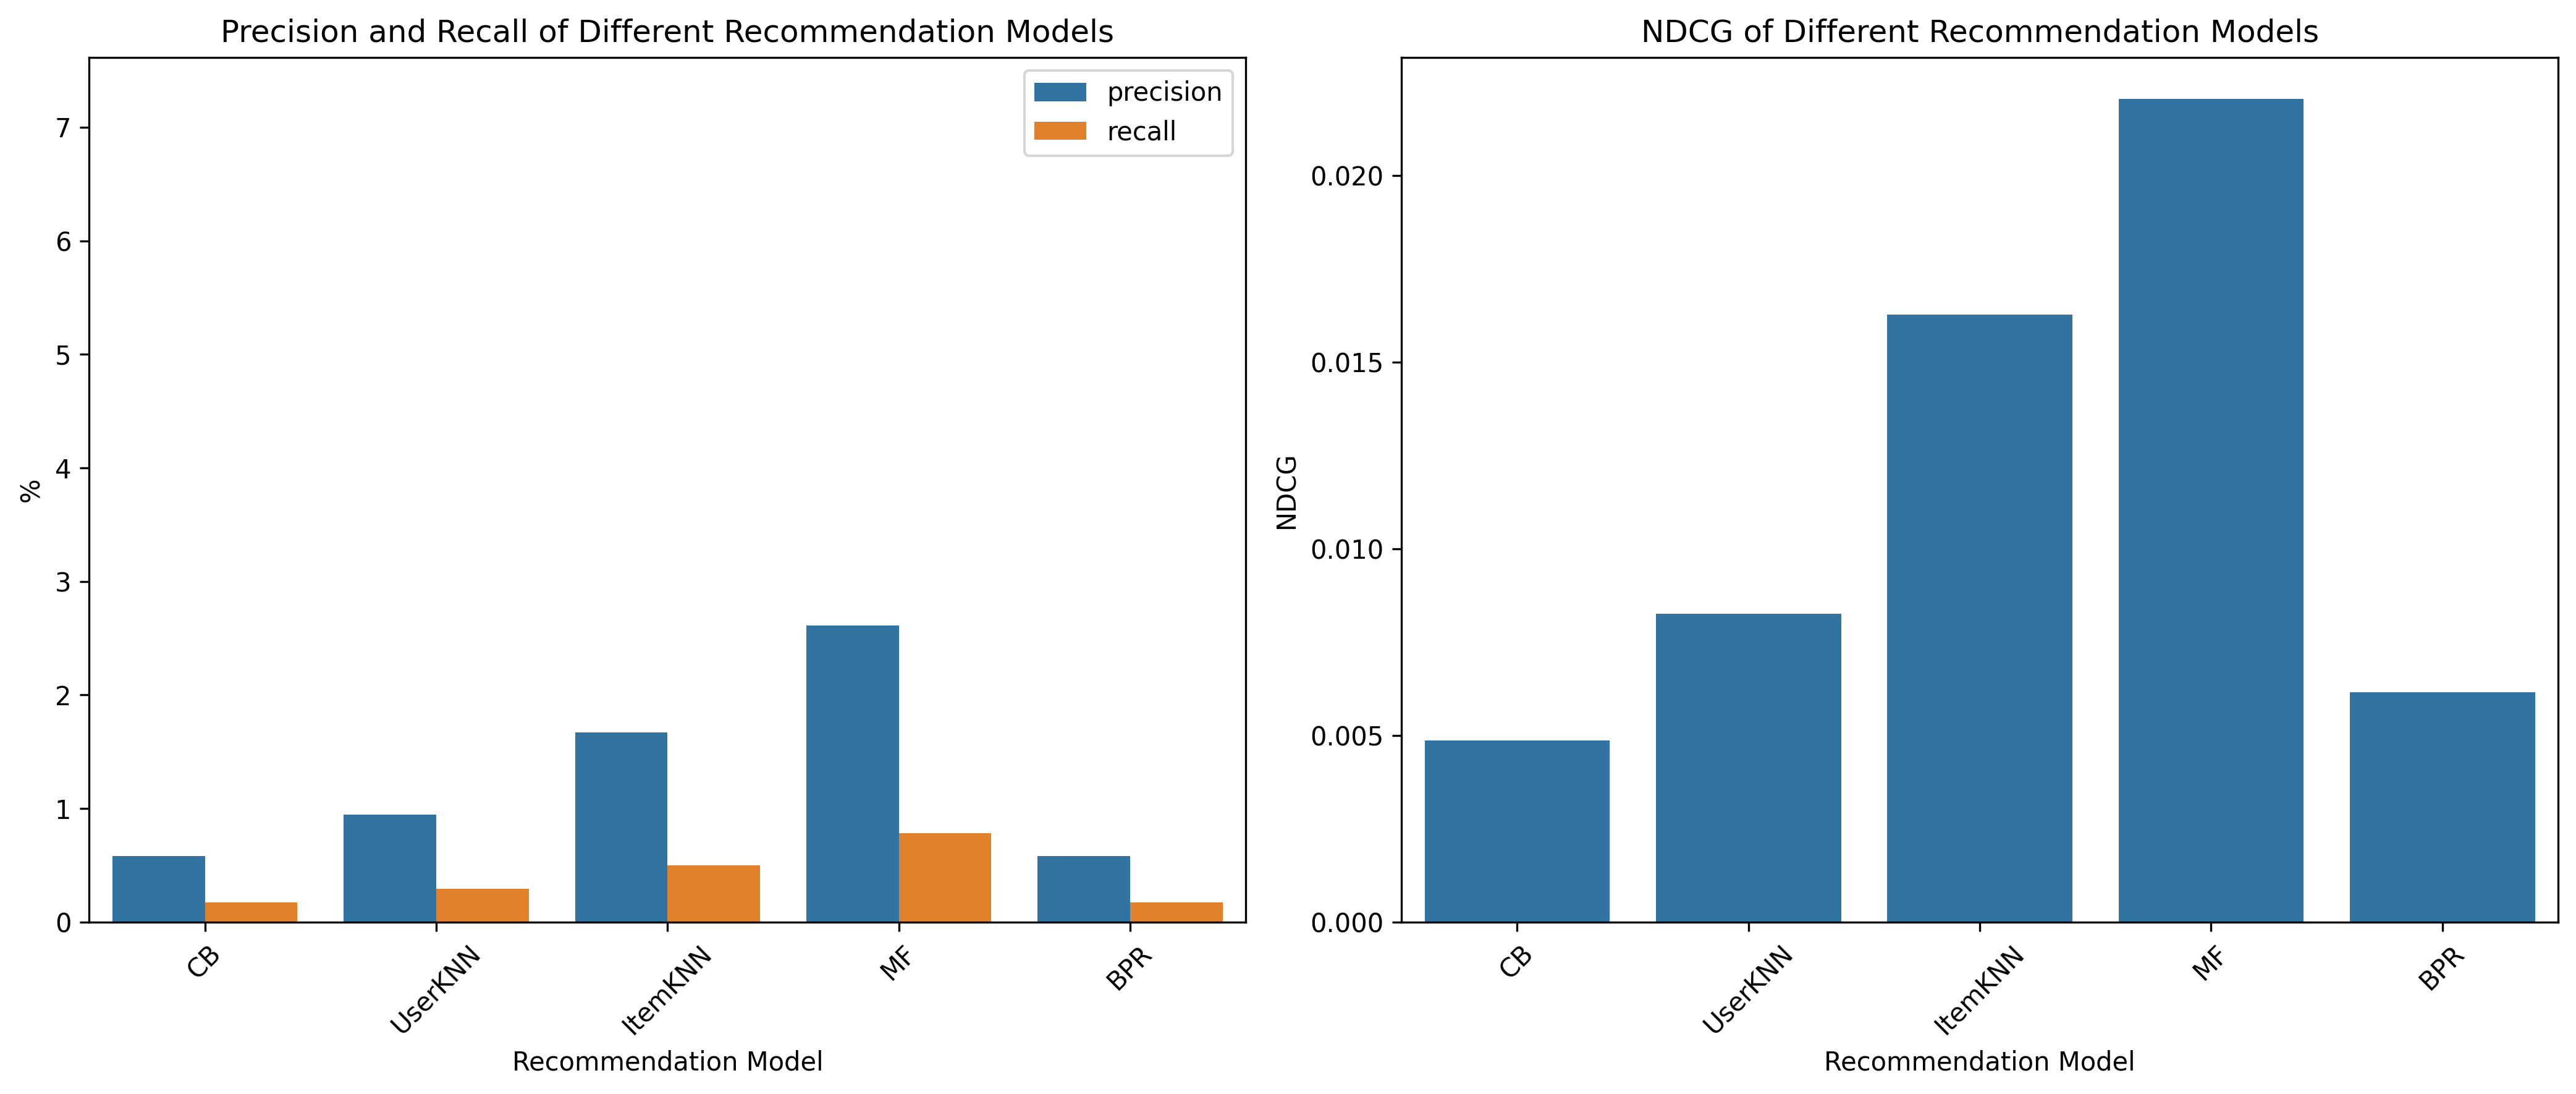

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #004085;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <b>Model Comparison Based on Ranking Metrics</b><br><br>
    <b>Matrix Factorization (MF)</b> dominates all other models in terms of <b>precision</b>, <b>recall</b>, and <b>NDCG</b>. As a fundamental ranking algorithm with access to its many latent factors, it proves to be a very strong choice.<br><br>
    The low performance of <b>BPR</b> is somewhat surprising, given its ranking-focused design. However, BPR optimizes pairwise preferences and may not fully capture transitive relationships — an area where <b>UserKNN</b> and <b>ItemKNN</b> perform better.<br><br>
    <b>Content-Based (CB)</b> performs the worst, limited to the items the user has interacted with and lacking any collaborative signals. Its recommendations are therefore narrower and less accurate in ranking metrics.<br><br>
    Overall, MF stands out as the strongest model for ranking tasks, while KNN variants provide moderate performance, and CB serves as a complementary, but limited, approach.
</div>


# Task 3) Implement baselines for both rating prediction and ranking tasks, and perform experiments with those baselines

## Code

<h3>Rating Baselines</h3>

In [ ]:
class AverageRater(AbstractRecommender):
    train_data: pd.DataFrame

    def __init__(self, train_data: pd.DataFrame):
        self.train_data = train_data
   
    def train(self, train_data: pd.DataFrame) -> None:
        pass 

    def get_name(self) -> str:
        return "Average Item Rating Recommender"

    def predict_score(self, user_id: int, item_id: int) -> float:
        # Calculate the mean score for an item
        return np.mean(self.train_data.loc[(self.train_data['item_id'] == item_id), 'rating'])

average_rater = AverageRater(train_data_small)
average_rater.predict_score(1, 2)

In [ ]:
average_rater.calculate_rating_predictions_test_data(test_data)

<h3>Ranking Baselines</h3>

In [ ]:
class RandomRanker(AbstractRecommender):
    unseen_items: Dict[int, List[int]] # For each user keep track of unseen items

    def __init__(self, train_data: pd.DataFrame):
        self.unseen_items = {}
        self.train(train_data)

    def get_name(self) -> str:
        return "Random Ranker"
    
    def train(self, train_data: pd.DataFrame) -> None:
        # Find unseen items for each user
        user_ids = train_data['user_id'].unique()
        item_ids = train_data['item_id'].unique()
        for user_id in user_ids:
            seen_items = train_data.loc[(train_data['user_id'] == user_id), 'item_id'].unique()
            unseen_items_for_user = [item_id for item_id in item_ids if item_id not in seen_items]
            self.unseen_items[user_id] = unseen_items_for_user

    def predict_score(self, user_id: int, item_id: int) -> float:
        return np.random.uniform(0, 5)
    
    def calculate_all_rankings(self, k: int, train_data: pd.DataFrame) -> None:
        self.rankings = {}
        for user_id in train_data['user_id'].unique():
            unseen_items = self.unseen_items[user_id]
            items_with_scores = [(item_id, self.predict_score(user_id, item_id)) for item_id in unseen_items]
            sorted_items = sorted(items_with_scores, key= lambda x : x[1], reverse=True)[:k]
            self.rankings[user_id] = sorted_items

random_ranker = RandomRanker(train_data_small)
random_ranker.calculate_all_rankings(5, train_data_small)
random_ranker.get_ranking(1, 5)

In [ ]:
random_ranker.calculate_ranking_predictions_test_data(test_data, 10)

In [ ]:
class PopularRanker(AbstractRecommender):
    unseen_items: Dict[int, List[int]] # For each user keep track of unseen items
    popularities: Dict[int, int] # For each item keep track of amount of ratings 

    def __init__(self, train_data: pd.DataFrame):
        self.unseen_items = {}
        self.popularities = {}
        self.train(train_data)

    def get_name(self) -> str:
        return "Popularity Based Ranker"

    def train(self, train_data: pd.DataFrame) -> None:
        # Find unseen items for each user
        user_ids = train_data['user_id'].unique()
        item_ids = train_data['item_id'].unique()
        for user_id in user_ids:
            seen_items = train_data.loc[(train_data['user_id'] == user_id), 'item_id'].unique()
            unseen_items_for_user = [item_id for item_id in item_ids if item_id not in seen_items]
            self.unseen_items[user_id] = unseen_items_for_user
        
        # Find popularity of each item (amount of ratings)
        for item_id in item_ids:
            user_ratings = train_data.loc[
                (train_data['item_id'] == item_id),
                'user_id'
            ].unique()
            self.popularities[item_id] = len(user_ratings)

    def predict_score(self, user_id: int, item_id: int) -> float:
        raise ValueError("Predicting score not implemented for ranker")

    def predict_ranking(self, user_id: int, k: int) -> List[tuple[int, float]]:
        # Recommend most popular items that are not yet interacted by the target user. Most popular items are the ones that are rated by majority of users in the training data.
        unseen_items = self.unseen_items[user_id]
        def normalize_popularity(popularity: int) -> float:
            return popularity / max(self.popularities.values()) * 5.0  # Scale to rating range (1-5)
        items_with_popularity = [(item_id, normalize_popularity(self.popularities[item_id])) for item_id in unseen_items]
        sorted_items = sorted(items_with_popularity, key= lambda x : x[1], reverse=True)
        return sorted_items[:k]
    
    def calculate_all_rankings(self, k: int, train_data: pd.DataFrame) -> None:
        self.rankings = {}
        for user_id in train_data['user_id'].unique():
            ranking = self.predict_ranking(user_id, k)
            self.rankings[user_id] = ranking

popular_ranker = PopularRanker(train_data_small)
popular_ranker.calculate_all_rankings(5, train_data_small)
popular_ranker.get_ranking(1, 5)

In [ ]:
popular_ranker.calculate_ranking_predictions_test_data(test_data, 10)

<h3>Mean Hybrid Baseline (Rater/Ranker)</h3>

In [ ]:
class MeanHybridRecommender(AbstractRecommender):
	hybrid_recommender: HybridRecommender

	def __init__(self, train_data: pd.DataFrame, rating_recommenders: List[AbstractRecommender], ranking_recommenders: List[AbstractRecommender], max_k: int, verbose=False, overrride_recommender_checkpoints: bool = False):
		self.hybrid_recommender = HybridRecommender(train_data, rating_recommenders, ranking_recommenders, max_k, verbose, overrride_recommender_checkpoints)
		self.train(train_data)

	def get_name(self) -> str:
		return "Mean Hybrid Recommender"
	
	def train(self, train_data: pd.DataFrame) -> None:
		"""
        This method prepares the model for usage, e.g. computing similarity matrices and training models.

        :param train_data: Dataframe containing training data, relevant keys: user_id, item_id, rating.
        """
		rating_weights: List[float] = np.ones(len(self.hybrid_recommender.rating_recommenders)) / len(self.hybrid_recommender.rating_recommenders)
		self.hybrid_recommender.rating_weights = rating_weights
		
		ranking_weights: List[float] = np.ones(len(self.hybrid_recommender.ranking_recommenders)) / len(self.hybrid_recommender.ranking_recommenders)
		self.hybrid_recommender.ranking_weights = ranking_weights

	def predict_score(self, user_id: int, item_id: int) -> float:
		return self.hybrid_recommender._predict_score_with_weights(user_id, item_id, self.hybrid_recommender.rating_weights)

	def calculate_all_rankings(self, k: int, train_data: pd.DataFrame) -> None:
		tqdm.pandas()
		user_ids = train_data['user_id'].unique()
		self.rankings = {}
		for user_id in tqdm(user_ids):
			ranking = self.hybrid_recommender._predict_ranking_with_weights(user_id, k, self.hybrid_recommender.ranking_weights)
			self.rankings[user_id] = ranking

In [ ]:
percentage = 0.1 #limited due to time constraints
movies_small = movies.iloc[0: int(percentage * len(movies))]
test_data_small = test_data[test_data["item_id"].isin(movies_small["item_id"])]

In [ ]:
meanHybrid = MeanHybridRecommender(train_data, rating_recommenders, ranking_recommenders, 10, verbose=True, overrride_recommender_checkpoints=False)
# meanHybrid.calculate_rating_predictions_test_data(test_data_small)
# meanHybrid.calculate_ranking_predictions_test_data(test_data_small, 10)

## Evaluation - move to T5 to compare everything together?

You should be able to use the evaluation functions defined in Task 2 for evaluating the baselines, even in one big batch! The functions available are (pass is mainly written for my editor):

```python
def evaluate_rating_all(rating_prediction_dict: dict, test_data: pd.DataFrame) -> dict: pass
    # Takes {model_name: pd.DataFrame} with columns=['user_id', 'item_id', 'pred_rating']

def evaluate_ranking_all(prediction_dict: dict, test_data: dict, k=10, save_path: str = None) -> dict: pass
    # Takes { model : { user_id: pd.Series(index=item_id, values=predicted_rating) } }
```

<h3>Rating Baselines</h3>

In [ ]:
baseline_raters_paths = { 
    'AverageRater': 'model_checkpoints/test/average_item_rating_recommender/predictions.csv',
    'CB': 'model_checkpoints/test/content_based_recommender/predictions.csv', # TODO - check
    'UserKNN': 'model_checkpoints/test/user_knn/predictions.csv',
    'ItemKNN': 'model_checkpoints/test/item_knn/predictions.csv',
    'MF': 'model_checkpoints/test/matrix_factorization/predictions.csv',
    # 'MeanHybrid': 'model_checkpoints/test/mean_hybrid_recommender/predictions.csv',
}
baseline_rankings = load_all_rating_predictions(baseline_raters_paths)

In [ ]:
res_dict_baselines = evaluate_rating_all(baseline_rankings, test_data_small)
plot_rating_results(res_dict_baselines)

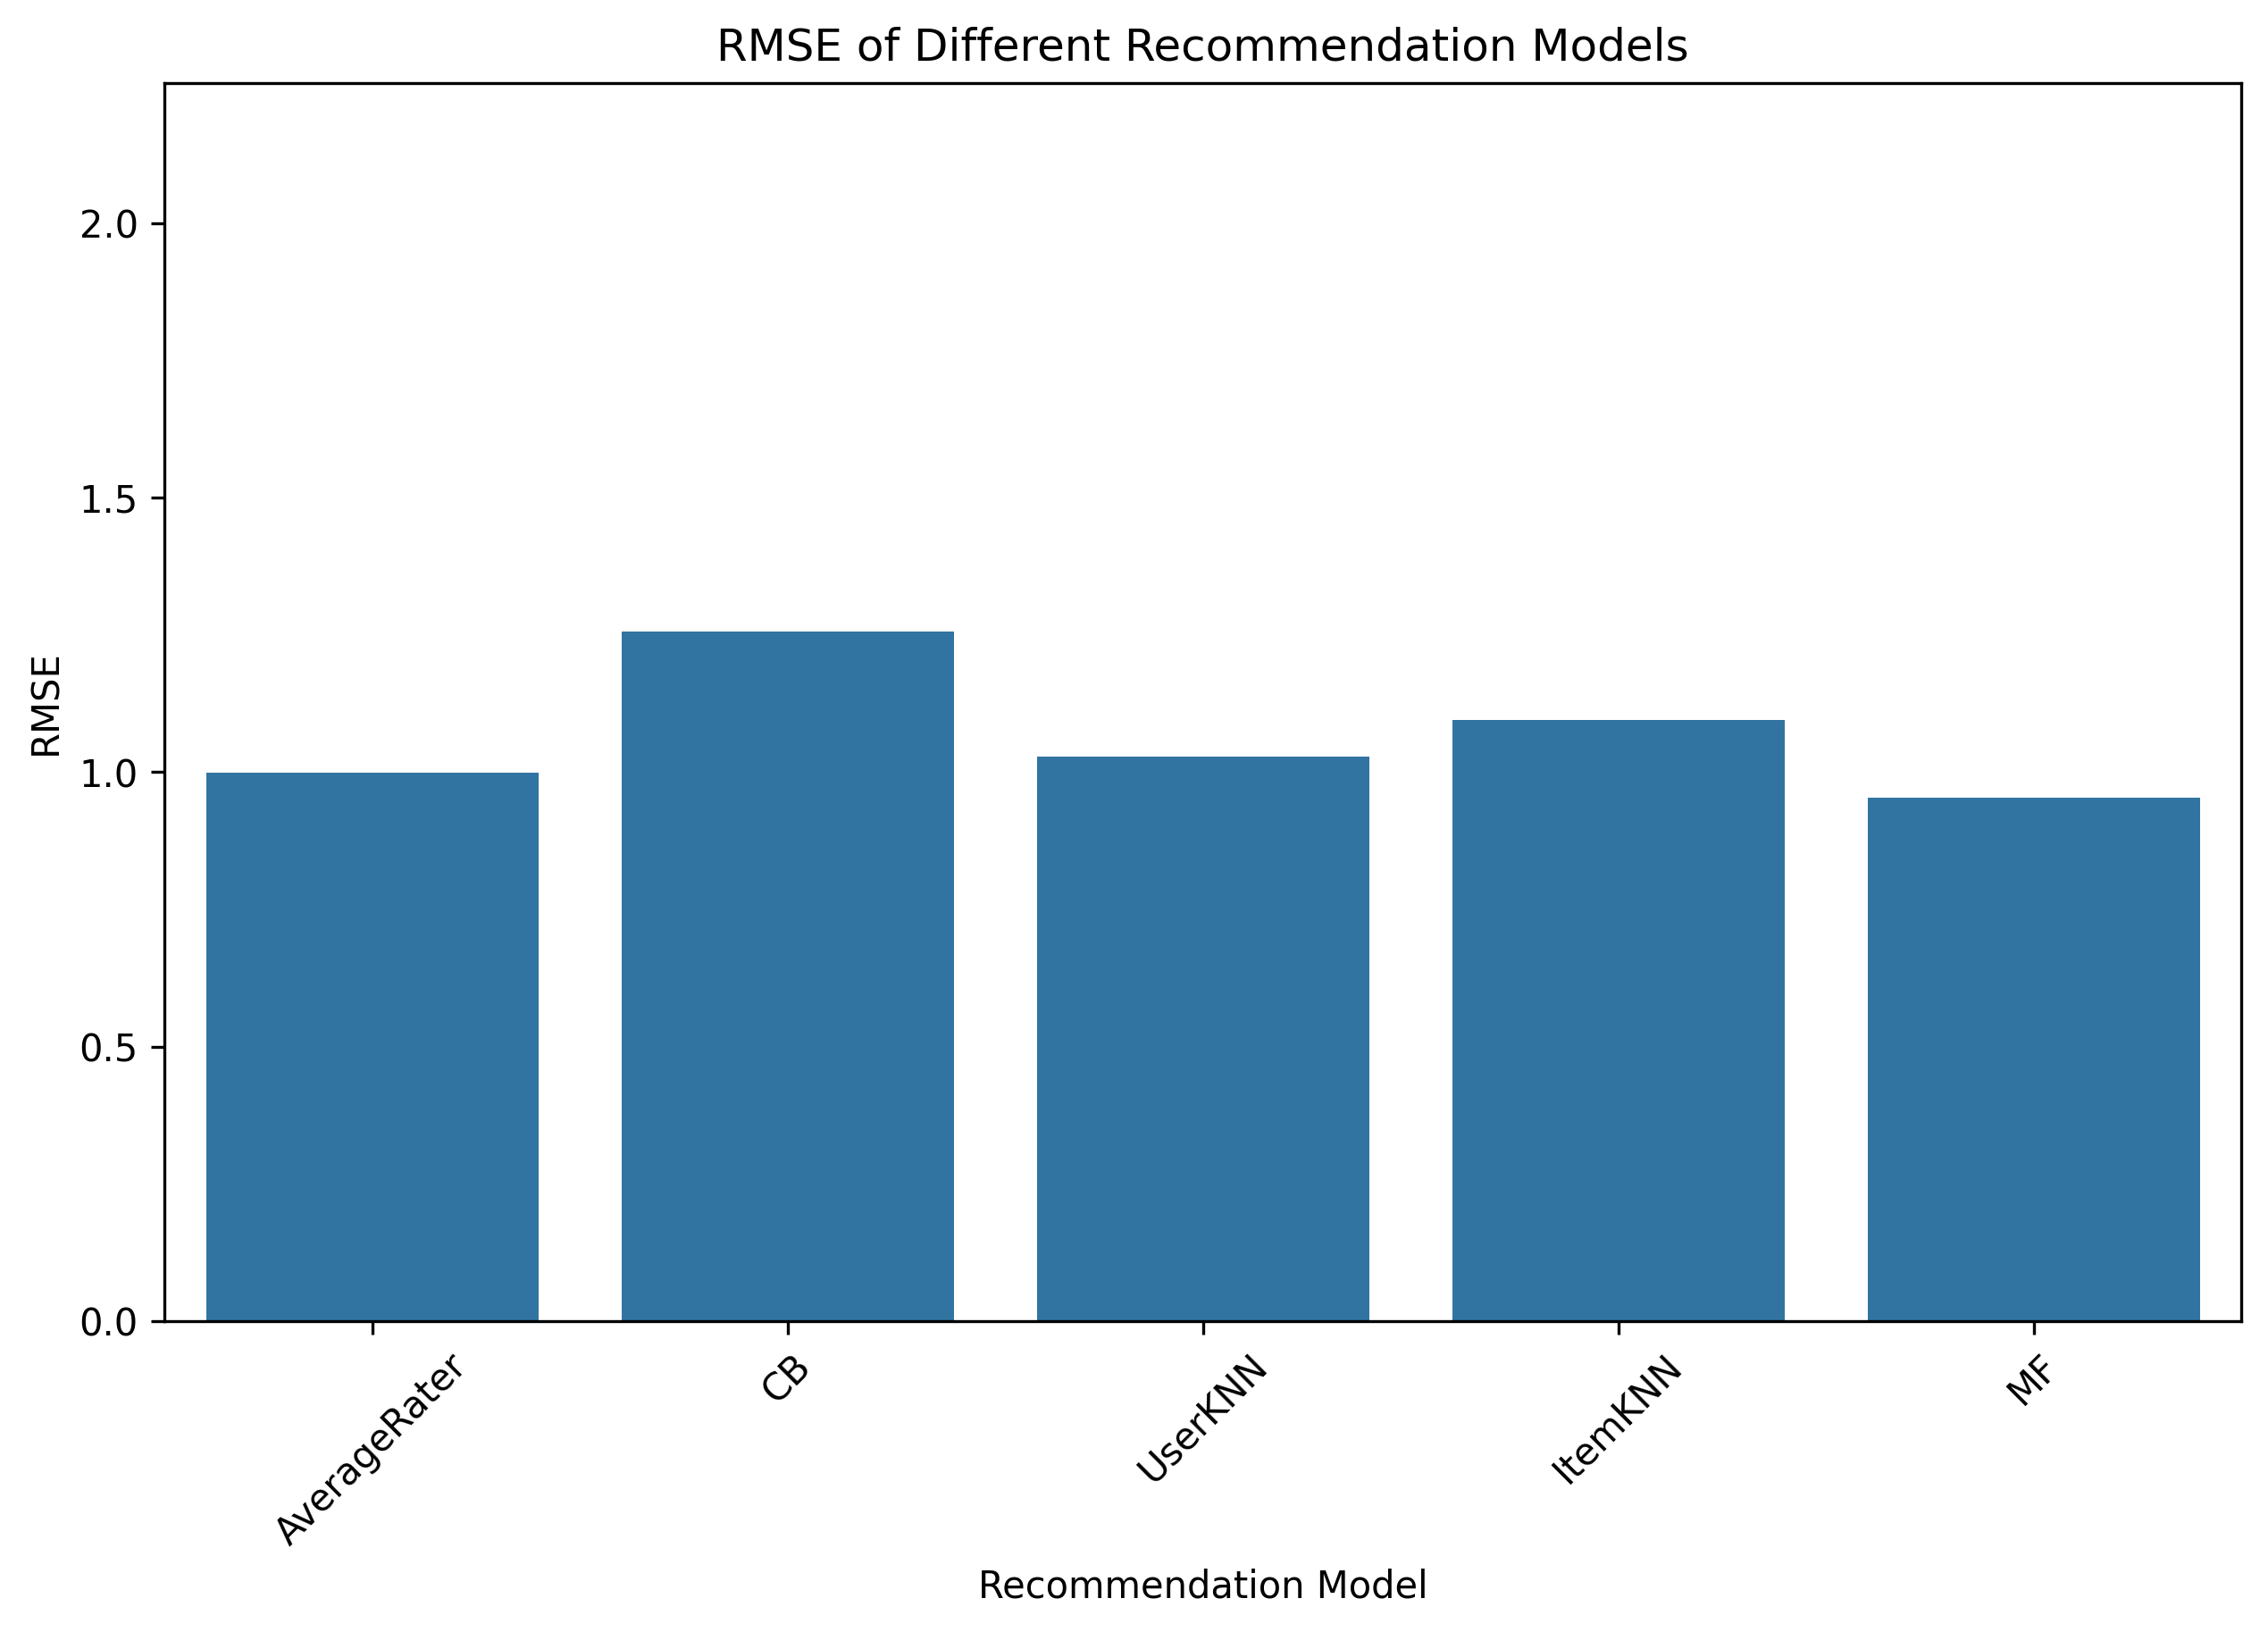

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #004085;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <b>Performance Against Baselines</b><br><br>
    <b>Matrix Factorization (MF)</b> is the only algorithm that consistently outperforms our baselines. This may be because the average rater is more conservative in their ratings, leading naive benchmarks like <b>AverageRater</b> to perform reasonably well.<br><br>
    It is possible that some of the other models are overfitted to the training data and do not generalize as effectively. As a result, even a simple baseline can achieve competitive performance, highlighting the robustness of MF in capturing latent user-item relationships.
</div>


<h3>Ranking Baselines</h3>

In [ ]:
baseline_rankings_paths = { # filepaths to the saved predictions from different models
    'RandomRanker': 'model_checkpoints/test/random_ranker/rankings/',
    'PopularityBasedRanker': 'model_checkpoints/test/popularity_based_ranker/rankings/',
    'CB': 'model_checkpoints/test/content_based_recommender/rankings/',
    'UserKNN': 'model_checkpoints/test/user_knn/rankings/',
    'ItemKNN': 'model_checkpoints/test/item_knn/rankings/',
    'MF': 'model_checkpoints/test/matrix_factorization/rankings/',
    'BPR': 'model_checkpoints/test/bayesian_probabilistic_ranking/rankings/',
    # 'MeanHybrid': 'model_checkpoints/test/mean_hybrid_recommender/rankings',
}


ranking_predictions_baselines = load_all_ranking_predictions(baseline_rankings_paths)

In [ ]:
res_dict_rankings_baselines = evaluate_ranking_all(ranking_predictions_baselines, test_data_small)
res_dict_rankings_baselines_df = pd.DataFrame.from_dict(results, orient='index', columns=['precision', 'recall', 'ndcg']).reset_index().rename(columns={'index': 'model'}).set_index('model')

# adding rmse
res_dict_rankings_baselines_df['rmse'] = res_dict_rankings_baselines_df.index.map(res_dict_baselines)
display(res_dict_rankings_baselines_df)

<i>Discuss ranking results for baselines, compare to other models</i>

# Task 4) Analysis of recommendation models. Analyzing the coefficients of hybrid model and the success of recommendation models for different users' groups. 

### Rating-Based

In [ ]:
import seaborn as sns   
rating_recommenders = [content_based_best, user_knn_best, item_knn_best, mf_best]
rating_recommenders_names = ["content_based_best", "user_knn_best", "item_knn_best", "mf_best"]
ranking_recommenders = [content_based_best, user_knn_best, item_knn_best, mf_best, bpr_best]

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #004085;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <b>Hybrid Model Insights</b><br><br>
    <p>The hybrid model provides valuable insights into the behavior of our individual recommenders — 
    identifying where they are <b>overconfident</b>, how well they <b>maintain relative order</b>, 
    and whether their outputs complement or contradict each other.<br><br></p>
    <p>The linear hybrid model achieves the following coefficients:<br></p>
    <ul>
        <li><b>w₀ (Matrix Factorization):</b> 0.7464</li>
        <li><b>w₁ (Item KNN):</b> 0.6823</li>
        <li><b>w₂ (User KNN):</b> 0.0080</li>
        <li><b>w₃ (Content-Based Recommender):</b> -0.4037</li>
    </ul>
    Plotting the loss of the hybrid recommender, along with the evolution and IQR of the weights, 
    gives us further insight into how each component contributes to the ensemble’s performance.<br><br>
</div>


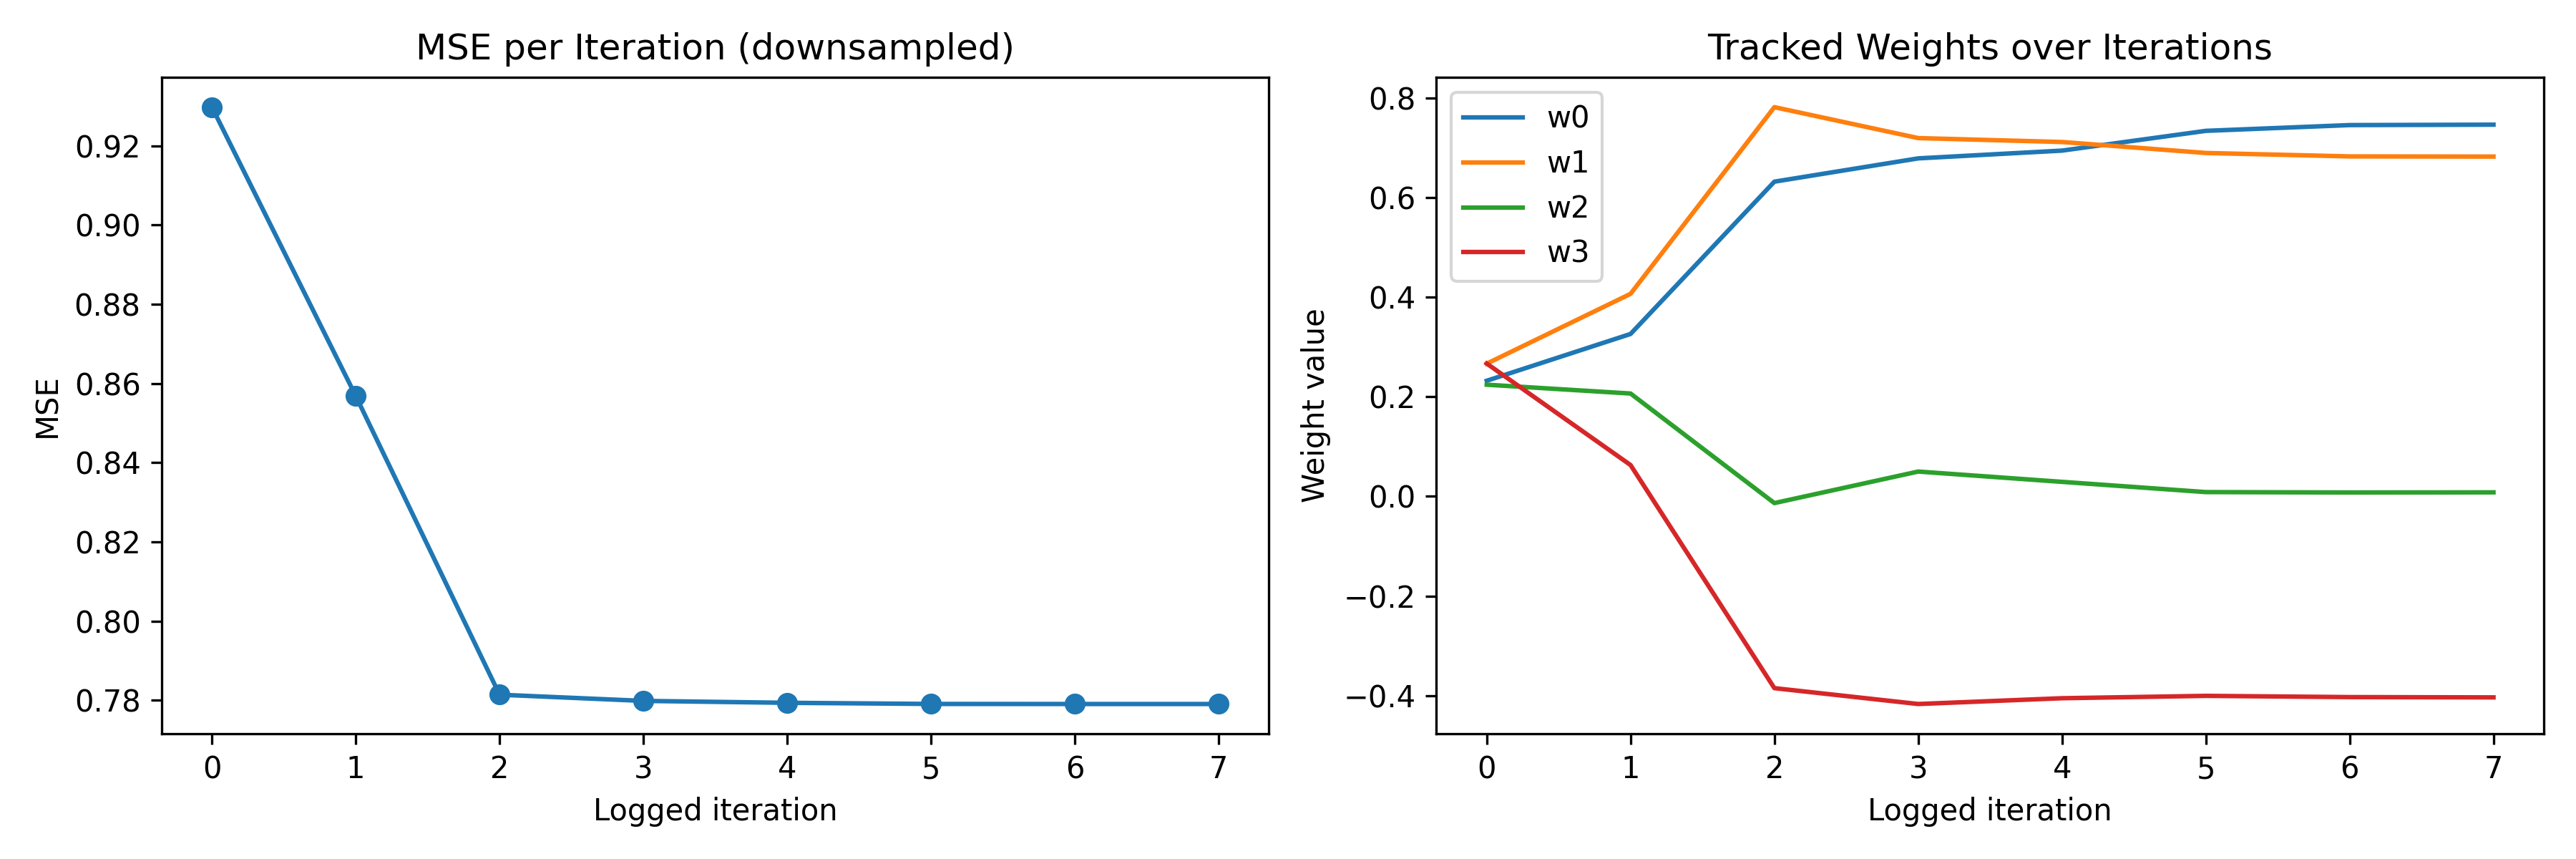

In [ ]:
# fig, axs = plt.subplots(1, 4, figsize=(15, 4))
# for i, r in enumerate(rating_recommenders): 
#     sns.boxplot(x=r.predictions["predicted_score"].to_numpy(), ax=axs[i])
#     axs[i].set_title(rating_recommenders_names[i])
    
# plt.show()

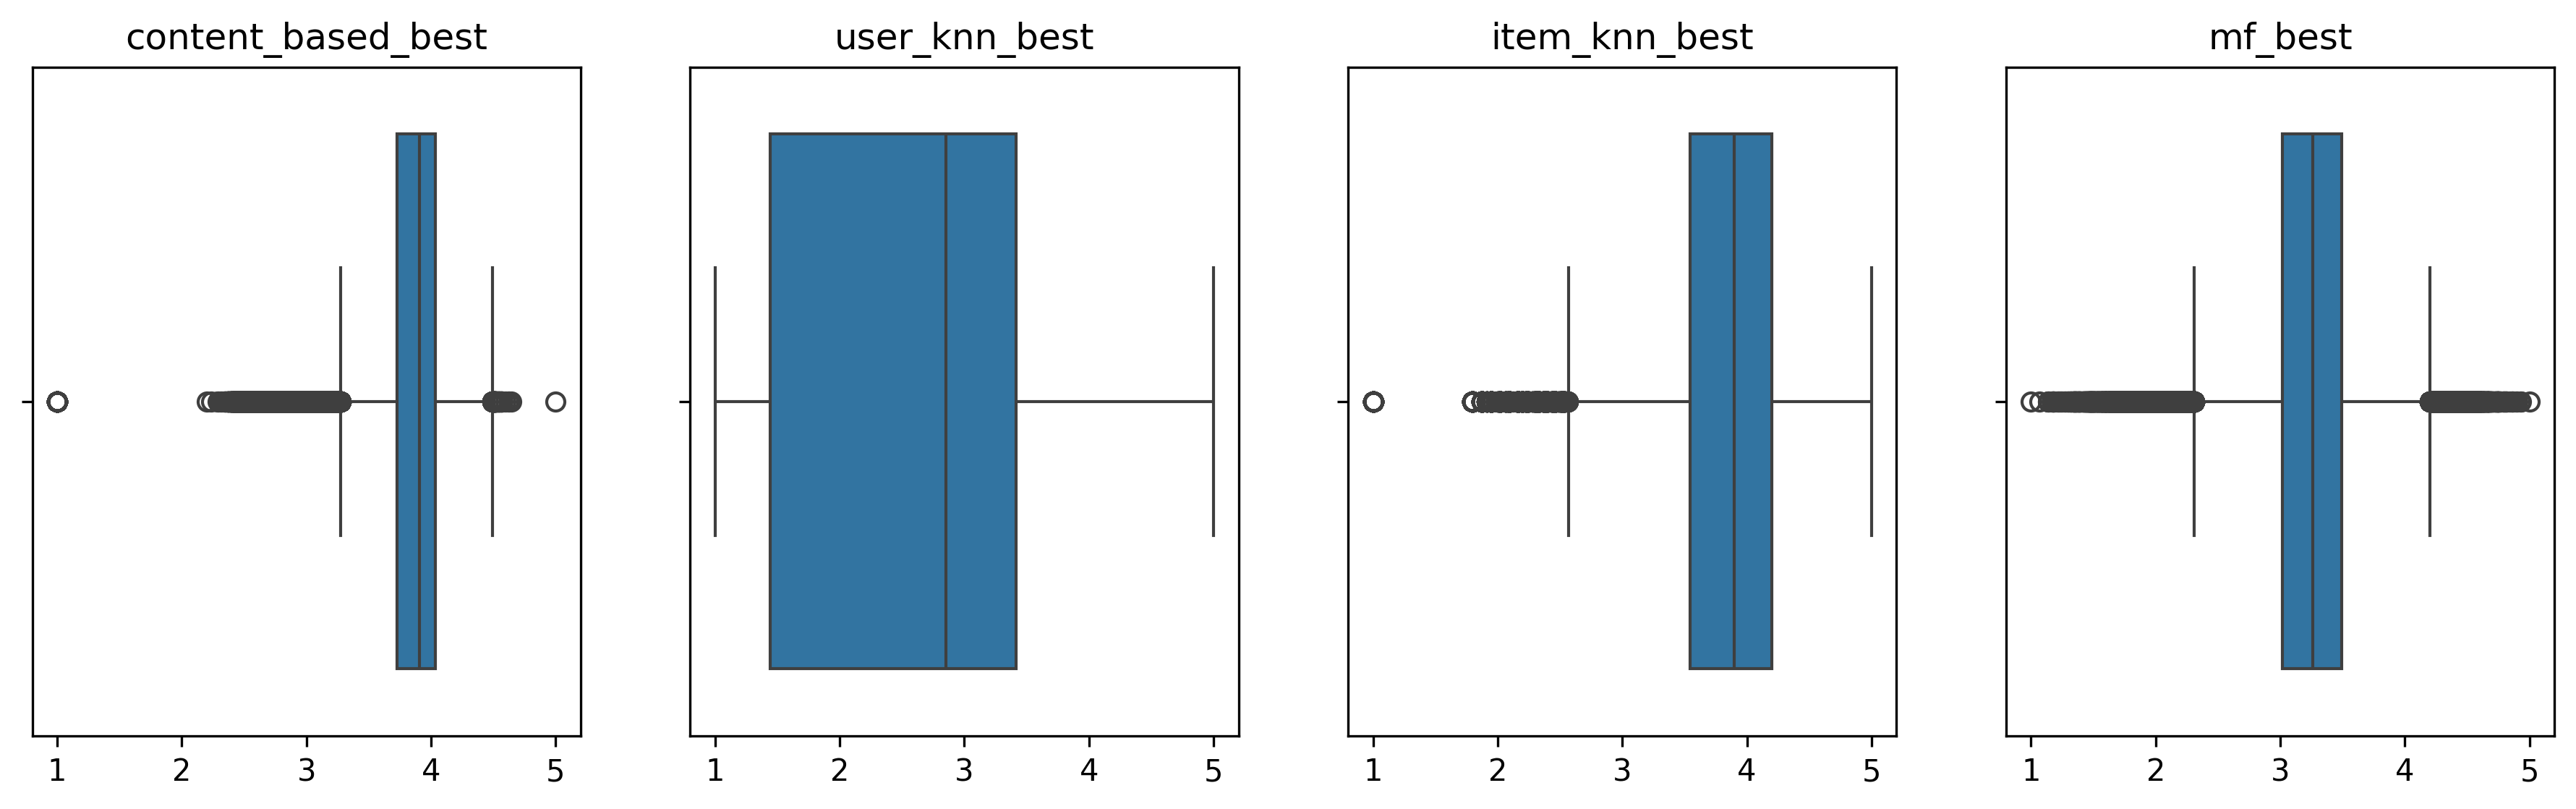

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #004085;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <b>Hybrid Rating Model Results Interpretation </b><br><br>
    <p>The results in the training phase and the box plots are consistent. <b>Matrix Factorization (MF)</b> proves to be a highly informative algorithm, producing stable and meaningful predictions. 
    <b>ItemKNN</b> is also known for its accurate predictions, as it considers only items that the user has already interacted with — naturally leading to values that converge toward similar scores.<br><br></p>
    The widest spread is observed with <b>UserKNN</b>, typically around ratings of 3. This aligns with the general consensus that user-based approaches tend to introduce more novelty, since finding similar users is a more complex and uncertain task compared to finding similar items.<br><br>
    The <b>negative coefficient</b> from the <b>Content-Based Recommender</b> can be interpreted as an indication of overconfidence. The learned embeddings do not directly align with a collaborative objective — they primarily capture vector-space similarities, which may not always reflect user preference structures.<br><br>
    Overall, the <b>hybrid model</b> successfully balances the strengths of all components. MF and ItemKNN deliver accurate, stable predictions, while the content-based component introduces item-level interpretability. The UserKNN behaves as a <b>regularizer</b>, adding diversity and preventing overfitting to overly confident models.
</div>


---
### Ranking-based

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #004085;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <p>The linear hybrid ranking model achieves the following coefficients:<br></p>
    <ul>
        <li>w0:<b>Matrix Factorization:</b> 2.509648123056215</li>
        <li>w1:<b>Bayesian Probabilistic Ranking:</b> 0.5489170296669148</li>
        <li>w2:<b>Item KNN:</b> 0.7298399236580264</li>
        <li>w3:<b>User KNN:</b> 0.8006073629895228</li>
        <li>w4:<b>Content Based Recommender:</b> 0.5142406776046714</li>
    </ul>
</div>


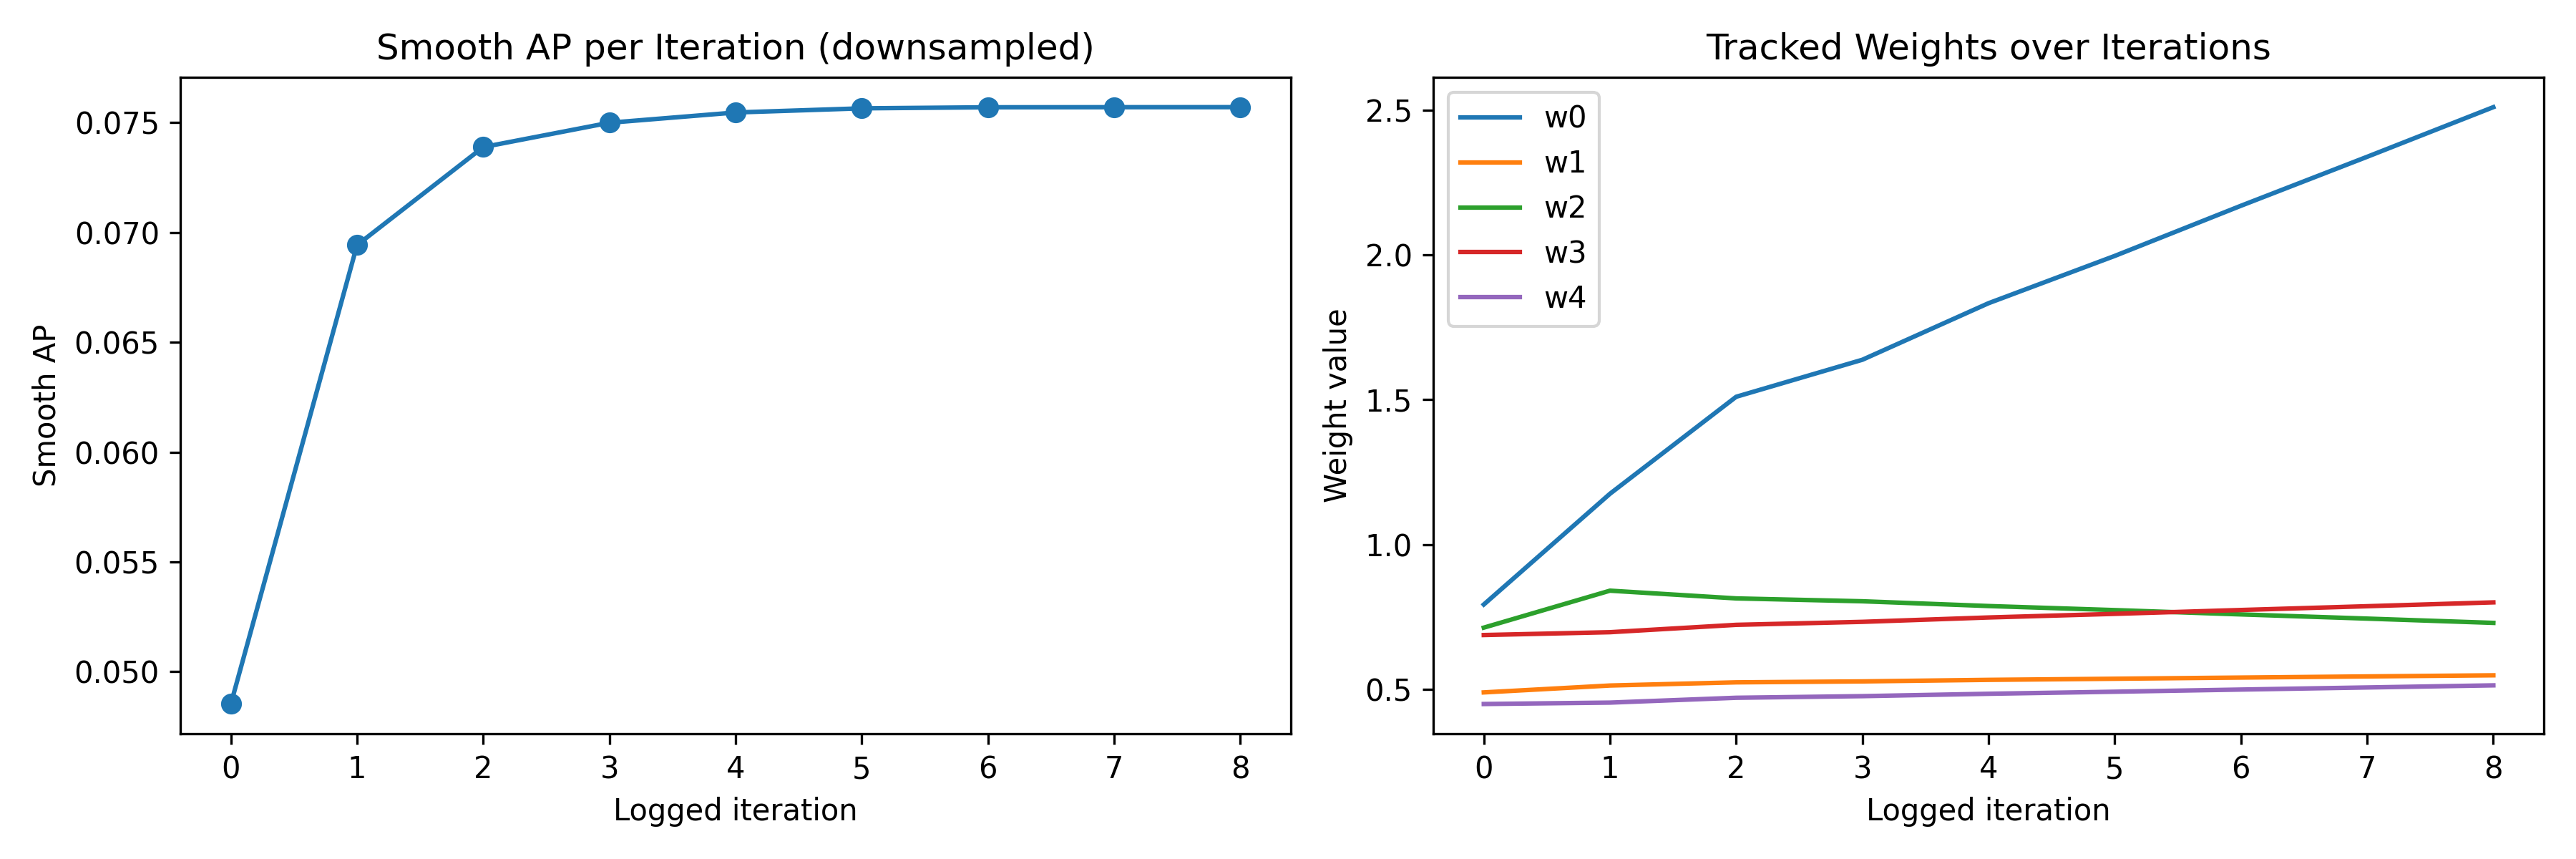

<div style="
    background-color:#cce5ff;
    color:black;
    padding:15px;
    border-left:5px solid #004085;
    border-radius:8px;
    font-family: 'Segoe UI', sans-serif;
">
    <b>Hybrid Ranking Model Results Interpretation </b><br><br>
    The results show, unsuprisingly that MF has the largest contribution of all the models. The rest of them have either minor increases/decreases in their weights throughout training. MF is a ranking algorithm, and it is normal it maximizes AP more than the others. The surprising result among them is that BPR has lower weight than the others. The team's speculation on the matter is that the informaiton it contains is partially redundant due to using MF in the back. It is more used for its regularization capabilities as such. <br>
    <p>There is no notable difference between the others. Content-based likely contributes less than the ItemkNN and UserKNN due to not actually being trained to the data, but using the embeddings and aggregates.</p> <br>
    In all cases, the loss looks stable, besides just being an approximation of the ranking.

</div>


### Group-based performance analysis

Where is each recommendation model successful in delivering accurate recommendation? -> For which user groups each recommendation model results in the highest accuracy?

We will be looking at the following user groups:

- Biggest fans of certain genres - users with most ratings in each genre
- Niche taste users - users with lowest average popularity of rated items
- Mainstream taste users - users with highest average popularity of rated items
- High activity users - users with most ratings
- Low activity users - users with least ratings

We set a max group size of 100 users per group, so that ranking scores are not approximately 0.

In [25]:
def popularity_matrix(train_data: pd.DataFrame) -> pd.Series:
    """
    Calculate the popularity of each item in the training data. Used in Task 4 and 5.
    :param train_data: training data
    :return: pd.Series with item ids as index and popularity as values
    """
    total_interactions = len(train_data)
    counts = train_data['item_id'].value_counts()
    popularity = counts / total_interactions
    return popularity

In [67]:
# finding / defining groups of users
group_size = 100

# highest and lowest activity
user_activity = test_data.groupby('user_id').size()
high_activity_users = user_activity.nlargest(group_size).index.tolist()
low_activity_users = user_activity.nsmallest(group_size).index.tolist()

# niche and mainstream taste
item_popularity = popularity_matrix(train_data)
user_avg_popularity = test_data.merge(item_popularity.rename('popularity'), left_on='item_id', right_index=True).groupby('user_id')['popularity'].mean()
niche_taste_users = user_avg_popularity.nsmallest(group_size).index.tolist()
mainstream_taste_users = user_avg_popularity.nlargest(group_size).index.tolist()

# biggest fans of each genre
movie_genres = movies.set_index('item_id')['genres'].str.split(',')
movie_genres = movie_genres.apply(lambda g: [s.strip() for s in g])  # clean whitespace
genre_user_counts = {}
for genre in set(g for genres in movie_genres for g in genres):
    users_in_genre = test_data[test_data['item_id'].isin(movie_genres[movie_genres.apply(lambda gs: genre in gs)].index)]
    user_counts = users_in_genre['user_id'].value_counts()
    top_users = user_counts.nlargest(group_size).index.tolist()
    genre_user_counts[genre] = top_users

In [68]:
# we have ndcg, precision, recall per user -> store in dataframe, do dict with DF per model

all_users = train_data['user_id'].unique()
# user_rmses - dict {model : { user_id: rmse } }
# model_user_ranking_res - { model : { user_id: { 'precision': , 'recall': , 'ndcg':  } } }

def get_user_results(user_id, rmses: dict, ranking_predictions: dict) -> dict:
    """
    Get ranking results for a single user.
    :param rmses: {model : { user_id: rmse } }
    :param ranking_predictions: { model : { user_id: { 'precision': , 'recall': , 'ndcg':  } } }
    :param user_id: user id
    :return:
    """
    rmses = { model : user_dict[user_id] if user_id in user_dict.keys() else np.nan for model, user_dict in rmses.items() }
    ranking_scores = { model : user_dict[user_id] if user_id in user_dict.keys() else {'precision': np.nan, 'recall': np.nan, 'ndcg': np.nan} for model, user_dict in ranking_predictions.items() }
    df = pd.DataFrame.from_dict(ranking_scores, orient='index')
    df['rmse'] = df.index.map(rmses)
    return df

user_scores = { u: get_user_results(u, user_rmses, model_user_ranking_res) for u in all_users }

def get_group_results(group_users: list[int], user_scores) -> dict:
    """
    Get average ranking results for a group of users.
    :param user_scores: { user_id: pd.DataFrame with index=model, columns=['precision', 'recall', 'ndcg', 'rmse']}
    :param group_users: list of user ids in the group
    :return:
    """
    rmses = np.mean([user_scores[u]['rmse'] for u in group_users if u in user_scores], axis=0)
    precisions = np.mean([user_scores[u]['precision'] for u in group_users if u in user_scores], axis=0)
    recalls = np.mean([user_scores[u]['recall'] for u in group_users if u in user_scores], axis=0)
    ndcgs = np.mean([user_scores[u]['ndcg'] for u in group_users if u in user_scores], axis=0)
    df = pd.DataFrame({
        'rmse': rmses,
        'precision': precisions,
        'recall': recalls,
        'ndcg': ndcgs
    }, index=user_scores[next(iter(user_scores))].index)
    return df


In [38]:
results_groups = {
    'high_activity': get_group_results(high_activity_users, user_scores),
    'low_activity': get_group_results(low_activity_users, user_scores),
    'niche_taste': get_group_results(niche_taste_users, user_scores),
    'mainstream_taste': get_group_results(mainstream_taste_users, user_scores),
}
for genre, users in genre_user_counts.items():
    results_groups[f'biggest_fans_{genre}'] = get_group_results(users, user_scores)

for group_name, group_df in results_groups.items():
    print(f'Group: {group_name}')
    display(group_df)

Group: high_activity


,rmse,precision,recall,ndcg
CB,1.216487,0.666667,0.2,0.005307
UserKNN,1.140122,1.666667,0.5,0.014190
ItemKNN,1.147150,1.666667,0.5,0.019386
MF,0.948086,5.000000,1.5,0.042346
BPR,NaN,0.000000,0.0,0.000000


Group: low_activity


,rmse,precision,recall,ndcg
CB,1.097053,0.333333,0.100000,0.002961
UserKNN,1.067233,0.333333,0.142857,0.002346
ItemKNN,1.029691,0.666667,0.200000,0.005307
MF,0.921635,0.333333,0.100000,0.002346
BPR,NaN,0.666667,0.200000,0.005307


Group: niche_taste


,rmse,precision,recall,ndcg
CB,1.205109,0.333333,0.1,0.002346
UserKNN,1.164719,1.333333,0.4,0.011229
ItemKNN,1.151975,0.666667,0.2,0.005922
MF,0.971150,4.333333,1.3,0.037039
BPR,NaN,0.333333,0.1,0.004693


Group: mainstream_taste


,rmse,precision,recall,ndcg
CB,1.174500,2.333333,0.7,0.017654
UserKNN,1.078354,0.666667,0.2,0.005922
ItemKNN,1.078284,1.333333,0.4,0.016425
MF,0.957744,1.666667,0.5,0.012961
BPR,NaN,1.333333,0.4,0.013575


Group: biggest_fans_Adventure


,rmse,precision,recall,ndcg
CB,1.198965,1.000000,0.3,0.007654
UserKNN,1.111392,2.333333,0.7,0.020111
ItemKNN,1.118259,2.333333,0.7,0.026425
MF,0.934338,3.666667,1.1,0.031843
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Comedy


,rmse,precision,recall,ndcg
CB,1.223081,0.666667,0.2,0.005307
UserKNN,1.142649,1.666667,0.5,0.014190
ItemKNN,1.146887,1.333333,0.4,0.017039
MF,0.950642,5.000000,1.5,0.044693
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Mystery


,rmse,precision,recall,ndcg
CB,1.214077,0.666667,0.2,0.005307
UserKNN,1.132124,1.000000,0.3,0.008882
ItemKNN,1.132697,1.000000,0.3,0.011732
MF,0.936660,3.666667,1.1,0.027654
BPR,NaN,0.333333,0.1,0.002961


Group: biggest_fans_Sci-Fi


,rmse,precision,recall,ndcg
CB,1.205110,1.000000,0.3,0.007654
UserKNN,1.121659,1.666667,0.5,0.014190
ItemKNN,1.136264,2.333333,0.7,0.026425
MF,0.945086,3.000000,0.9,0.025922
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Children's


,rmse,precision,recall,ndcg
CB,1.225186,0.333333,0.1,0.002346
UserKNN,1.124773,2.000000,0.6,0.017150
ItemKNN,1.131723,1.666667,0.5,0.020000
MF,0.947735,5.000000,1.5,0.042961
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Crime


,rmse,precision,recall,ndcg
CB,1.218610,1.666667,0.5,0.012346
UserKNN,1.143067,1.666667,0.5,0.014190
ItemKNN,1.140178,1.333333,0.4,0.015307
MF,0.949156,5.000000,1.5,0.042346
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Romance


,rmse,precision,recall,ndcg
CB,1.210906,0.333333,0.1,0.002346
UserKNN,1.128423,1.000000,0.3,0.008268
ItemKNN,1.121952,1.666667,0.5,0.019386
MF,0.933835,4.666667,1.4,0.041118
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_War


,rmse,precision,recall,ndcg
CB,1.191908,1.000000,0.3,0.007654
UserKNN,1.087003,1.000000,0.3,0.008882
ItemKNN,1.103132,1.666667,0.5,0.019386
MF,0.922032,5.000000,1.5,0.039386
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Horror


,rmse,precision,recall,ndcg
CB,1.207970,0.333333,0.1,0.002346
UserKNN,1.113594,1.333333,0.4,0.011229
ItemKNN,1.114568,1.333333,0.4,0.014693
MF,0.934886,3.000000,0.9,0.022961
BPR,NaN,0.333333,0.1,0.002961


Group: biggest_fans_Western


,rmse,precision,recall,ndcg
CB,1.224825,0.333333,0.1,0.002961
UserKNN,1.122347,0.333333,0.1,0.002961
ItemKNN,1.124755,2.333333,0.7,0.027039
MF,0.937372,3.333333,1.0,0.026425
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Animation


,rmse,precision,recall,ndcg
CB,1.227391,0.666667,0.2,0.004693
UserKNN,1.132648,2.666667,0.8,0.023072
ItemKNN,1.113444,1.666667,0.5,0.019386
MF,0.942398,5.333333,1.6,0.046536
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Thriller


,rmse,precision,recall,ndcg
CB,1.202660,1.000000,0.3,0.007654
UserKNN,1.130290,1.333333,0.4,0.011229
ItemKNN,1.122220,1.666667,0.5,0.021118
MF,0.937336,4.000000,1.2,0.032346
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_unknown


,rmse,precision,recall,ndcg
CB,1.404904,0.000000,0.000000,0.000000
UserKNN,1.075184,4.761905,1.428571,0.042297
ItemKNN,1.194803,0.000000,0.000000,0.000000
MF,0.977033,4.761905,1.428571,0.042297
BPR,NaN,0.000000,0.000000,0.000000


Group: biggest_fans_Documentary


,rmse,precision,recall,ndcg
CB,1.249006,0.333333,0.1,0.002961
UserKNN,1.149533,0.666667,0.2,0.005922
ItemKNN,1.133457,0.666667,0.2,0.007039
MF,0.951703,5.666667,1.7,0.048157
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Action


,rmse,precision,recall,ndcg
CB,1.202764,1.000000,0.3,0.007654
UserKNN,1.124835,1.666667,0.5,0.014190
ItemKNN,1.125025,2.333333,0.7,0.026425
MF,0.940630,4.000000,1.2,0.030614
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Film-Noir


,rmse,precision,recall,ndcg
CB,1.232151,0.333333,0.100000,0.002961
UserKNN,1.113375,2.000000,0.642857,0.016536
ItemKNN,1.105548,1.000000,0.300000,0.010000
MF,0.941414,4.333333,1.300000,0.037654
BPR,NaN,0.333333,0.100000,0.002961


Group: biggest_fans_Musical


,rmse,precision,recall,ndcg
CB,1.214570,0.333333,0.1,0.002346
UserKNN,1.131762,2.333333,0.7,0.020111
ItemKNN,1.120640,2.333333,0.7,0.024693
MF,0.939332,6.000000,1.8,0.050614
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Drama


,rmse,precision,recall,ndcg
CB,1.211530,0.333333,0.1,0.002346
UserKNN,1.137978,1.666667,0.5,0.014190
ItemKNN,1.138564,1.333333,0.4,0.012961
MF,0.938849,6.000000,1.8,0.049386
BPR,NaN,0.000000,0.0,0.000000


Group: biggest_fans_Fantasy


,rmse,precision,recall,ndcg
CB,1.209739,1.000000,0.3,0.008268
UserKNN,1.146404,2.000000,0.6,0.017150
ItemKNN,1.115211,1.666667,0.5,0.019386
MF,0.938297,3.666667,1.1,0.031229
BPR,NaN,0.000000,0.0,0.000000


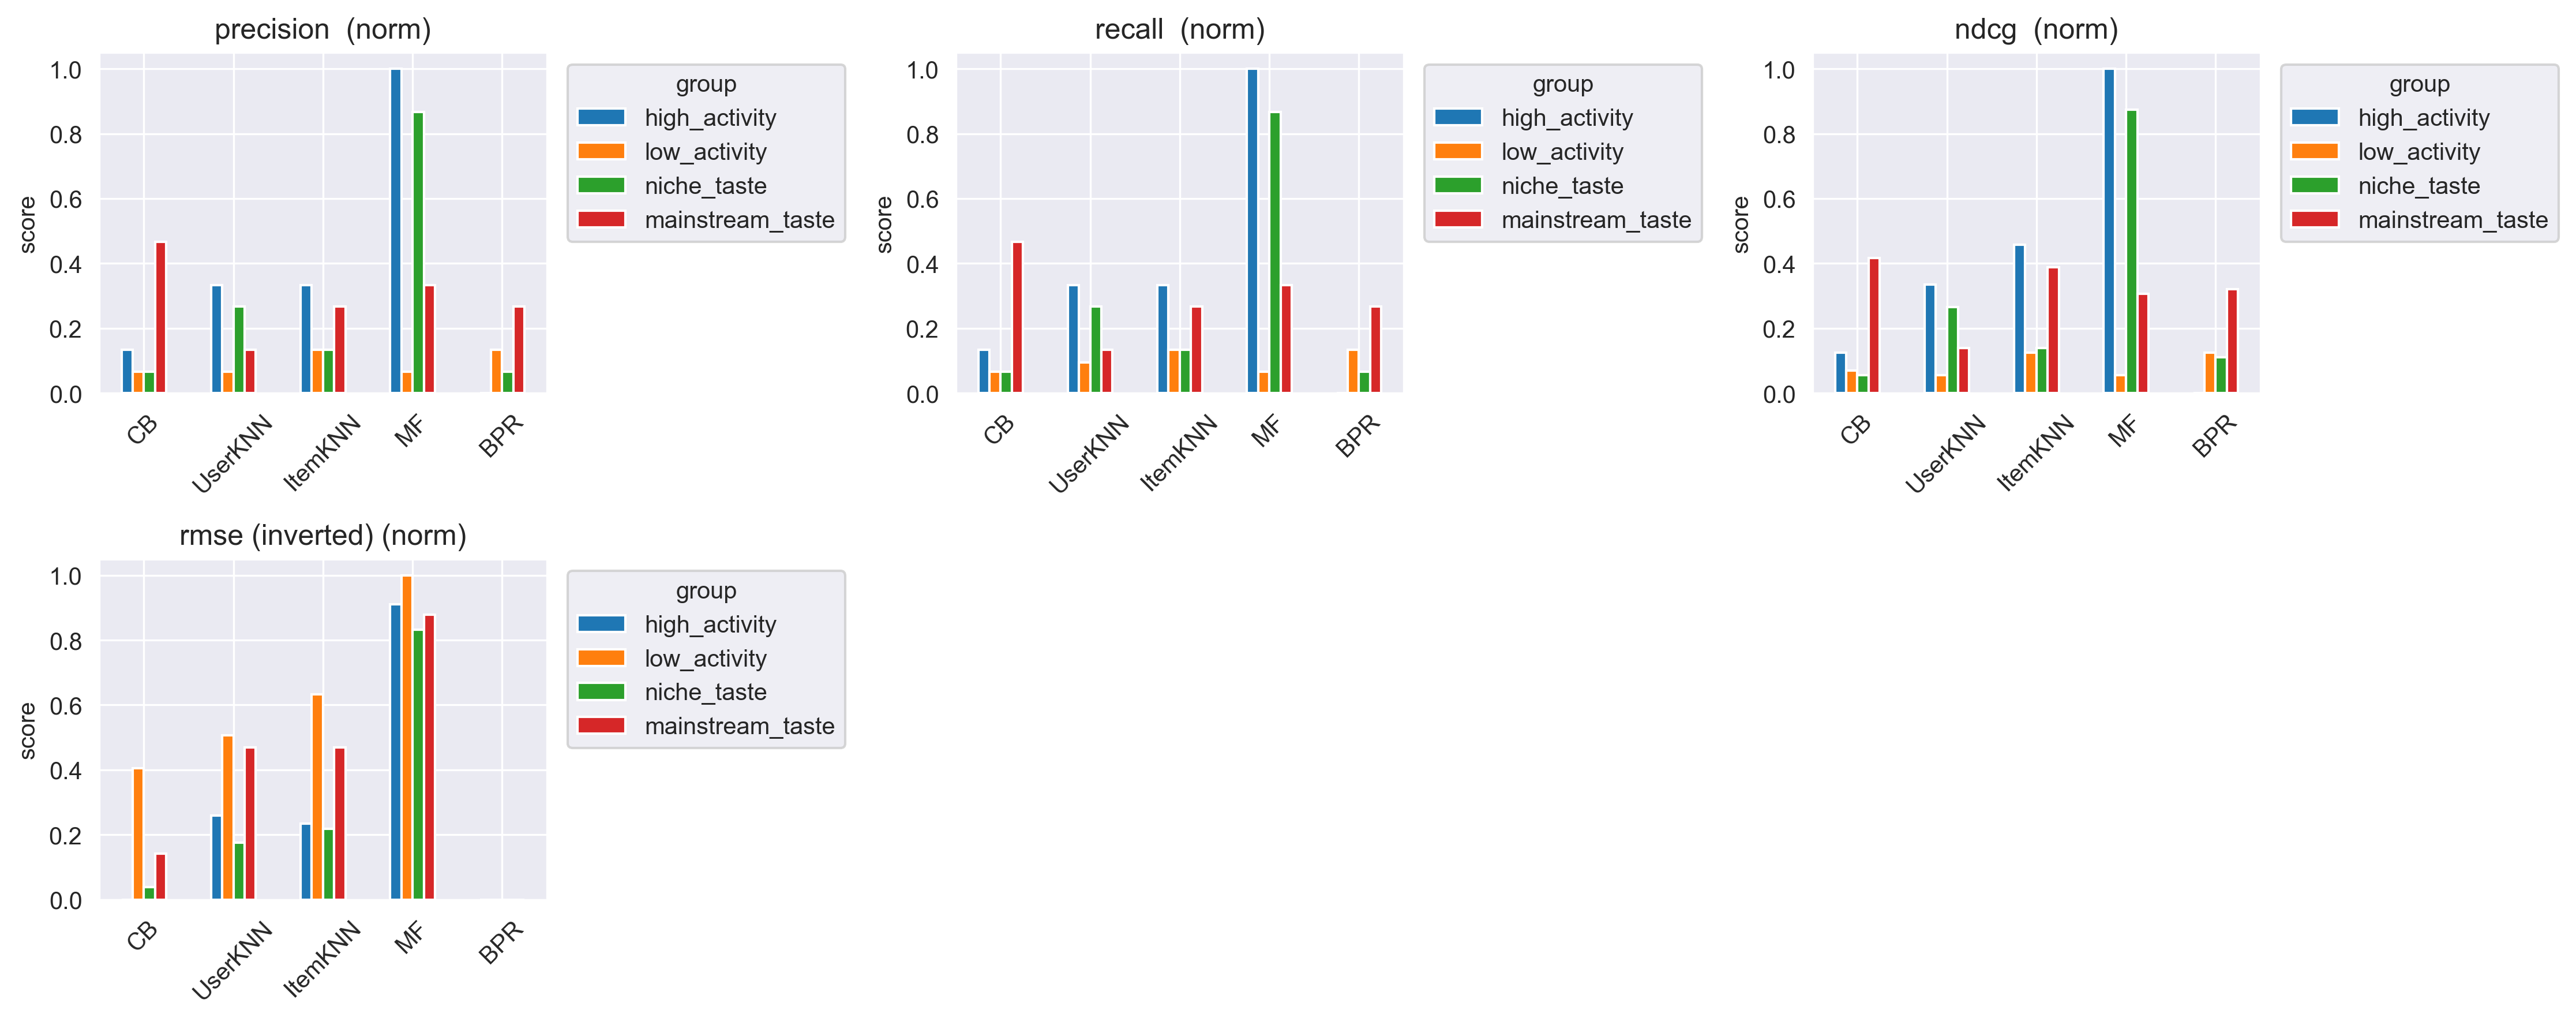

In [48]:
from sklearn.preprocessing import minmax_scale

groups=['high_activity','low_activity','niche_taste','mainstream_taste']
metrics=['precision','recall','ndcg','rmse']
invert_rmse=True
normalize=True
figsize_per_metric=(5,3)
diff_pair=('mainstream_taste','niche_taste')

models = list(next(iter(results_groups.values())).index)

# build metric matrices: metric -> DataFrame(models x groups)
metric_matrices = {}
for m in metrics:
    mat = pd.DataFrame(index=models, columns=groups, dtype=float)
    for g in groups:
        df = results_groups[g]
        if m not in df.columns:
            raise KeyError(f"Metric {m} not in group {g}")
        mat[g] = df[m].reindex(models).astype(float)
    if m == 'rmse' and invert_rmse:
        # invert so larger is better (preserve scale)
        mat = mat.max().max() - mat
    if normalize:
        # min-max normalize across all cells for this metric
        flattened = mat.values.flatten()
        # avoid constant columns causing NaN
        scaled = minmax_scale(flattened.reshape(-1,1)).reshape(mat.shape)
        mat = pd.DataFrame(scaled, index=models, columns=groups)
    metric_matrices[m] = mat

# --- Plot grouped bar charts (one subplot per metric) ---
n_metrics = len(metrics)
ncols = min(3, n_metrics)
nrows = ceil(n_metrics / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize_per_metric[0], nrows * figsize_per_metric[1]), squeeze=False)
for idx, m in enumerate(metrics):
    r = idx // ncols
    c = idx % ncols
    ax = axes[r][c]
    mat = metric_matrices[m]
    mat.plot(kind='bar', ax=ax)
    ax.set_title(f'{m} {"(inverted)" if (m=="rmse" and invert_rmse) else ""}{" (norm)" if normalize else ""}')
    ax.set_ylabel('score')
    ax.set_xlabel('')
    ax.legend(title='group', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)
# turn off unused axes
total = nrows * ncols
for k in range(n_metrics, total):
    r = k // ncols
    c = k % ncols
    axes[r][c].axis('off')
plt.tight_layout()
plt.show()



When looking at the performance of different recommendation models across user groups, we can observe several trends. First, matrix factorisation is able to achieve the highest scores across most user groups and metrics, indicating its overall effectiveness. When doing rating predictions, it performs best for low activity users but worse for those with niche tastes, suggesting it is more dependent on item representation in a training set rather than user profiles being developed. For ranking tasks, it outperforms other recommendation models by far for high activity users and niche taste users, indicating its strength in capturing user preferences when sufficient data is available. However, it struggles with low activity users, contrasting its relative performance in rating predictions.

The other metrics all seem to perform differently across the user groups, with no single model consistently outperforming the others. The collaborative filtering models show expected results, item-based collaborative filtering does well for mainstream taste users in both rating and ranking tasks, likely due to its reliance on item similarities that align with popular preferences. User-based collaborative filtering shows strength in ranking tasks for high activity users, benefiting from the rich interaction data available for these users.

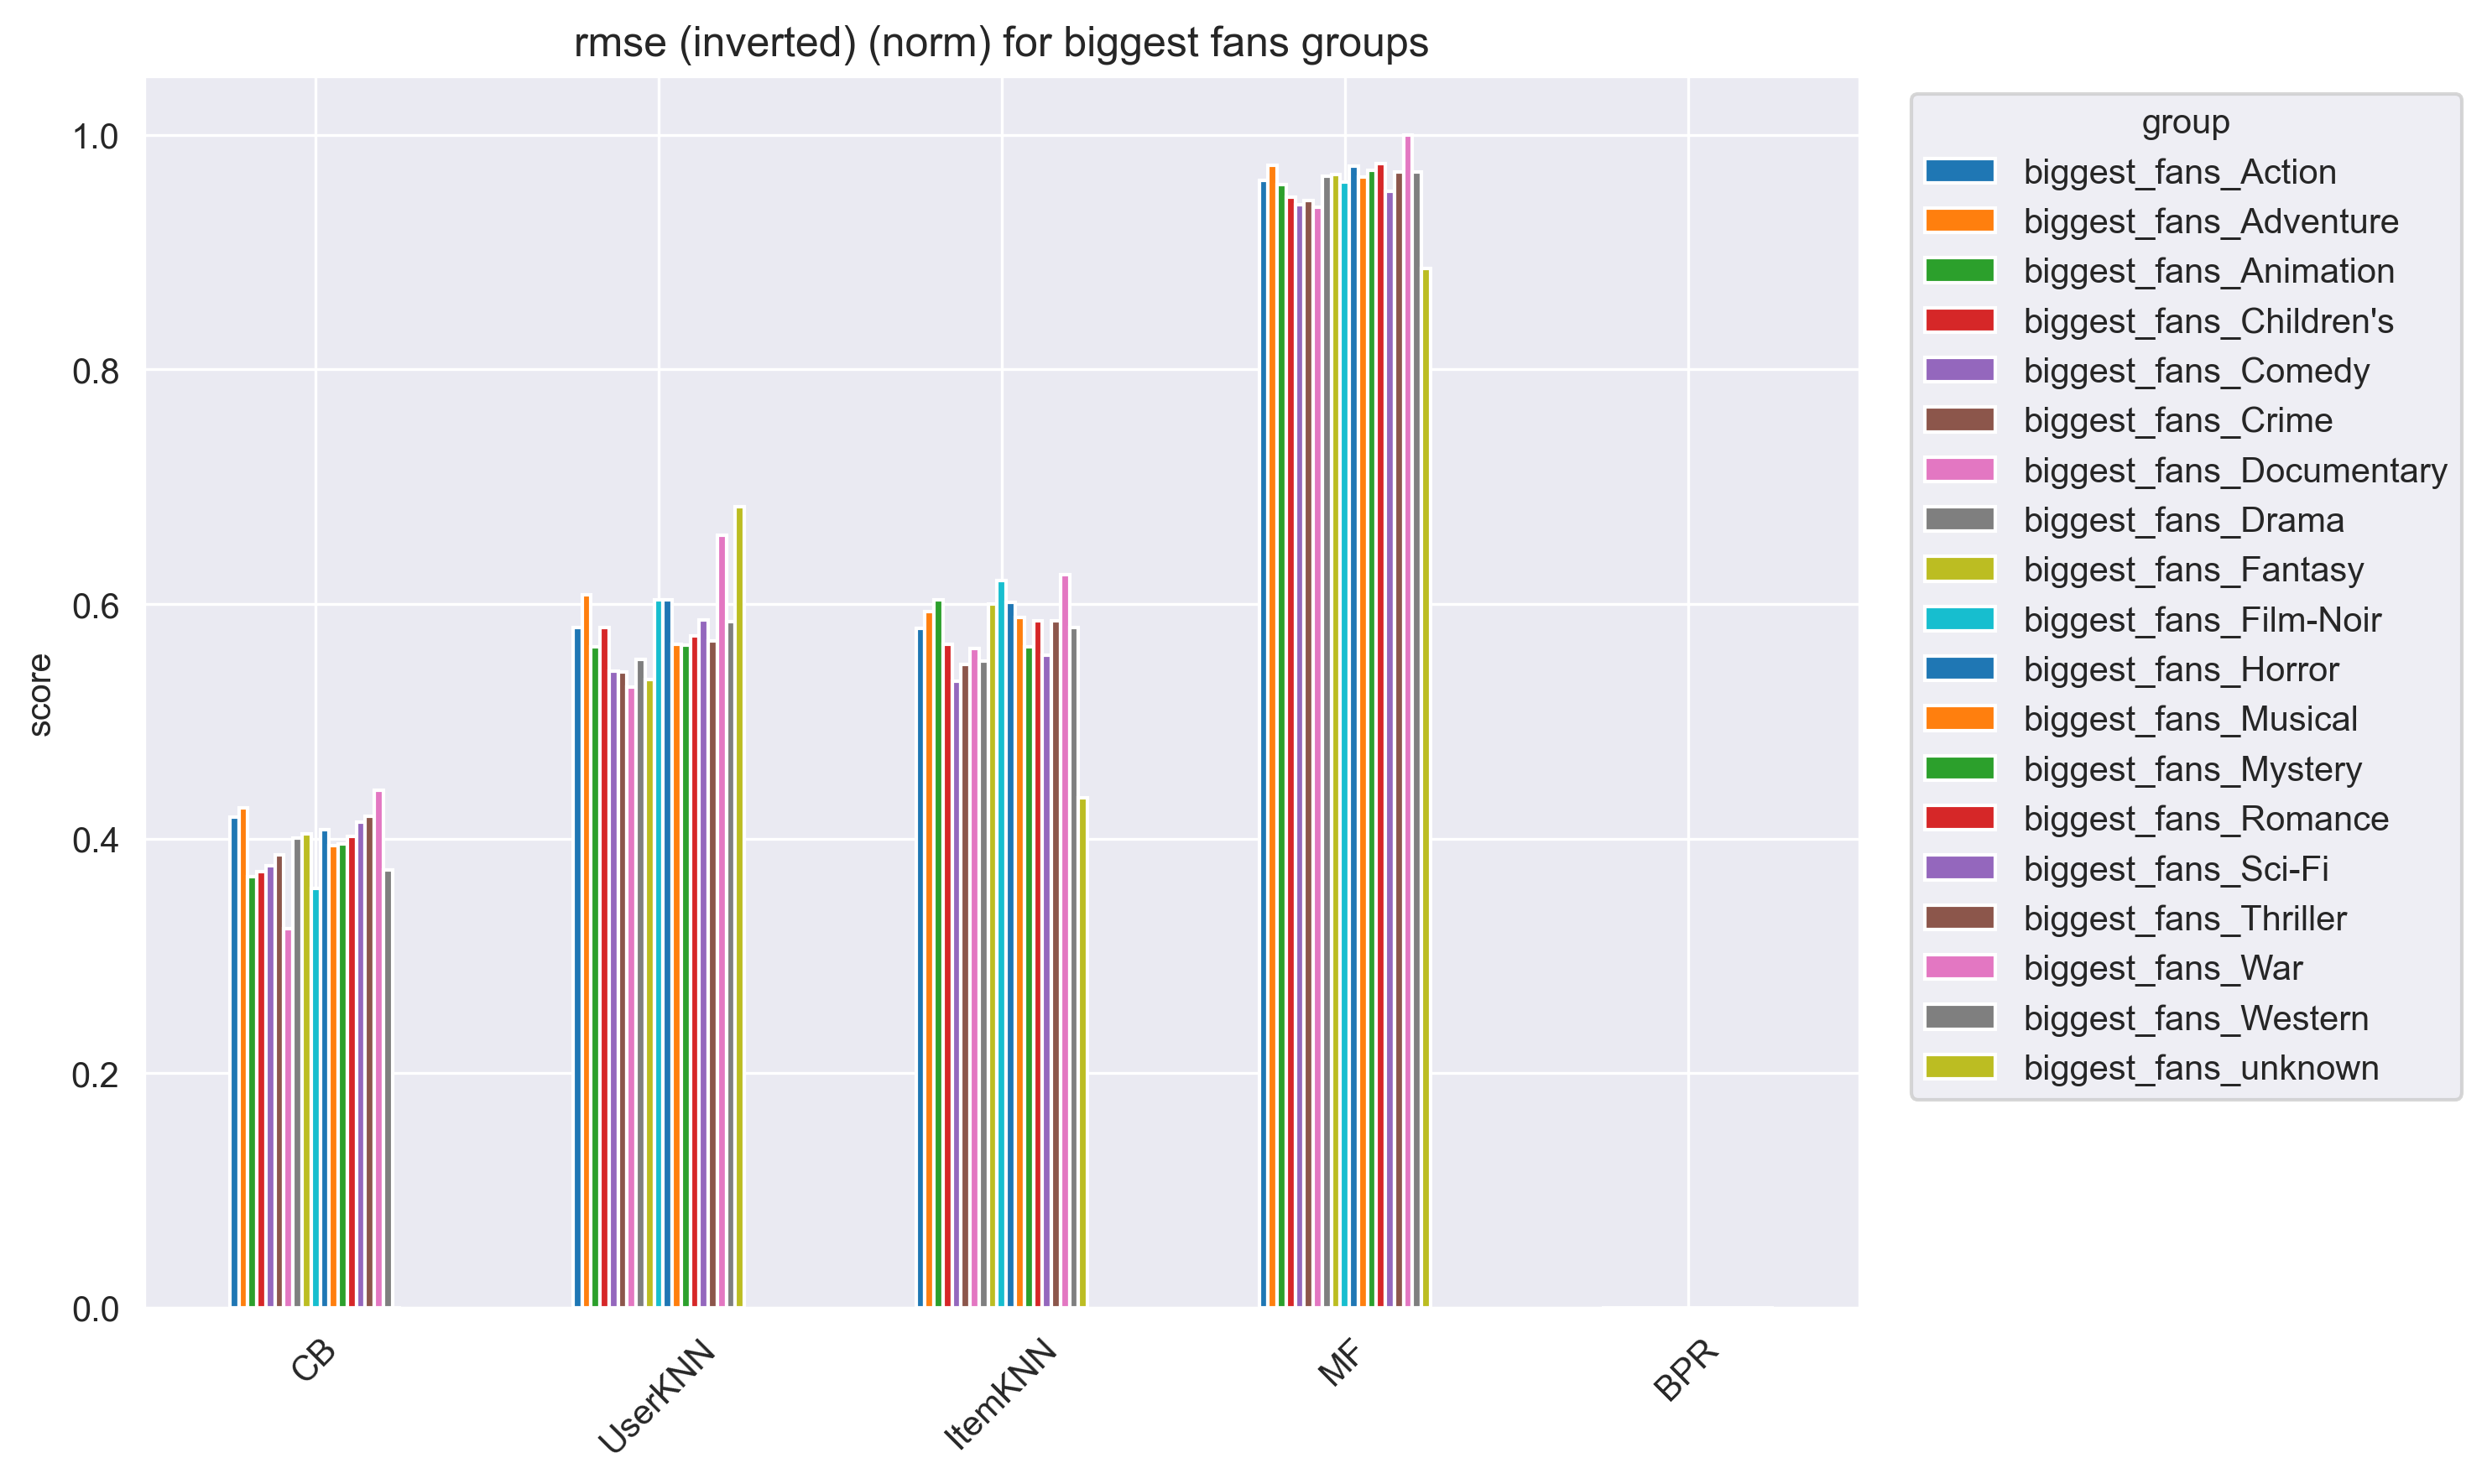

In [54]:
groups=sorted([g for g in results_groups.keys() if g.startswith('biggest_fans')])
metric = 'rmse'

mat = pd.DataFrame(index=models, columns=groups, dtype=float)
for g in groups:
    df = results_groups[g]
    if metric in df.columns:
        mat[g] = df[metric].reindex(models).astype(float)
if invert_rmse:
    # invert so larger is better (preserve scale)
    mat = mat.max().max() - mat
if normalize:
    # min-max normalize across all cells for this metric
    flattened = mat.values.flatten()
    # avoid constant columns causing NaN
    scaled = minmax_scale(flattened.reshape(-1,1)).reshape(mat.shape)
    mat = pd.DataFrame(scaled, index=models, columns=groups)
# plot barchart
mat.plot(kind='bar', figsize=(10,6))
plt.title(f'{metric} {"(inverted)" if (metric=="rmse" and invert_rmse) else ""}{" (norm)" if normalize else ""} for biggest fans groups')
plt.ylabel('score')
plt.xlabel('')
# scale y to [min value - 0.1,1]
plt.ylim(bottom=max(0, mat.values.min() - 0.1), top=1.05)
plt.legend(title='group', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

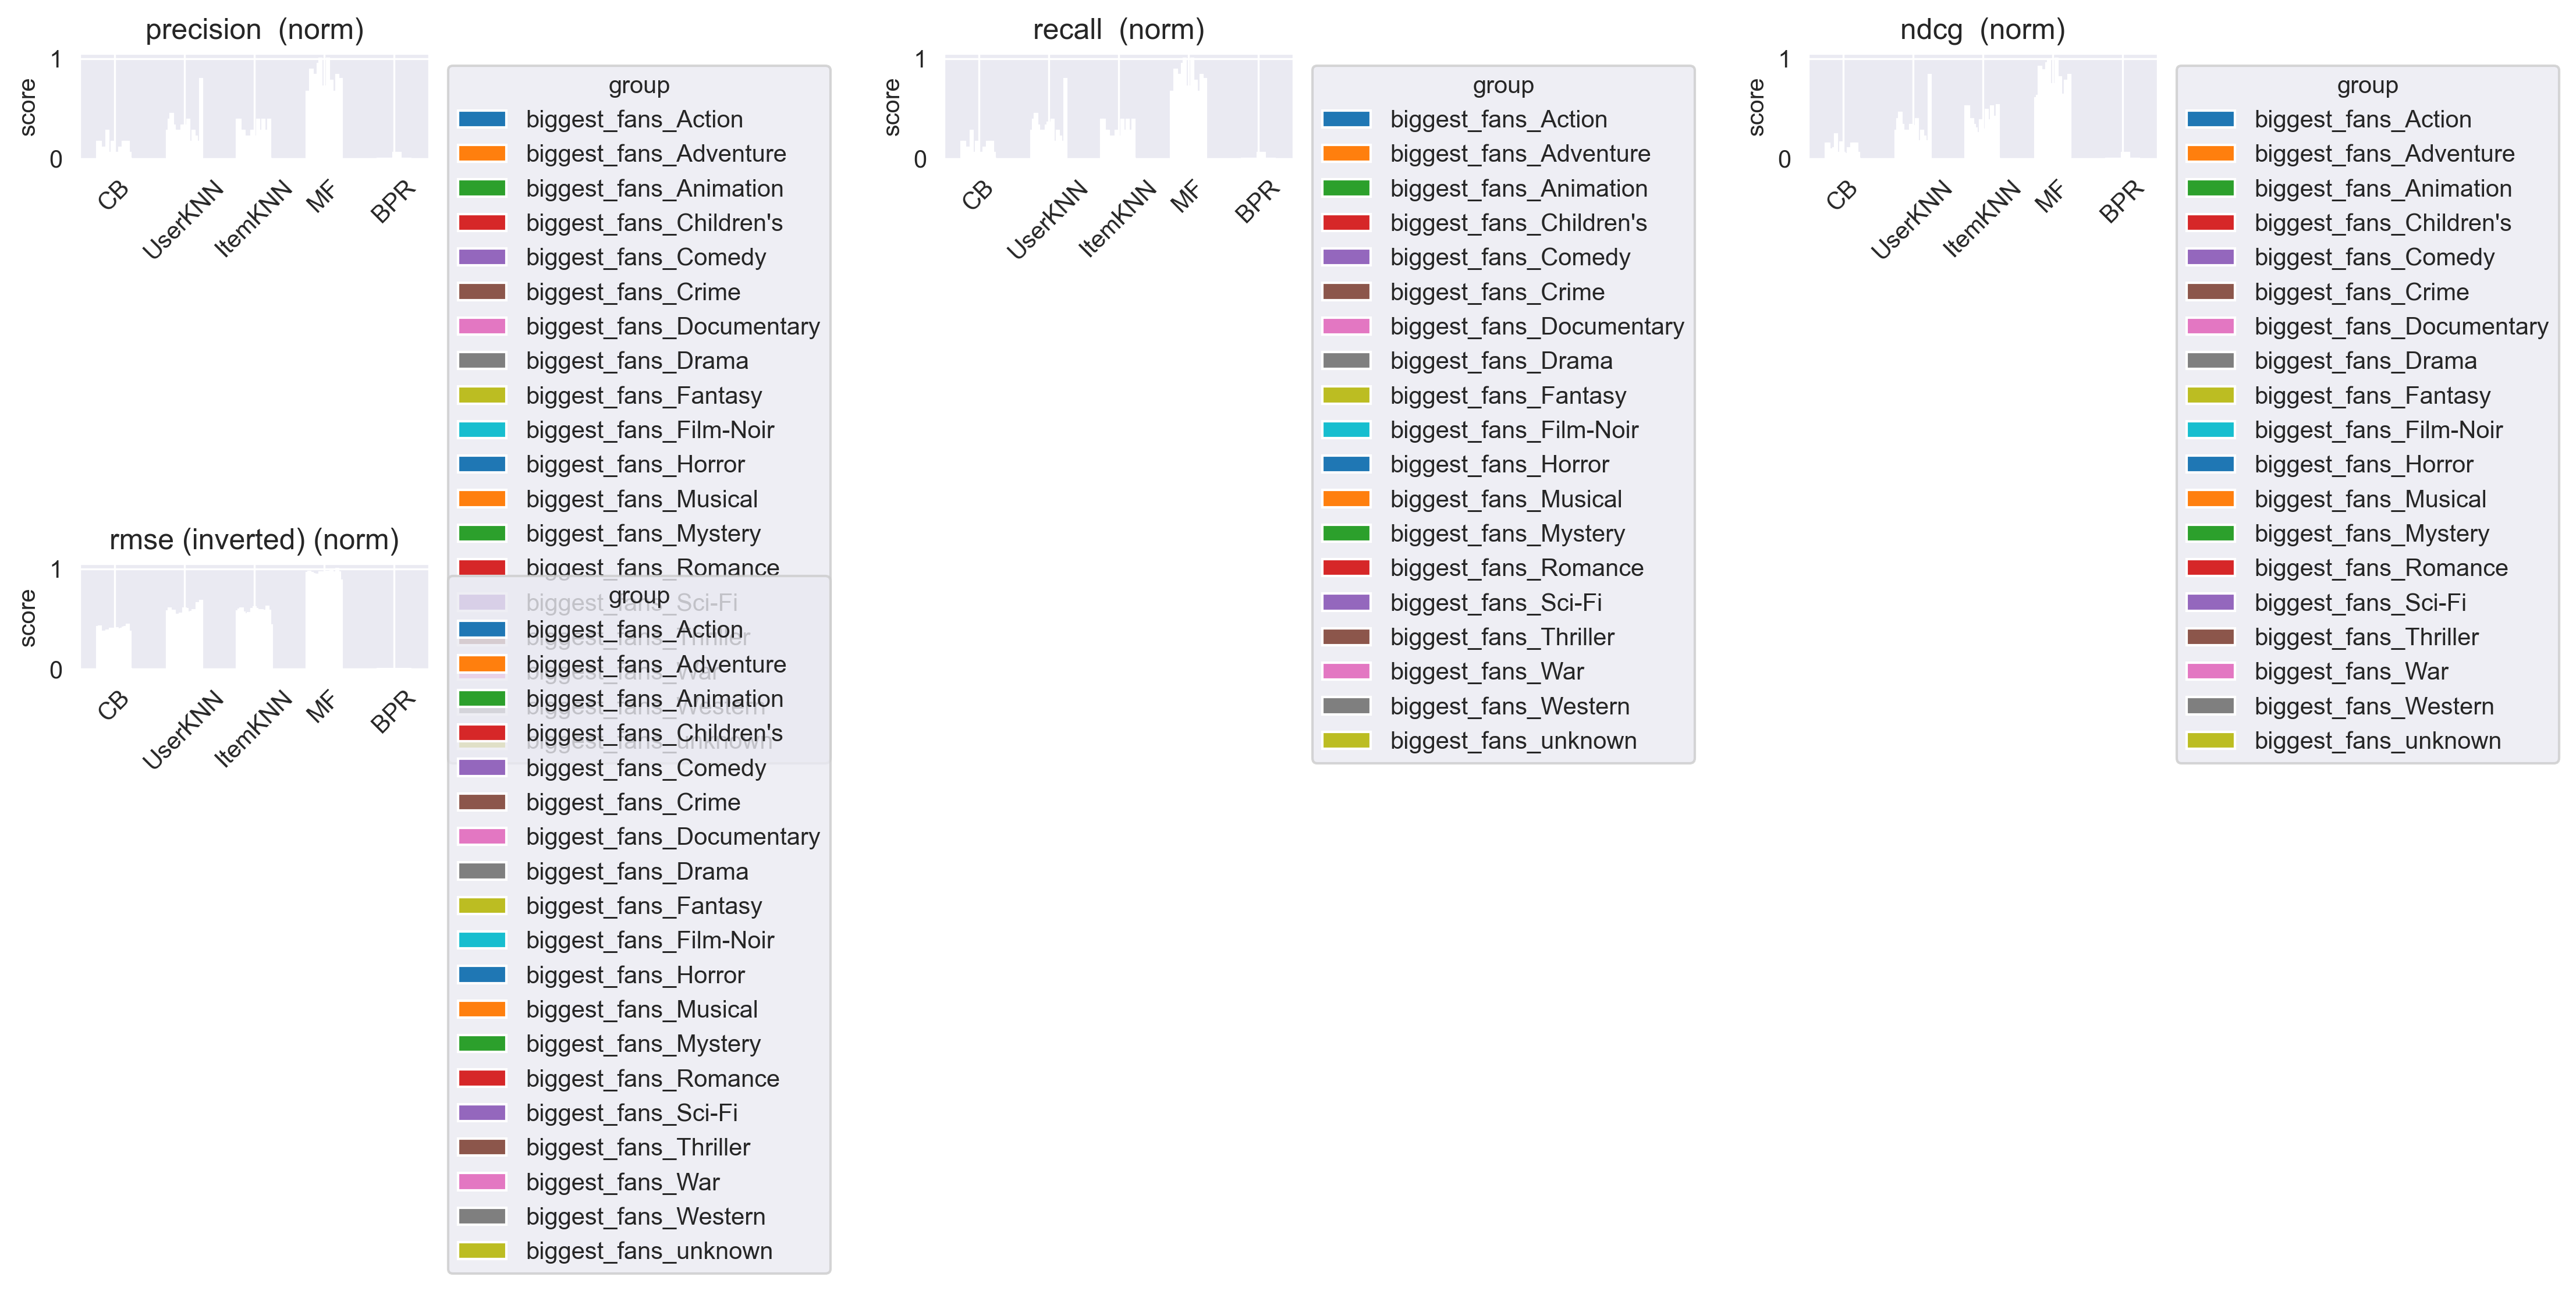

In [51]:
groups=sorted([g for g in results_groups.keys() if g.startswith('biggest_fans')])

metric_matrices = {}
for m in metrics:
    mat = pd.DataFrame(index=models, columns=groups, dtype=float)
    for g in groups:
        df = results_groups[g]
        if m not in df.columns:
            raise KeyError(f"Metric {m} not in group {g}")
        mat[g] = df[m].reindex(models).astype(float)
    if m == 'rmse' and invert_rmse:
        # invert so larger is better (preserve scale)
        mat = mat.max().max() - mat
    if normalize:
        # min-max normalize across all cells for this metric
        flattened = mat.values.flatten()
        # avoid constant columns causing NaN
        scaled = minmax_scale(flattened.reshape(-1,1)).reshape(mat.shape)
        mat = pd.DataFrame(scaled, index=models, columns=groups)
    metric_matrices[m] = mat

# --- Plot grouped bar charts (one subplot per metric) ---
n_metrics = len(metrics)
ncols = min(3, n_metrics)
nrows = ceil(n_metrics / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize_per_metric[0], nrows * figsize_per_metric[1]), squeeze=False)
for idx, m in enumerate(metrics):
    r = idx // ncols
    c = idx % ncols
    ax = axes[r][c]
    mat = metric_matrices[m]
    mat.plot(kind='bar', ax=ax)
    ax.set_title(f'{m} {"(inverted)" if (m=="rmse" and invert_rmse) else ""}{" (norm)" if normalize else ""}')
    ax.set_ylabel('score')
    ax.set_xlabel('')
    ax.legend(title='group', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)
# turn off unused axes
total = nrows * ncols
for k in range(n_metrics, total):
    r = k // ncols
    c = k % ncols
    axes[r][c].axis('off')
plt.tight_layout()
plt.show()


# Task 5) Evaluation of beyond accuracy

_Discuss your observations comparing the models in terms of both accuracy and non-accuracy metrics_

Apart from solely evaluating the models on accuracy metrics, we also look at the following non-accuracy metrics:
- Diversity (intra-list diversity)
- Novelty (surprisal)
- Calibration
- A number of fairness metrics (user- and item-side)

These metrics are first implemented below in sections 10.1-10.4, then used for analysis in section 11.

## Diversity - ILD

Diversity measures how different the items in a recommendation list are from each other. A diverse recommendation list is desirable as it exposes users to a wider range of items, potentially increasing user satisfaction and engagement. In our implementation, we use intra-list diversity (ILD) as the diversity metric. We take the Jaccard distance between the items' genres as the distance function, where a higher value indicates more difference between the genres. We choose this distance metric over other options such as category embedding distance because of its simplicity and interpretability. Another option debated on was using category embeddings from the content of the items (e.g., movie descriptions), but would require further research into how to weigh different categories to best obtain the embeddings.

The formula for ILD is as follows:

$$
ILD(L) = \frac{1}{|L|(|L|-1)} \sum_{i,j \in L}dist(i,j)
$$

where:
- $dist(i,j) = 1 - \frac{|G_1 \cap G_2|}{|G_1 \cup G_2|}$ - distance function of how different $i$ and $j$ are - Jaccard distance of genres.

In [69]:
def diversity(rec_list: pd.Series, dist_func, movies: pd.DataFrame) -> float:
    """
    Calculate intra-list diversity (ILD) for a given recommendation list using a specified distance function.
    :param rec_list: top-k recommended item ids
    :param dist_func: function taking two item ids and movie data, and returning a distance value
    :return:
    """
    if len(rec_list) <= 1:
        return 0.0
    L = len(rec_list)
    frac = 1 / (L * (L - 1))
    total_dist = np.sum([dist_func(i,j, movies) for i in rec_list.index.to_list() for j in rec_list.index.to_list()])
    return frac * total_dist


def genre_distance(item1, item2, movies):
    """
    Genre distance using Jaccard distance.
    :param item1: item id 1
    :param item2: item id 2
    :param movies: movie data
    :return:
    """
    i1_genres = set(movies.at[item1, 'genres'].split(','))
    i2_genres = set(movies.at[item2, 'genres'].split(','))
    intersection = len(i1_genres.intersection(i2_genres))
    union = len(i1_genres.union(i2_genres))
    if union == 0:
        return 0.0
    return 1 - intersection / union

def avg_diversity(ranking_predictions: dict, movies: pd.DataFrame, dist_func) -> tuple[floating, np.ndarray]:
    """
    Calculate average diversity for all users in ranking predictions and return this along with results.
    :param ranking_predictions: { model : { user_id: pd.Series with ranking predictions } }
    :param movies: movie data
    :return: (mean diversity, distribution of diversity scores)
    """
    results = np.array([diversity(ranking, dist_func, movies) for u, ranking in ranking_predictions.items()])
    return np.mean(results), results

def diversity_all(ranking_prediction_dict: dict, movies: pd.DataFrame, dist_func) -> dict:
    """
    Calculate diversity for all models in ranking prediction dict.
    :param ranking_prediction_dict: { model : { user_id: pd.Series with ranking predictions } }
    :param movies: movie data
    :return: { model : average diversity score }
    """
    res_dict = {}
    print(f'Calculating diversity for all models...')
    for model_name, user_rankings in tqdm(ranking_prediction_dict.items()):
        avg_div, distribution = avg_diversity(user_rankings, movies, dist_func)
        print(f'- {model_name}: Diversity = {avg_div:.4f}')
        res_dict[model_name] = avg_div
        res_dict[model_name+'_distribution'] = distribution
    return res_dict

## Novelty - surprisal

Novelty aims to measure how “novel” or “unexpected” the recommended items are to the user. A novel recommendation list is desirable as it can help users discover new items they might not have found otherwise, potentially increasing user satisfaction and engagement. In our implementation, we use surprisal as the novelty metric, as the novelty of an item is commonly approximated as an inverse of its popularity.

The formula for novelty is as follows:

$$
novelty(i) = -\log_{2} pop(i)
$$

where:
- $pop(i) = \frac{\text{no. interactions on }i}{\text{total no. interactions}}$ - popularity of item $i$ - percentage of interactions on item $i$

In [70]:
def novelty(rec_list: pd.Series, train_data: pd.DataFrame, weighting_scheme:str = 'uniform') -> float:
    """
    Calculate the novelty / surprisal of the items in a recommendation list
    :param rec_list: pd.Series of recommended item ids, columns=['rating'], index=item ids
    :param train_data: training data
    :param weighting_scheme: 'uniform' or 'log' - how to weight the novelty of items in the list
    :return: novelty score
    """

    popularity = train_data['item_id'].value_counts(normalize=True)
    surprisal = -np.log2(popularity)

    # Find the weightings for the averaging
    if weighting_scheme == 'uniform':
        weights = np.ones(len(rec_list)) / len(rec_list)
    elif weighting_scheme == 'log':
        ranks = np.arange(1, len(rec_list) + 1)
        weights = 1 / np.log2(ranks + 1)  # TODO - check!
        weights /= np.sum(weights)
    else:
        raise ValueError("weighting_scheme must be 'uniform' or 'log'")

    surprisals = np.array([surprisal.loc[item] for item in rec_list.index.tolist()])
    novelty_score = np.sum(weights * surprisals)
    return novelty_score

def avg_novelty(ranking_predictions: dict, train_data: pd.DataFrame, weighting: str = 'uniform') -> tuple[floating, np.ndarray]:
    """
    Calculate average diversity for all users in ranking predictions and return this along with results.
    :param weighting: how to average the novelty scores - 'uniform' or 'log'
    :param ranking_predictions: { model : { user_id: pd.Series with ranking predictions } }
    :param train_data: training data
    :return: (mean diversity, distribution of diversity scores)
    """
    results = np.array([novelty(ranking, train_data, weighting) for u, ranking in ranking_predictions.items()])
    return np.mean(results), results

def novelty_all(ranking_prediction_dict: dict, train_data: pd.DataFrame, weighting) -> dict:
    """
    Calculate diversity for all models in ranking prediction dict.
    :param weighting: how to average the novelty scores - 'uniform' or 'log'
    :param ranking_prediction_dict: { model : { user_id: pd.Series with ranking predictions } }
    :param train_data: training data
    :return: { model : average diversity score }
    """
    res_dict = {}
    print(f'Calculating diversity for all models...')
    for model_name, user_rankings in tqdm(ranking_prediction_dict.items()):
        avg_div, distribution = avg_novelty(user_rankings, train_data, weighting)
        print(f'- {model_name}: Novelty = {avg_div:.4f}')
        res_dict[model_name] = avg_div
        res_dict[model_name+'_distribution'] = distribution
    return res_dict

## Calibration

Calibration measures how well the recommended items align with the user's preferences. A well-calibrated recommendation list is desirable as it ensures that the recommendations are relevant to the user's interests, potentially increasing user satisfaction and engagement. In our implementation, we use Kullback-Leibler (KL) divergence as the calibration metric, which measures how well the distribution of genres within a recommendation list for a user aligns with that of the user's interaction history. The formula for calibration is as follows:

**Calibration metric** - Kullback-Leibler divergence (lower = better)
$$
\begin{align}
MC_{KL}(p,q) &= KL(p||q) = \sum_{g} p(g|u) \log \frac{p(g|u)}{q(g|u)} \\
\text{where...} \\
p(g|u) &= \frac{\sum_{i\in \mathcal{H}}w_{u,i} \times p(g|i)}{\sum_{i \in \mathcal{H}} w_{u,i}} \\
q(g|u) &= \frac{\sum_{i\in \mathcal{L}}w_{r(i)} \times p(g|i)}{\sum_{i \in \mathcal{L}} w_{r(i)}}
\end{align}
$$
where:
- $p(g|i)$ - genre-distribution of each movie - 'categorisation of item'
- $p(g|u)$ - distribution of genres $g$ in user $u$'s profile (based on training data)
    - $\mathcal{H}$ - interaction history
    - $w_{u,i}$ - weight of item $i$ - rating given by user $u$ to item $i$
- $q(g|u)$ - distribution of genres $g$ in the recommendation list for
    - $\mathcal{L}$ - recommended items
    - $w_{r(i)}$ - weight of item $i$ at rank $r(i)$ - weighting scheme used in ranking metrics
- to avoid division by zero - mask out anywhere where $p(g|u) = 0$ - [Link to wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)

In [71]:
def genre_distribution(movies: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate genre distribution for each movie.
    :param movies: [pd.DataFrame] containing movie metadata with columns=['item_id','title','genres','description']
    :return: pd.dataframe with all genres as columns, item id's as index, and p(g|i) as values
    """
    mov_genres = movies[['item_id', 'genres']].copy()
    mov_genres['genres'] = mov_genres['genres'].apply(lambda x: x.split(',')) # make the genres a list
    item_ids = mov_genres['item_id'].unique()
    # find all the genres present in the dataset
    all_genres = set()
    for genres in mov_genres['genres']:
        all_genres.update(genres)
    all_genres = list(all_genres)

    # calculate the distributions
    genre_dist = pd.DataFrame(np.zeros((len(item_ids), len(all_genres))), columns=all_genres, index=item_ids)
    for _, row in mov_genres.iterrows():
        item_id = row['item_id']
        genres = row['genres']
        genre_count = len(genres)
        for genre in genres:
            genre_dist.at[item_id, genre] = 1 / genre_count  # uniform distribution over genres
    return genre_dist

def get_interaction_history(user_id, train_data: pd.DataFrame) ->  pd.Series:
    """
    Get interaction history of a user from training data.
    :param user_id: user id
    :param train_data: training data dataframe
    :return: list of item ids the user has interacted with
    """
    user_history = train_data[train_data['user_id'] == user_id]
    return user_history[['item_id', 'rating']].set_index('item_id')['rating']

def compute_genre_distribution_of_user(genre, genre_dist: pd.DataFrame, history: pd.Series):
    """
    Helper function for calibration metric - compute p(g|u) / q(g|u) for a given genre and user interaction history.

    Formulas are basically equivalent:
        p(g|u) = (w_{u,i} * p(g|i) for items in user history) / (sum of weights)
        q(g|u) = (w_{r(i) * p(g|i) for items in recommendation list) / (sum of weights)

    :param genre: genre to compute distribution for
    :param genre_dist: pd.DataFrame with all genres as columns, item id's as index, and p(g|i) as values
    :param history: pd.Series of item ids and ratings the user has interacted with, index=item ids, values=ratings
    :return:
    """
    pgi = [genre_dist.at[item, genre] for item in history.index.tolist()]
    ratings = history.values
    weighted_sum = np.sum(np.array(pgi) * np.array(ratings))
    return weighted_sum / np.sum(ratings)

def calibration(rec_list: pd.Series, user, train_data: pd.DataFrame, movie_data: pd.DataFrame) -> float:
    """
    Calculate calibration metric for a given recommendation list and user.
    :param rec_list: pd.Series of recommended item ids, columns=['rating'], index=item ids
    :param user: user for whom the recommendation was made
    :param train_data: training data
    :param movie_data:
    :return:
    """
    a = 0.001  # small alpha to avoid division by zero
    genre_dist = genre_distribution(movie_data) # p(g|i) - should work
    genres = genre_dist.columns.tolist()

    # pgu - genre distribution in user profile
    user_history = get_interaction_history(user, train_data) # H - works
    pgu = np.array([compute_genre_distribution_of_user(g, genre_dist, user_history) for g in genres]) # p(g|u) - should work

    # qgu - genre distribution in recommendation list
    qgu = np.array([compute_genre_distribution_of_user(g, genre_dist, rec_list) for g in genres]) # q(g|u)

    mask = (pgu != 0) & (qgu != 0)
    res = np.sum(pgu[mask] * np.log(pgu[mask] / qgu[mask]))
    return res

def calibration_all(ranking_prediction_dict: dict, train_data: pd.DataFrame, movie_data: pd.DataFrame) -> dict:
    """
    Calculate calibration for all models in ranking prediction dict.
    :param ranking_prediction_dict: { model : { user_id: pd.Series with ranking predictions } }
    :param train_data: training data
    :param movie_data:
    :return: { model : average calibration score }
    """
    res_dict = {}
    print(f'Calculating calibration for all models...')
    for model_name, user_rankings in tqdm(ranking_prediction_dict.items()):
        results = np.array([calibration(ranking, user, train_data, movie_data) for user, ranking in user_rankings.items()])
        avg_cal = np.mean(results)
        print(f'- {model_name}: Calibration = {avg_cal:.4f}')
        res_dict[model_name] = avg_cal
        res_dict[model_name+'_distribution'] = results
    return res_dict

# should take ~ 30-40 secs on new mac

## Fairness

Fairness in recommendation systems aims to ensure that the recommendations provided to users are equitable and unbiased across different user groups or item categories. This is important to prevent discrimination and promote inclusivity in the recommendations. In our implementation, we consider both user-side and item-side fairness metrics. The fairness metrics we implement are as follows:

- **User-side** - RecSys serve individual users/groups equally
    - Group Recommendation Unfairness - GRU
    - User Popularity Deviation - UPD
- **Item-side** - fair representation of items
    - catalog coverage - fraction of items recommended at least once (need results for all rankings (item-user pairs))
    - equality of exposure using gini index

### User-side fairness

$$
\displaylines{
GRU(G_1, G_2, Q) = \left| \frac{1}{|G_1|} \sum_{i \in G_1} \mathcal{F} (Q_i) - \frac{1}{|G_2|} \sum_{i \in G_2} \mathcal{F}(Q_i) \right| \\
UPD(u) = dist(P(R_u), P(L_u))
}
$$

where:
- $\mathcal{F}(Q_i)$ - recommendation quality for user $u_i$, invoking a metric such as NDCG@K or F1 score
- $P(R_u)$ - popularity distribution of items in user $u$'s recommendation list
- $P(L_u)$ - popularity distribution of items in user $u$'s interaction history

In [ ]:
def group_rec_unfairness(group1: list, group2: list, rank_scores: pd.DataFrame) -> float:
    """
    Calculate Group Recommendation Unfairness (GRU) between two user groups, given a quality metric.
    :param group1: list of user ids in group 1
    :param group2: list of user ids in group 2
    :param metric: metric to use - ['nDCG', 'Precision', 'Recall', ...] - should match the column names in rank_scores
    :param rank_scores: scores of ranking tasks
    :return: GRU value as a float
    """
    g1_size = len(group1)
    g2_size = len(group2)
    if g1_size == 0 or g2_size == 0:
        return 0.0  # cannot compare a group w/ no users

    g1_avg = np.mean(rank_scores.at[group1]) / g1_size
    g2_avg = np.mean(rank_scores.at[group2]) / g2_size
    return g1_avg - g2_avg

group_rec_unfairness([1, 2, 3], [4, 5, 6], accuracy_metrics_df['ndcg'])  # TODO - get metric per user
# TODO - code for running on results of all models


In [72]:
def user_popularity_bias(user_id, rec_list: pd.Series, train_data: pd.DataFrame, ) -> float:
    item_popularity = popularity_matrix(train_data)
    user_history = get_interaction_history(user_id, train_data)
    p_ru = item_popularity.loc[rec_list.index.tolist()]
    p_lu = item_popularity.loc[user_history.index.tolist()]
    return np.mean(p_ru) - np.mean(p_lu)

def all_user_popularity_bias(ranking_prediction_dict: dict, train_data: pd.DataFrame) -> dict:
    res_dict = {}
    print(f'Calculating user popularity bias for all models...')
    for model_name, user_rankings in tqdm(ranking_prediction_dict.items()):
        user_pop_biases = [user_popularity_bias(user_id, rec_list, train_data) for user_id, rec_list in user_rankings.items()]
        avg_pop_bias = np.mean(user_pop_biases)
        print(f'- {model_name}: Average User Popularity Bias = {avg_pop_bias:.4f}')
        res_dict[model_name] = avg_pop_bias
        res_dict[model_name+'_distribution'] = user_pop_biases
    return res_dict

### Item-side fairness

$$
\displaylines{
\text{catalog coverage} = \frac{\text{no. items appearing in 1+ recommendation}}{\text{total no. items in movie data}} \\
\text{equality of exposure} = 1 - 2 \sum_{i=1}^{N} P(i) \cdot \frac{i}{N}
}
$$

where:
- ffff

In [73]:
def catalog_coverage(rec_lists: list[pd.Series], movie_data: pd.DataFrame) -> float:
    total_no_movies = movie_data['item_id'].nunique()
    if total_no_movies == 0:
        return 0.0
    recommended_items = set()
    for rec_list in rec_lists:
        recommended_items.update(rec_list.index.tolist())
    no_recommended_items = len(recommended_items)
    return no_recommended_items / total_no_movies

def catalog_coverage_all(ranking_prediction_dict: dict, movie_data: pd.DataFrame) -> dict:
    """
    Calculate catalog coverage for all models in ranking prediction dict.
    :param ranking_prediction_dict: { model : { user_id: pd.Series with ranking predictions } }
    :param movie_data:
    :return: { model : catalog coverage score }
    """
    res_dict = {}
    print(f'Calculating catalog coverage for all models...')
    for model_name, user_rankings in tqdm(ranking_prediction_dict.items()):
        cov = catalog_coverage(user_rankings.values(), movie_data)
        print(f'- {model_name}: Catalog Coverage = {cov:.4f}')
        res_dict[model_name] = cov
    return res_dict

In [74]:
def equality_of_exposure(rec_lists: list[pd.Series], movie_data: pd.DataFrame) -> float: # TODO - go over
    total_no_movies = movie_data['item_id'].nunique()
    if total_no_movies == 0:
        return 0.0
    exposure_counts = pd.Series(0, index=movie_data['item_id'].tolist())
    for rec_list in rec_lists:
        for item in rec_list.index.tolist():
            exposure_counts.at[item] += 1
    exposure_probs = exposure_counts / exposure_counts.sum()
    gini_index = 1 - 2 * np.sum(exposure_probs.cumsum() * (1 / total_no_movies))
    return gini_index

def equality_of_exposure_all(ranking_prediction_dict: dict, movie_data: pd.DataFrame) -> dict:
    """
    Calculate equality of exposure for all models in ranking prediction dict.
    :param ranking_prediction_dict: { model : { user_id: pd.Series with ranking predictions } }
    :param movie_data:
    :return: { model : equality of exposure score }
    """
    res_dict = {}
    print(f'Calculating equality of exposure for all models...')
    for model_name, user_rankings in tqdm(ranking_prediction_dict.items()):
        eq_exp = equality_of_exposure(user_rankings.values(), movie_data)
        print(f'- {model_name}: Equality of Exposure = {eq_exp:.4f}')
        res_dict[model_name] = eq_exp
    return res_dict

# Analysis of model performance

## Accuracy metrics

### Individual models and hybrid recommender - Task 3

### Models against baselines - Task 3

## Non-accuracy metrics - Task 3 and Task 5


In [75]:
# Running all non-accuracy metrics on ranking results
diversities = diversity_all(ranking_predictions, movies, genre_distance)
diversity_df = pd.DataFrame.from_dict(diversities, orient='index', columns=['value']).reset_index().rename(columns={'index':'model'})
diversity_df = diversity_df[~diversity_df['model'].str.endswith('_distribution')]

novelties = novelty_all(ranking_predictions, train_data, 'uniform')
novelty_df = pd.DataFrame.from_dict(novelties, orient='index', columns=['value']).reset_index().rename(columns={'index':'model'})
novelty_df = novelty_df[~novelty_df['model'].str.endswith('_distribution')]

calibrations = calibration_all(ranking_predictions, train_data, movies)
calibration_df = pd.DataFrame.from_dict(calibrations, orient='index', columns=['value']).reset_index().rename(columns={'index':'model'})
calibration_df = calibration_df[~calibration_df['model'].str.endswith('_distribution')]

user_pop_biases_all = all_user_popularity_bias(ranking_predictions, train_data)
user_pop_biases_df = pd.DataFrame.from_dict(user_pop_biases_all, orient='index', columns=['value']).reset_index().rename(columns={'index':'model'})
user_pop_biases_df = user_pop_biases_df[~user_pop_biases_df['model'].str.endswith('_distribution')]

cat_cov_all = catalog_coverage_all(ranking_predictions, movies)
cat_cov_df = pd.DataFrame.from_dict(cat_cov_all, orient='index', columns=['value']).reset_index().rename(columns={'index':'model'})
cat_cov_df = cat_cov_df[~cat_cov_df['model'].str.endswith('_distribution')]

eq_exp_all = equality_of_exposure_all(ranking_predictions, movies)
eq_exp_df = pd.DataFrame.from_dict(eq_exp_all, orient='index', columns=['value']).reset_index().rename(columns={'index':'model'})
eq_exp_df = eq_exp_df[~eq_exp_df['model'].str.endswith('_distribution')]

non_ac_metrics = {
    'diversity': diversities,
    'novelty': novelties,
    'calibration': calibrations,
    'user_popularity_bias': user_pop_biases_all,
    'catalog_coverage': cat_cov_all,
    'equality_of_exposure': eq_exp_all
}

Calculating diversity for all models...


 17%|█▋        | 1/6 [00:00<00:00,  7.80it/s]

- CB: Diversity = 0.8390


 33%|███▎      | 2/6 [00:00<00:00,  8.07it/s]

- UserKNN: Diversity = 0.7985


 50%|█████     | 3/6 [00:00<00:00,  8.13it/s]

- ItemKNN: Diversity = 0.8723


 67%|██████▋   | 4/6 [00:00<00:00,  8.20it/s]

- MF: Diversity = 0.7400


 83%|████████▎ | 5/6 [00:00<00:00,  8.26it/s]

- BPR: Diversity = 0.8711


100%|██████████| 6/6 [00:00<00:00,  8.20it/s]


- hybrid: Diversity = 0.8843
Calculating diversity for all models...


  0%|          | 0/6 [00:00<?, ?it/s]


KeyError: 1520.0

In [ ]:
# VISUALISATION - plot all non-accuracy metrics -> subplots for space
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# first - diversity
sns.barplot(data=diversity_df, x='model', y='value', ax=axes[0,0])
axes[0,0].set_title('Diversity')
axes[0,0].set_xlabel('Recommendation Model')
axes[0,0].set_ylabel('Diversity Score')
axes[0,0].tick_params(axis='x', rotation=45)

# second - novelty
sns.barplot(data=novelty_df, x='model', y='value', ax=axes[0,1])
axes[0,1].set_title('Novelty')
axes[0,1].set_xlabel('Recommendation Model')
axes[0,1].set_ylabel('Surprisal Score')
axes[0,1].tick_params(axis='x', rotation=45)

# third - calibration
sns.barplot(data=calibration_df, x='model', y='value', ax=axes[0,2])
axes[0,2].set_title('Calibration')
axes[0,2].set_xlabel('Recommendation Model')
axes[0,2].set_ylabel('KL Divergence')
axes[0,2].tick_params(axis='x', rotation=45)

# fourth - user popularity bias
sns.barplot(data=user_pop_biases_df, x='model', y='value', ax=axes[1,0])
axes[1,0].set_title('User Popularity Bias')
axes[1,0].set_xlabel('Recommendation Model')
axes[1,0].set_ylabel('Average Popularity Bias')
axes[1,0].tick_params(axis='x', rotation=45)

# fifth - catalog coverage
sns.barplot(data=cat_cov_df, x='model', y='value', ax=axes[1,1])
axes[1,1].set_title('Catalog Coverage')
axes[1,1].set_xlabel('Recommendation Model')
axes[1,1].set_ylabel('Coverage Score')
axes[1,1].tick_params(axis='x', rotation=45)

# sixth - equality of exposure
sns.barplot(data=eq_exp_df, x='model', y='value', ax=axes[1,2])
axes[1,2].set_title('Equality of Exposure')
axes[1,2].set_xlabel('Recommendation Model')
axes[1,2].set_ylabel('Gini Index')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

\[Analysis here]

### Non-accuracy vs accuracy

In [ ]:
# accuracy vs non-accuracy metrics correlation
# merge accuracy and non-accuracy metrics into one dataframe for ranking models
full_df = accuracy_metrics_df.merge(
    diversity_df.rename(columns={'value':'diversity'}),
    on='model'
).merge(
    novelty_df.rename(columns={'value':'novelty'}),
    on='model'
).merge(
    calibration_df.rename(columns={'value':'calibration'}),
    on='model'
).merge(
    user_pop_biases_df.rename(columns={'value':'user_popularity_bias'}),
    on='model'
).merge(
    cat_cov_df.rename(columns={'value':'catalog_coverage'}),
    on='model'
).merge(
    eq_exp_df.rename(columns={'value':'equality_of_exposure'}),
    on='model'
)

full_df.set_index('model', inplace=True)
full_df.to_csv('results/accuracy_non_accuracy_metrics_ranking.csv')

correlation_matrix = full_df.corr()
# correlation_matrix

# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
# plt.title("Correlation Matrix between Accuracy and Non-Accuracy Metrics")
# plt.show()